In [ ]:
# ==============================================================================
# Copyright 2019 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import pickle
import random
import time
import numpy as np
import pandas as pd
import tensorflow as tf
assert tf.__version__.startswith('2')
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, ReLU, Activation
from tensorflow.keras.layers import UpSampling2D, Conv2D, Concatenate, Dense, concatenate
from tensorflow.keras.layers import Flatten, Lambda, Reshape, ZeroPadding2D, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


Generate images from text input

Adding noise to both the conditioning variable and the image serves different purposes in the training process of the generator.

Adding Noise to the Conditioning Variable:
The conditioning variable is generated by conditioning_augmentation, which takes the mean and standard deviation as inputs and generates the variable "c" by adding noise. This noise injection serves two main purposes:

Introducing Variation: By adding noise to the conditioning variable, the generator is exposed to different variations of the same input. This helps in generating diverse outputs for a given text input, which can improve the quality and diversity of the generated images.
Regularization: Adding noise to the conditioning variable can act as a regularization technique, preventing the generator from overfitting to specific conditioning distributions. It encourages the generator to learn a more general mapping from the conditioning variable to the image.
Adding Noise to the Image:
Adding noise to the image generated by the generator helps in several ways:

Enhancing Realism: Adding random noise to the generated image can introduce imperfections and details that make the image more realistic. It can help in simulating textures, subtle variations, and fine details that exist in real images.
Improving Robustness: By exposing the generator to noisy images, it becomes more robust to noise and small perturbations in the input. This can help in generating better-quality images even when the input is noisy or imperfect.
In summary, adding noise to both the conditioning variable and the generated image helps in introducing variation, enhancing realism, improving robustness, and preventing overfitting, ultimately leading to better-quality and more diverse generated images.

In [ ]:
# conditioned by the text.
def conditioning_augmentation(text_data):
    # Splitting the input text_data into mean and log_sigma components
    # The first 128 values correspond to the mean, and the remaining values correspond to log_sigma
    mean = text_data[:, :128]
		# The reason for using the logarithm of the standard deviation
	  # instead of the standard deviation itself is often related to mathematical convenience and numerical stability.
		# By working with the logarithm, certain mathematical operations can be simplified, and the values can be better handled in various calculations.
    log_sd = text_data[:, 128:]
    # Calculating the standard deviation
    stddev = tf.math.exp(log_sd)
    # Generating random noise
    random_noise = K.random_normal(shape=K.constant((mean.shape[1], ), dtype='int32'))
		# stddev * random_noise:
		# The random noise is multiplied by the standard deviation to scale it according to the desired level of variation.
		# This step determines how much the random noise will affect the final conditioned text variable.
		# c = mean + (stddev * random_noise):
		# This combination creates the conditioned text variable c.
		# It captures both the typical characteristics represented by the mean and the random variations introduced by the scaled random noise.
    # Computing the text conditioning variable using mean, stddev, and epsilon
    c = mean + stddev * random_noise
    return c

# The input layer is defined with shape (1024,).
# A dense layer with 128 units is added to the network to reduce the dimensionality of the input.
# The rectified linear unit (ReLU) activation function is applied to introduce non-linearity and increase the expressive power of the network.
# The model is defined with the input layer as the input and the output of the dense layer as the output.
# The model is compiled using the binary cross-entropy loss function and the Adam optimizer.
def build_ca_network():
    # Define the input layer with a shape of (1024,), representing the size of the vocabulary in the text data
    input_layer1 = Input(shape=(1024,))
    # Apply a Dense layer with 256 units to the input layer
    x = Dense(256)(input_layer1)
    # Apply LeakyReLU activation function with an alpha value of 0.2 to the output of the Dense layer
    x = LeakyReLU(alpha=0.2)(x)
    # In the LeakyReLU activation function, when the input value is negative, instead of outputting zero as in the ReLU function, it outputs a small negative value proportional to the input. The parameter "alpha" determines the proportion of the negative value. In this case, the value of "alpha" is set to 0.2,
    # which means that if the input is negative, the output will be 0.2 times the input value.
    # Use the Lambda layer to apply the conditioning_augmentation function to the output of the LeakyReLU layer
    ca = Lambda(conditioning_augmentation)(x)
    # Define the model by specifying the inputs and outputs
    return Model(inputs=[input_layer1], outputs=[ca])

# build_ca_network function defines the architecture of the conditioning augmentation network,
# while conditional_augmentation function performs the actual calculations to generate the conditioned text variable during the
# model's forward pass. Both functions work together to incorporate text conditioning information into the image generation process

#Here, x is image data - By upsampling the feature maps in the neural network, the network can learn to generate images with
# higher resolution and capture more intricate details, resulting in more visually appealing and realistic output
def UpSamplingBlock(x, num_kernels):
    # Upsample the input using UpSampling2D with a size of (2,2) -> height and width have been doubled as size=(2,2)
    x = UpSampling2D(size=(2, 2))(x)
    # Apply Conv2D layer with `num_kernels` kernels, using a kernel size of (3,3), 'same' padding, and 'he_uniform' kernel initializer
    x = Conv2D(num_kernels, kernel_size=(3, 3), padding='same', strides=1, use_bias=False, kernel_initializer='he_uniform')(x) # With "same" padding, the output feature map has the same spatial dimensions as the input.
    # Apply BatchNormalization to normalize the activations along the channel axis
    x = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x)
    # Apply ReLU activation to introduce non-linearity
		# trial - Leaky
    x = LeakyReLU(alpha=0.2)(x)
    # x = ReLU()(x)
    return x

# Initially, the input layer receives the text embedding as input, which represents the conditioning information for image generation.
# The conditioning_augmentation function is applied to the text embedding, generating the conditioned text variable c.
# The function concatenates the conditioned text c with a random noise vector.
# Next, a fully connected Dense layer with 16,384 units (corresponding to the shape (4, 4, 1024)) is applied to the concatenated tensor.
# The ReLU activation function is used to introduce non-linearity to the output of the Dense layer.
# The tensor is reshaped to have dimensions (4, 4, 1024), which serves as the initial low-resolution feature map.
# The UpSamplingBlock function is then applied multiple times, gradually increasing the spatial dimensions of the feature map.
# Each UpSamplingBlock doubles the height and width of the feature map using upsampling operations.
# Convolutional layers are applied to generate the final output image with three color channels (RGB).
# The Tanh activation function is used to normalize the pixel values of the generated image to the range [-1, 1].
# Finally, the model is defined with the input layers of text embedding and random noise, and the outputs of the generated image and the conditioned text embedding.
def build_stage1_generator():
    input_layer1 = Input(shape=(1024,))  # Input layer for text embedding
    intermediate_text_embedding = Dense(256)(input_layer1)  # Fully connected layer to process text embedding
    intermediate_text_embedding = LeakyReLU(alpha=0.2)(intermediate_text_embedding)  # LeakyReLU activation applied to the output of the previous layer
    # Obtain the conditioned text using the conditioning_augmentation function
    conditioned_variable = Lambda(conditioning_augmentation)(intermediate_text_embedding)
    input_layer2 = Input(shape=(100,))  # Input layer for random noise
    concat = Concatenate(axis=1)([conditioned_variable, input_layer2])  # Concatenate the conditioned text and the random noise
    x = Dense(16384, use_bias=False)(concat)  # Dense layer with 16384 units
    x = ReLU()(x)  # ReLU activation applied to the output of the previous layer
    x = Reshape((4, 4, 1024), input_shape=(16384,))(x)  # Reshape the tensor to (4, 4, 1024)
    # Upsampling blocks to increase the spatial dimensions
    # The use of different kernel sizes in the upsampling blocks
    # allows the network to learn and capture different levels of spatial details and patterns at each stage.
    x = UpSamplingBlock(x, 512) # 8*8*512
    x = UpSamplingBlock(x, 256) # 16*16*256
    x = UpSamplingBlock(x, 128) # 32*32*128
    x = UpSamplingBlock(x, 64)  # 64*64*64
    x = Conv2D(3, kernel_size=3, padding='same', strides=1, use_bias=False, kernel_initializer='he_uniform')(x)  # Convolutional layer to generate image
    # 64x64x3
    # The tanh activation function is commonly used in generative models, such as GANs,
    # because it maps the output values to the range [-1, 1]. It is advantageous for image generation tasks as it allows the generator to produce both positive and negative pixel values, capturing a wider range of colors and intensities.
    x = Activation('tanh')(x)  # Tanh activation applied to the output of the previous layer
    stage1_gen = Model(inputs=[input_layer1, input_layer2], outputs=[x, intermediate_text_embedding])  # Define the model with inputs and outputs
    return stage1_gen

generator = build_stage1_generator()
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          262400      ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 256)          0           ['dense[0][0]']                  
                                                                                                  
 lambda (Lambda)                (None, 128)          0           ['leaky_re_lu[0][0]']            
                                                                                              

Build discriminator to classify images as real and fake

 In image-to-text synthesis, the image embedding is typically combined with a corresponding text embedding, which represents the desired textual description. To ensure compatibility and alignment between these embeddings, it is crucial to compress the image embedding to a similar or appropriate dimensionality as the text embedding.

In [ ]:
# The ConvBlock function defines a basic convolutional block. It takes an input tensor x,
# the number of convolutional kernels (num_kernels), and other optional parameters such as kernel size, strides, and activation.
# It applies a convolutional layer followed by batch normalization and, if activation is set to True, a LeakyReLU activation function.
# The function returns the processed tensor.

def ConvBlock(x, num_kernels, kernel_size=(4, 4), strides=2, activation=True):
    x = Conv2D(num_kernels, kernel_size=kernel_size, padding='same', strides=strides, use_bias=False,
               kernel_initializer='he_uniform')(x)
    #padding='same' means that the input is padded with zeros in such a way that the output feature map has the same dimensions (height and width) as the input.
    x = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x)
    if activation:
        x = LeakyReLU(alpha=0.2)(x)
    return x

# The build_embedding_compressor function constructs an embedding compressor model.
# It takes an input layer of shape (1024,) and applies a fully connected layer with 128 units and a ReLU activation function.
# The resulting tensor is the compressed representation of the input text embedding. The function returns the constructed model.
def build_embedding_compressor():
    """Build embedding compressor model"""
    input_layer1 = Input(shape=(1024,))  # Input layer with shape (1024,)
    x = Dense(128)(input_layer1)  # Fully connected layer with 128 units
    x = ReLU()(x)  # ReLU activation function applied to the output of the dense layer
    model = Model(inputs=[input_layer1], outputs=[x])  # Create a model with the input and output layers
    return model

# The build_stage1_discriminator function builds the Stage 1 Discriminator model.
# It takes a 64x64 resolution image from the generator (input_layer1) and a compressed and spatially replicated text embedding (input_layer2) as inputs.
# The input image (input_layer1) is processed using a convolutional layer with 64 kernels, a kernel size of (4,4), and strides of 2.
# The resulting tensor is passed through a LeakyReLU activation function.
# Next, the tensor is passed through three ConvBlock functions with increasing numbers of convolutional kernels
#  (128, 256, 512). Each ConvBlock applies a convolutional layer, batch normalization, and a LeakyReLU activation function.
# The compressed and spatially replicated text embedding (input_layer2) is concatenated with the output tensor from the last ConvBlock layer.
# The concatenated tensor is processed with a 1x1 convolutional layer followed by batch normalization and a LeakyReLU activation function.
# The resulting tensor is flattened and passed through a fully connected layer with 1 unit, representing the output prediction of the discriminator.
# Finally, the output prediction is passed through a sigmoid activation function to obtain a probability value between 0 and 1.
# The build_stage1_discriminator function returns the constructed Stage 1 Discriminator model.
# the discriminator is fed with two inputs, the feature from Generator and the text embedding
def build_stage1_discriminator():
	input_layer1 = Input(shape=(64, 64, 3))
	x = Conv2D(64, kernel_size=(4,4), strides=2, padding='same', use_bias=False,
				kernel_initializer='he_uniform')(input_layer1) #(64, 64, 3) -> (32, 32, 64)
	x = LeakyReLU(alpha=0.2)(x)
	x = ConvBlock(x, 128) # (16, 16, 128)
	x = ConvBlock(x, 256) # (8, 8, 256)
	x = ConvBlock(x, 512) # (4, 4, 512)
	# Obtain the compressed and spatially replicated text embedding
	input_layer2 = Input(shape=(4, 4, 128)) #2nd input to discriminator, text embedding
	concat = concatenate([x, input_layer2])
	x1 = Conv2D(512, kernel_size=(1,1), padding='same', strides=1, use_bias=False,
				kernel_initializer='he_uniform')(concat)
	x1 = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x)
	x1 = LeakyReLU(alpha=0.2)(x)
	# Flatten and add a FC layer to predict.
	x1 = Flatten()(x1)
	x1 = Dense(1)(x1)
	x1 = Activation('sigmoid')(x1)
	stage1_dis = Model(inputs=[input_layer1, input_layer2], outputs=[x1])
	return stage1_dis


discriminator = build_stage1_discriminator()
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 32, 32, 64)   3072        ['input_3[0][0]']                
                                                                                                  
 leaky_re_lu_5 (LeakyReLU)      (None, 32, 32, 64)   0           ['conv2d_5[0][0]']               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 16, 16, 128)  131072      ['leaky_re_lu_5[0][0]']          
                                                                                            

Build the adverserial model

In [ ]:
def build_adversarial(generator_model, discriminator_model):
    # Define input layers for the adversarial model
    input_layer1 = Input(shape=(1024,))   # Input for text
    input_layer2 = Input(shape=(100,))    # Input for noise
    input_layer3 = Input(shape=(4, 4, 128))  # Input for compressed and spatially replicated text embedding
    # Generate an image from the generator model using the input text and noise
    x, ca = generator_model([input_layer1, input_layer2])
    # Set the discriminator model as non-trainable -> Setting the discriminator as non-trainable in the initial stage
    # allows the generator to improve its performance without being adversely affected by the discriminator's learning.
    # This way, the generator can explore the solution space more effectively and generate better samples, leading to improved overall performance of the GAN.
    discriminator_model.trainable = False
    # Get the probabilities and compressed attributes from the discriminator model using the generated image and input embedding
    probabilities = discriminator_model([x, input_layer3]) #The discriminator produces a probability value indicating the likelihood of the input image
    # Construct the adversarial model by combining the inputs and outputs
    adversarial_model = Model(inputs=[input_layer1, input_layer2, input_layer3], outputs=[probabilities, ca])
    # Return the adversarial model
    return adversarial_model

ganstage1 = build_adversarial(generator, discriminator)
ganstage1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1024)]       0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 model (Functional)             [(None, 64, 64, 3),  10270400    ['input_5[0][0]',                
                                 (None, 256)]                     'input_6[0][0]']                
                                                                                                  
 input_7 (InputLayer)           [(None, 4, 4, 128)]  0           []                         

Define required functions

In [ ]:
# returns the prefix for the checkpoint file path.
# def checkpoint_prefix():
#     checkpoint_prefix = '/content/drive/MyDrive/StackGAN_1'
#     return checkpoint_prefix

# loads the data required for training the StackGAN model. It modifies the paths to use Google Drive paths and then loads class IDs,
# filenames, text embeddings, and bounding box information. It crops and resizes the images based on the bounding box information and returns the processed data.
def load_data(filename_path, class_id_path, dataset_path, embeddings_path, size):
    # Modify the paths to use Google Drive paths
    data_dir = "/content/drive/MyDrive/StackGAN_1/birds"
    train_dir = data_dir + "/train"
    test_dir = data_dir + "/test"
    embeddings_path_train = train_dir + "/char-CNN-RNN-embeddings.pickle"
    embeddings_path_test = test_dir + "/char-CNN-RNN-embeddings.pickle"
    filename_path_train = train_dir + "/filenames.pickle"
    filename_path_test = test_dir + "/filenames.pickle"
    class_id_path_train = train_dir + "/class_info.pickle"
    class_id_path_test = test_dir + "/class_info.pickle"
    dataset_path = "/content/drive/MyDrive/StackGAN_1/CUB_200_2011/CUB_200_2011"
    class_id, filenames = load_class_ids_filenames(class_id_path, filename_path)
    embeddings = load_text_embeddings(embeddings_path)
    bbox_dict = load_bbox(dataset_path)

    x, y, embeds = [], [], []

    for i, filename in enumerate(filenames):
      bbox = bbox_dict[filename]

      try:
        image_path = f'{dataset_path}/images/{filename}.jpg'
        image = load_images(image_path, bbox, size)
        e = embeddings[i, :, :]
        embed_index = np.random.randint(0, e.shape[0] - 1)
        embed = e[embed_index, :]

        x.append(np.array(image))
        y.append(class_id[i])
        embeds.append(embed)

      except Exception as e:
        pass

    x = np.array(x)
    y = np.array(y)
    embeds = np.array(embeds)

    return x, y, embeds
# saves the provided image file at the specified file path
def save_image(file, save_path):
	image = plt.figure()
	ax = image.add_subplot(1,1,1)
	ax.imshow(file)
	ax.axis("off")
	plt.savefig(save_path)

# The adversarial loss in a GAN quantifies the difference between generated and real samples, and the generator aims to minimize this loss to produce realistic outputs that the discriminator cannot distinguish from real data.
# calculates the adversarial loss for the generator network in the StackGAN model.
# It extracts the mean and standard deviation values from the predicted output and calculates the loss based on these values.
def adversarial_loss(y_true, y_pred):
	mean = y_pred[:, :128]
	ls = y_pred[:, 128:]
	loss = -ls + 0.5 * (-1 + tf.math.exp(2.0 * ls) + tf.math.square(mean))
	loss = K.mean(loss)
	return loss
# normalizes the input and real images by scaling their pixel values to the range [-1, 1]
def normalize(input_image, real_image):
	input_image = (input_image / 127.5) - 1
	real_image = (real_image / 127.5) - 1

	return input_image, real_image
# This function loads the class IDs and filenames from the provided pickle files.
def load_class_ids_filenames(class_id_path, filename_path):
	with open(class_id_path, 'rb') as file:
		class_id = pickle.load(file, encoding='latin1')

	with open(filename_path, 'rb') as file:
		filename = pickle.load(file, encoding='latin1')

	return class_id, filename

def load_text_embeddings(text_embeddings):
	with open(text_embeddings, 'rb') as file:
		embeds = pickle.load(file, encoding='latin1')
		embeds = np.array(embeds)

	return embeds
# This function loads the bounding box information from the bounding_boxes.txt file in the dataset path
def load_bbox(data_path):
	bbox_path = data_path + '/bounding_boxes.txt'
	image_path = data_path + '/images.txt'
	bbox_df = pd.read_csv(bbox_path, delim_whitespace=True, header=None).astype(int)
	filename_df = pd.read_csv(image_path, delim_whitespace=True, header=None)

	filenames = filename_df[1].tolist()
	bbox_dict = {i[:-4]:[] for i in filenames[:2]}

	for i in range(0, len(filenames)):
		bbox = bbox_df.iloc[i][1:].tolist()
		dict_key = filenames[i][:-4]
		bbox_dict[dict_key] = bbox

	return bbox_dict
# This function loads and processes the image at the specified path. It crops the image based on the bounding box and resizes it to the specified size.
def load_images(image_path, bounding_box, size):
	"""Crops the image to the bounding box and then resizes it.
	"""
	image = Image.open(image_path).convert('RGB')
	w, h = image.size
	if bounding_box is not None:
		r = int(np.maximum(bounding_box[2], bounding_box[3]) * 0.75)
		c_x = int((bounding_box[0] + bounding_box[2]) / 2)
		c_y = int((bounding_box[1] + bounding_box[3]) / 2)
		y1 = np.maximum(0, c_y - r)
		y2 = np.minimum(h, c_y + r)
		x1 = np.maximum(0, c_x - r)
		x2 = np.minimum(w, c_x + r)
		image = image.crop([x1, y1, x2, y2])

	image = image.resize(size, PIL.Image.BILINEAR)
	return image

1
2
3
4
Epoch: 0
5
6
7
8
2/2 [==============================] - 5s 13ms/step
9
10
11
12
13
Discriminator Loss: 0.9490599986165762


Generator Loss: [0.5114087462425232, 0.47608625888824463, 0.017661236226558685]


6
7
8
2/2 [==============================] - 0s 19ms/step
9
10
11
12
13
Discriminator Loss: 0.6929059522226453
Generator Loss: [1.4295902252197266, 1.3913428783416748, 0.01912366785109043]


6
7
8
2/2 [==============================] - 0s 13ms/step
9
10
11
12
13
Discriminator Loss: 0.8848530470859259
Generator Loss: [1.2522592544555664, 1.2128386497497559, 0.01971030980348587]


<ipython-input-7-37637e706fff>:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  image = plt.figure()


6
7
8
2/2 [==============================] - 0s 11ms/step
9
10
11
12
13
Discriminator Loss: 0.7656794432550669
Generator Loss: [2.890953302383423, 2.8483800888061523, 0.021286632865667343]


6
7
8
2/2 [==============================] - 0s 12ms/step
9
10
11
12
13
Discriminator Loss: 0.2647841675207019
Generator Loss: [0.7716817855834961, 0.7315992712974548, 0.020041245967149734]


6
7
8
2/2 [==============================] - 0s 16ms/step
9
10
11
12
13
Discriminator Loss: 0.6682977937743999


Generator Loss: [3.2176320552825928, 3.1802284717559814, 0.018701773136854172]


6
7
8
2/2 [==============================] - 0s 12ms/step
9
10
11
12
13
Discriminator Loss: 0.39741009660065174
Generator Loss: [1.0304560661315918, 0.9973945617675781, 0.016530746594071388]


6
7
8
2/2 [==============================] - 0s 12ms/step
9
10
11
12
13
Discriminator Loss: 0.618164021987468
Generator Loss: [0.8147277235984802, 0.7428572177886963, 0.03593525290489197]


6
7
8
2/2 [==============================] - 0s 12ms/step
9
10
11
12
13
Discriminator Loss: 0.5698544875440348
Generator Loss: [3.1359078884124756, 3.055126190185547, 0.040390871465206146]


6
7
8
2/2 [==============================] - 0s 12ms/step
9
10
11
12
13
Discriminator Loss: 0.45867685973644257
Generator Loss: [0.9019336700439453, 0.8437219858169556, 0.029105857014656067]


6
7
8
2/2 [==============================] - 0s 12ms/step
9
10
11
12
13
Discriminator Loss: 0.4748274151897931
Generator Loss: [1.8948098421096802, 1.8466681241989136, 0.024070855230093002]


6
7
8
2/2 [==============================] - 0s 12ms/step
9
10
11
12
13
Discriminator Loss: 0.47490855515934527
Generator Loss: [1.09933340549469, 1.059588074684143, 0.019872691482305527]


6
7
8
2/2 [==============================] - 0s 12ms/step
9
10
11
12
13
Discriminator Loss: 0.7064798428679069
Generator Loss: [3.5644404888153076, 3.5307064056396484, 0.0168670192360878]


6
7
8
2/2 [==============================] - 0s 12ms/step
9
10
11
12
13
Discriminator Loss: 0.6087623397979769
Generator Loss: [2.9566824436187744, 2.924091339111328, 0.01629551872611046]


6
7
8
2/2 [==============================] - 0s 11ms/step
9
10
11
12
13
Discriminator Loss: 0.3113526739180088
Generator Loss: [0.4802284836769104, 0.41949862241744995, 0.03036493808031082]


6
7
8
2/2 [==============================] - 0s 11ms/step
9
10
11
12
13
Discriminator Loss: 0.24691180791705847
Generator Loss: [1.1574026346206665, 1.1116948127746582, 0.02285391464829445]


6
7
8
2/2 [==============================] - 0s 12ms/step
9
10
11
12
13
Discriminator Loss: 0.25495823955134256
Generator Loss: [0.4381810426712036, 0.3963882327079773, 0.02089640498161316]


6
7
8
2/2 [==============================] - 0s 11ms/step
9
10
11
12
13
Discriminator Loss: 0.19778148528712336
Generator Loss: [0.4638778269290924, 0.431490033864975, 0.016193896532058716]


6
7
8
2/2 [==============================] - 0s 11ms/step
9
10
11
12
13
Discriminator Loss: 0.194899473892292
Generator Loss: [0.4127373695373535, 0.3828487694263458, 0.014944296330213547]


6
7
8
2/2 [==============================] - 0s 12ms/step
9
10
11
12
13
Discriminator Loss: 0.21410985029433505
Generator Loss: [0.5776309967041016, 0.5465314984321594, 0.015549737960100174]


6
7
8
2/2 [==============================] - 0s 11ms/step
9
10
11
12
13
Discriminator Loss: 0.2425455543161661
Generator Loss: [0.4127654433250427, 0.37645286321640015, 0.01815629005432129]


6
7
8
2/2 [==============================] - 0s 12ms/step
9
10
11
12
13
Discriminator Loss: 0.21441686439720797
Generator Loss: [0.4374014437198639, 0.4069296717643738, 0.015235891565680504]


6
7
8
2/2 [==============================] - 0s 11ms/step
9
10
11
12
13
Discriminator Loss: 0.203657485808435
Generator Loss: [1.9767004251480103, 1.9435502290725708, 0.016575103625655174]


6
7
8
2/2 [==============================] - 0s 12ms/step
9
10
11
12
13
Discriminator Loss: 0.1841172140048002
Generator Loss: [0.4864874482154846, 0.4405815899372101, 0.02295292355120182]


6
7
8
2/2 [==============================] - 0s 14ms/step
9
10
11
12
13
Discriminator Loss: 0.193573953894429
Generator Loss: [0.41010043025016785, 0.37407970428466797, 0.01801036298274994]


6
7
8
2/2 [==============================] - 0s 12ms/step
9
10
11
12
13
Discriminator Loss: 0.19498788232340303
Generator Loss: [0.47016066312789917, 0.4349134862422943, 0.017623592168092728]


6
7
8
2/2 [==============================] - 0s 12ms/step
9
10
11
12
13
Discriminator Loss: 0.1809543407352976
Generator Loss: [0.42185476422309875, 0.3872249722480774, 0.017314892262220383]


6
7
8
2/2 [==============================] - 0s 12ms/step
9
10
11
12
13
Discriminator Loss: 0.23428885255725618
Generator Loss: [0.5040805339813232, 0.4508856534957886, 0.02659742534160614]


6
7
8
2/2 [==============================] - 0s 12ms/step
9
10
11
12
13
Discriminator Loss: 0.1996112711603928
Generator Loss: [0.5040188431739807, 0.44826409220695496, 0.027877386659383774]


Epoch: 1
5
6
7
8
2/2 [==============================] - 0s 12ms/step
9
10
11
12
13
Discriminator Loss: 0.20960674676143753
Generator Loss: [0.3830859363079071, 0.34984803199768066, 0.01661895215511322]


6
7
8
2/2 [==============================] - 0s 19ms/step
9
10
11
12
13
Discriminator Loss: 0.18829045414486245


Generator Loss: [0.686941385269165, 0.6497600674629211, 0.01859065517783165]


6
7
8
2/2 [==============================] - 0s 14ms/step
9
10
11
12
13
Discriminator Loss: 0.18419818571192081
Generator Loss: [0.38302356004714966, 0.3455398678779602, 0.018741853535175323]


6
7
8
2/2 [==============================] - 0s 12ms/step
9
10
11
12
13
Discriminator Loss: 0.18100151018279576
Generator Loss: [0.4399298429489136, 0.3981627821922302, 0.020883530378341675]


6
7
8
2/2 [==============================] - 0s 12ms/step
9
10
11
12
13
Discriminator Loss: 0.18122962956931588
Generator Loss: [0.5591928958892822, 0.5193626880645752, 0.019915089011192322]


6
7
8
2/2 [==============================] - 0s 12ms/step
9
10
11
12
13
Discriminator Loss: 0.17820153426055185
Generator Loss: [0.6855979561805725, 0.648961067199707, 0.018318435177206993]


6
7
8
2/2 [==============================] - 0s 12ms/step
9
10
11
12
13
Discriminator Loss: 0.1821511696525704
Generator Loss: [0.4394976496696472, 0.406292200088501, 0.01660272851586342]


6
7
8
2/2 [==============================] - 0s 12ms/step
9
10
11
12
13
Discriminator Loss: 0.1708396374124277
Generator Loss: [0.5995100736618042, 0.5305224657058716, 0.03449379652738571]


6
7
8
2/2 [==============================] - 0s 12ms/step
9
10
11
12
13
Discriminator Loss: 0.1823908773412768
Generator Loss: [0.5189535617828369, 0.4442406892776489, 0.0373564250767231]


6
7
8
2/2 [==============================] - 0s 11ms/step
9
10
11
12
13
Discriminator Loss: 0.1805899744895214
Generator Loss: [0.4080876111984253, 0.3537045121192932, 0.02719155326485634]


6
7
8
2/2 [==============================] - 0s 12ms/step
9
10
11
12
13
Discriminator Loss: 0.17878705628027092
Generator Loss: [0.40259048342704773, 0.35782375931739807, 0.022383365780115128]


6
7
8
2/2 [==============================] - 0s 12ms/step
9
10
11
12
13
Discriminator Loss: 0.17702326689868642
Generator Loss: [0.42643824219703674, 0.388872355222702, 0.01878293976187706]


6
7
8
2/2 [==============================] - 0s 12ms/step
9
10
11
12
13
Discriminator Loss: 0.17571296853111562
Generator Loss: [0.40760552883148193, 0.3754546642303467, 0.016075432300567627]


6
7
8
2/2 [==============================] - 0s 12ms/step
9
10
11
12
13
Discriminator Loss: 0.17701610998574324
Generator Loss: [0.3781055808067322, 0.3470417261123657, 0.015531934797763824]


6
7
8
2/2 [==============================] - 0s 12ms/step
9
10
11
12
13
Discriminator Loss: 0.1733355838823627
Generator Loss: [0.41149604320526123, 0.3566698133945465, 0.027413107454776764]


6
7
8
2/2 [==============================] - 0s 12ms/step
9
10
11
12
13
Discriminator Loss: 0.17421970756731753


Generator Loss: [0.3821118175983429, 0.3398051857948303, 0.021153315901756287]


6
7
8
2/2 [==============================] - 0s 12ms/step
9
10
11
12
13
Discriminator Loss: 0.1743449812684048
Generator Loss: [0.3994680643081665, 0.3621329665184021, 0.01866755075752735]


6
7
8
2/2 [==============================] - 0s 12ms/step
9
10
11
12
13
Discriminator Loss: 0.1728283922711853
Generator Loss: [0.38333866000175476, 0.35391056537628174, 0.014714043587446213]


6
7
8
2/2 [==============================] - 0s 12ms/step
9
10
11
12
13
Discriminator Loss: 0.17250195155520487
Generator Loss: [0.37231922149658203, 0.345252126455307, 0.013533541932702065]


6
7
8
2/2 [==============================] - 0s 11ms/step
9
10
11
12
13
Discriminator Loss: 0.1710802704674279


Generator Loss: [0.4286760091781616, 0.40119844675064087, 0.013738779351115227]


6
7
8
2/2 [==============================] - 0s 13ms/step
9
10
11
12
13
Discriminator Loss: 0.17432400484540267
Generator Loss: [0.600291907787323, 0.5673317909240723, 0.01648006960749626]


6
7
8
2/2 [==============================] - 0s 12ms/step
9
10
11
12
13
Discriminator Loss: 0.1821426888836868
Generator Loss: [0.396847665309906, 0.36882394552230835, 0.014011867344379425]


6
7
8
2/2 [==============================] - 0s 12ms/step
9
10
11
12
13
Discriminator Loss: 0.1729878317728435
Generator Loss: [0.37527480721473694, 0.344959020614624, 0.015157893300056458]


6
7
8
2/2 [==============================] - 0s 12ms/step
9
10
11
12
13
Discriminator Loss: 0.17008077378068265
Generator Loss: [0.40628838539123535, 0.36771345138549805, 0.019287459552288055]


6
7
8
2/2 [==============================] - 0s 12ms/step
9
10
11
12
13
Discriminator Loss: 0.17353785959312518
Generator Loss: [0.3952549397945404, 0.3647109568119049, 0.0152719896286726]


6
7
8
2/2 [==============================] - 0s 12ms/step
9
10
11
12
13
Discriminator Loss: 0.17265415486690472
Generator Loss: [0.3839063346385956, 0.35293567180633545, 0.01548533421009779]


6
7
8
2/2 [==============================] - 0s 12ms/step
9
10
11
12
13
Discriminator Loss: 0.1686947549233082
Generator Loss: [0.37520238757133484, 0.34500229358673096, 0.015100041404366493]


6
7
8
2/2 [==============================] - 0s 11ms/step
9
10
11
12
13
Discriminator Loss: 0.17436668970185565
Generator Loss: [0.39123302698135376, 0.34697556495666504, 0.02212873473763466]


6
7
8
2/2 [==============================] - 0s 12ms/step
9
10
11
12
13
Discriminator Loss: 0.17092814736815853
Generator Loss: [0.6700866222381592, 0.6234170198440552, 0.023334786295890808]


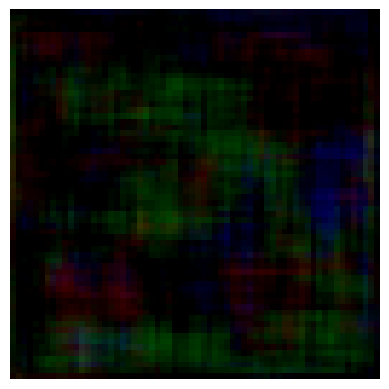

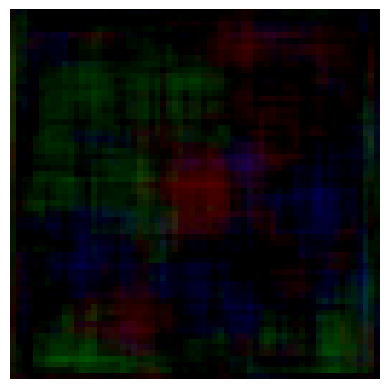

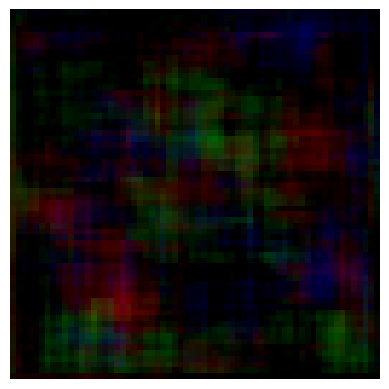

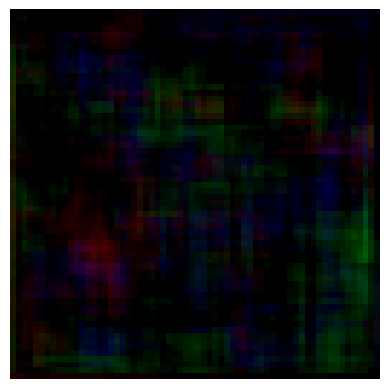

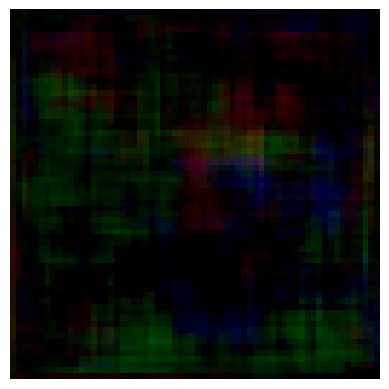

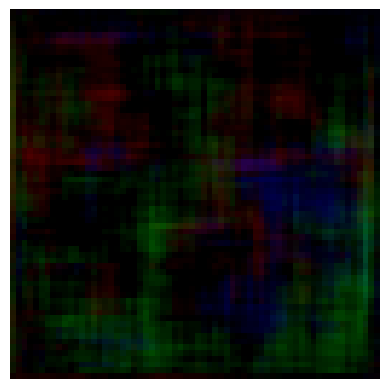

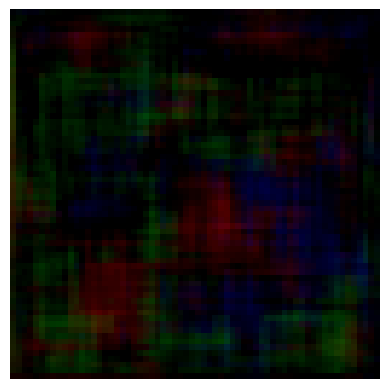

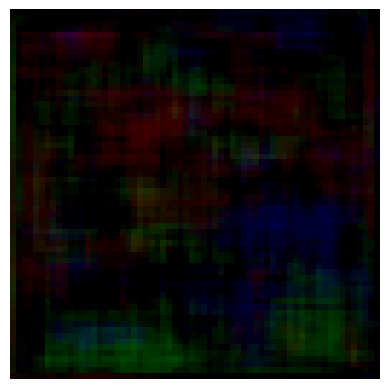

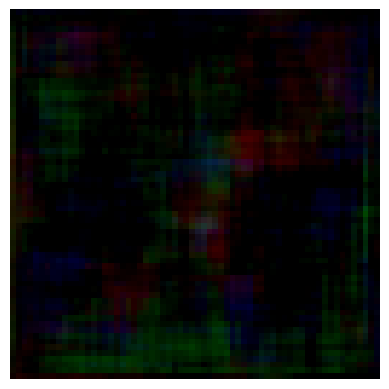

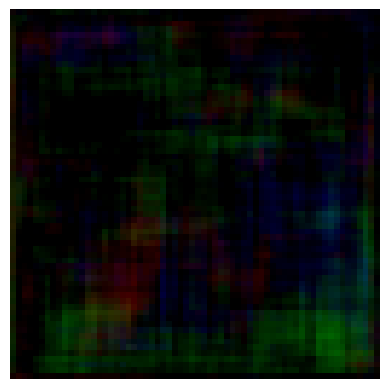

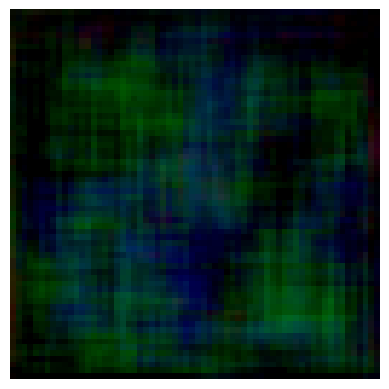

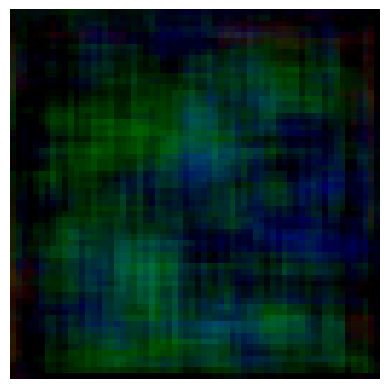

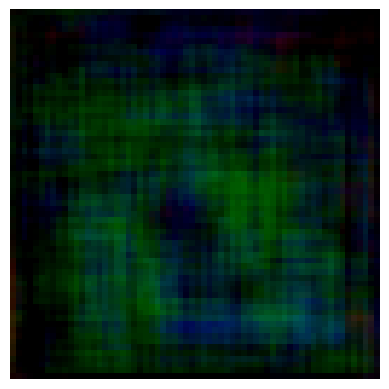

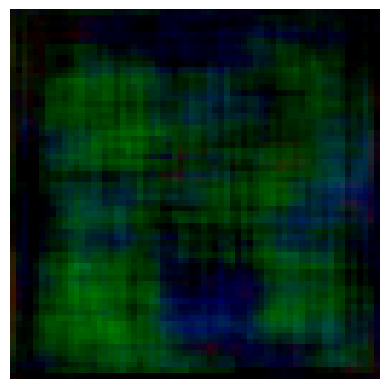

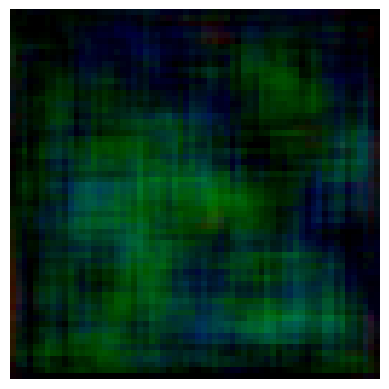

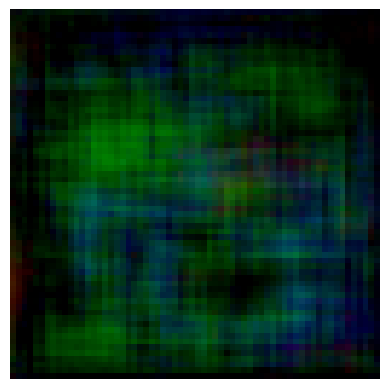

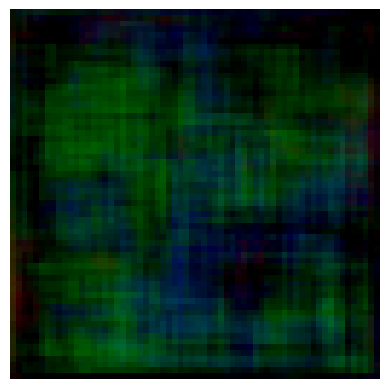

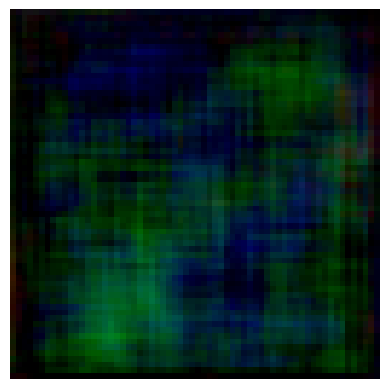

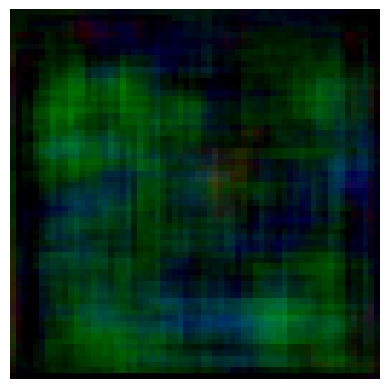

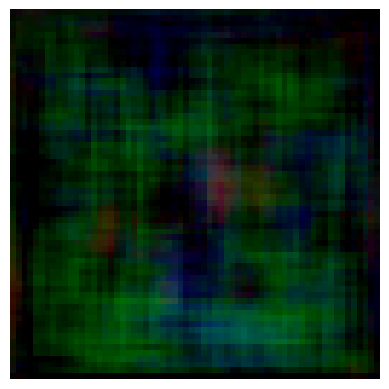

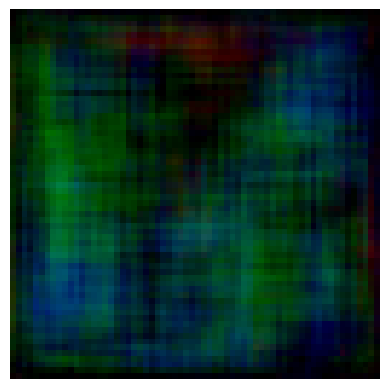

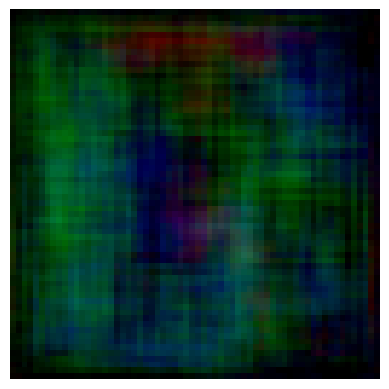

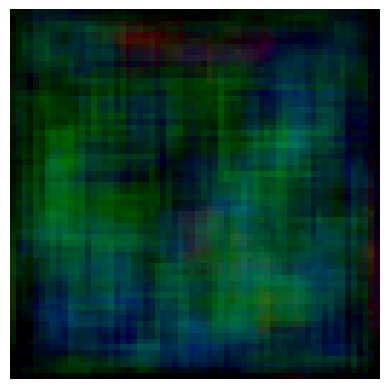

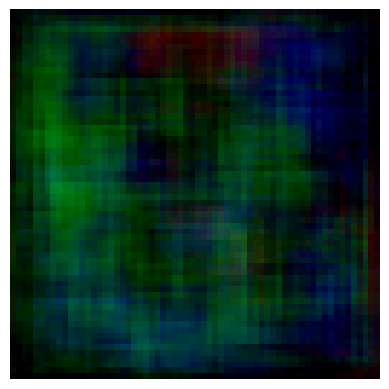

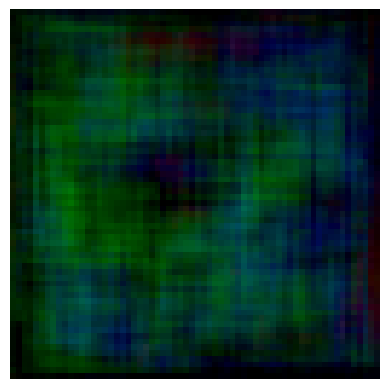

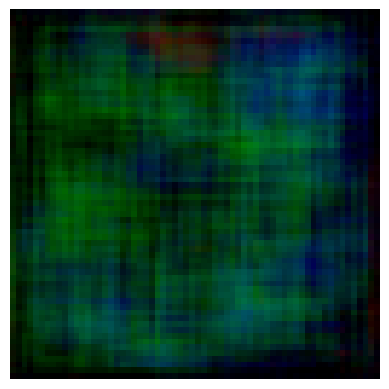

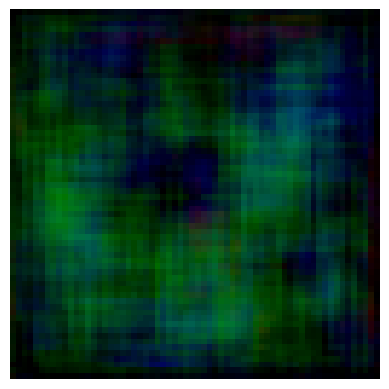

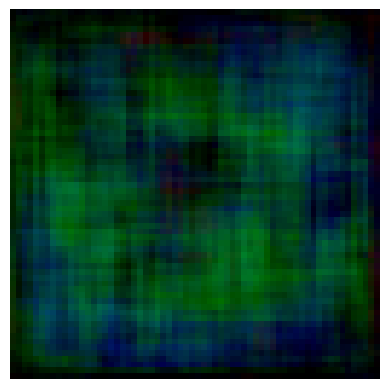

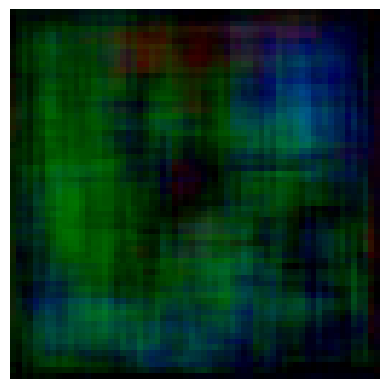

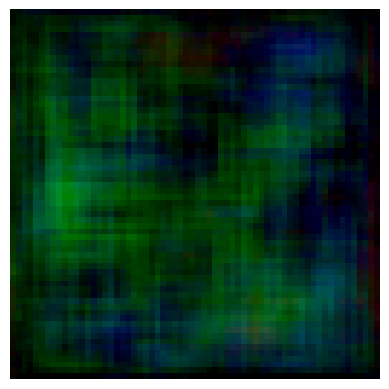

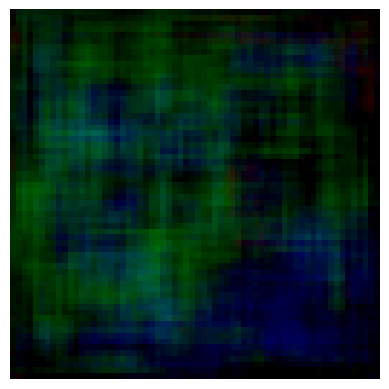

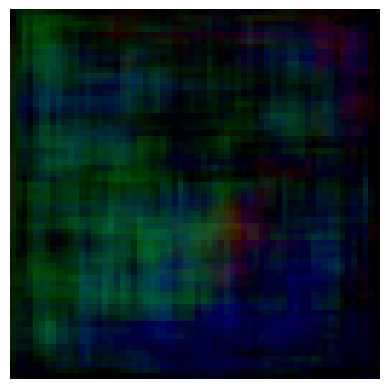

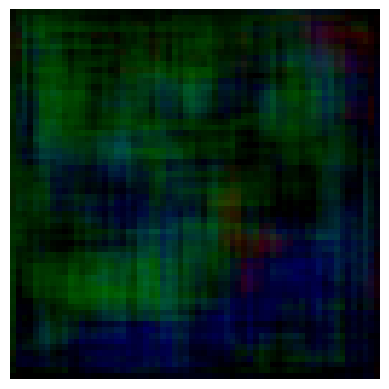

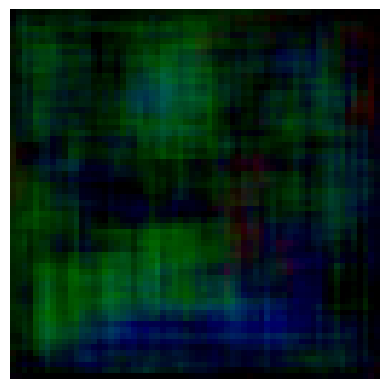

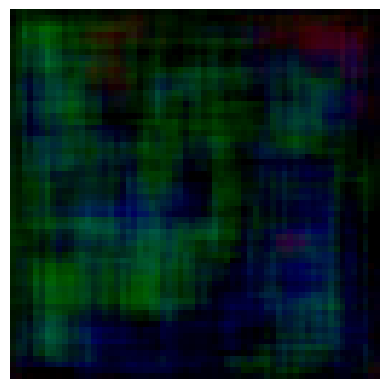

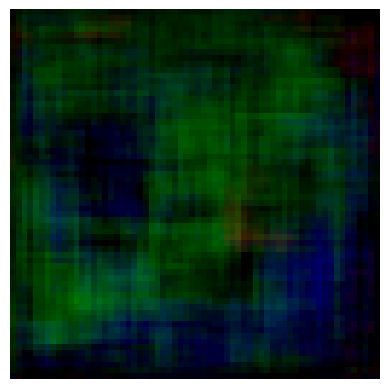

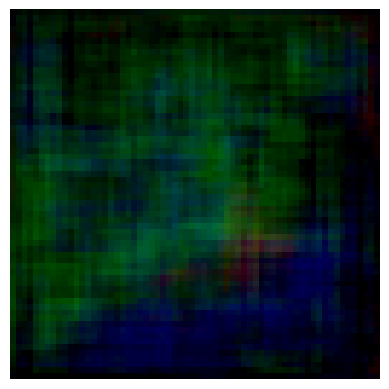

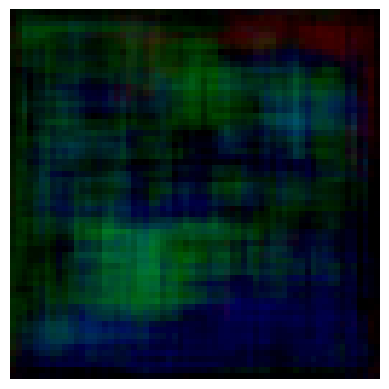

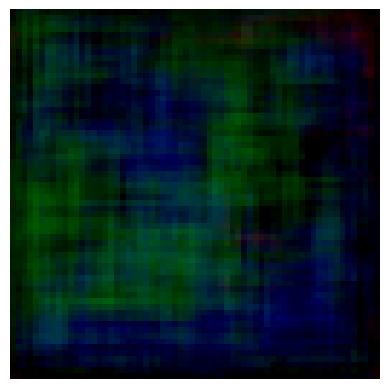

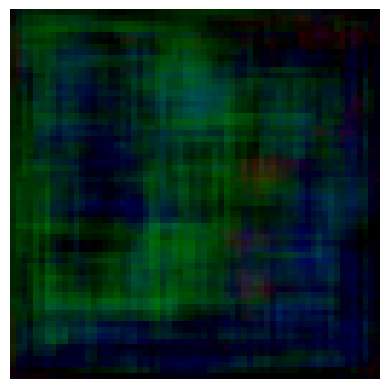

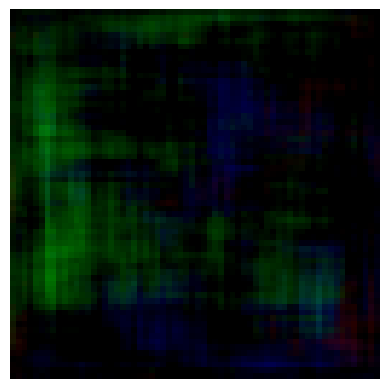

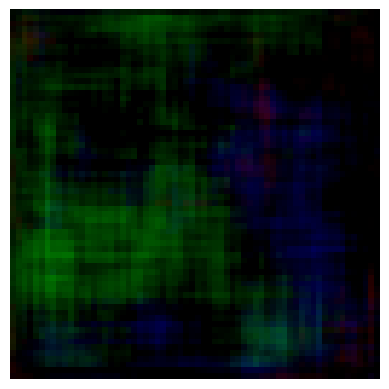

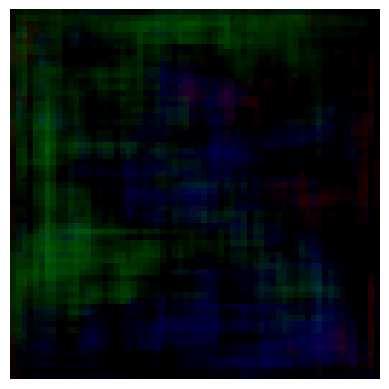

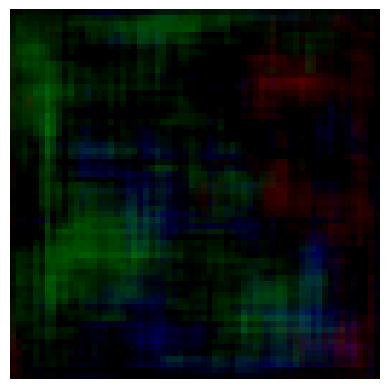

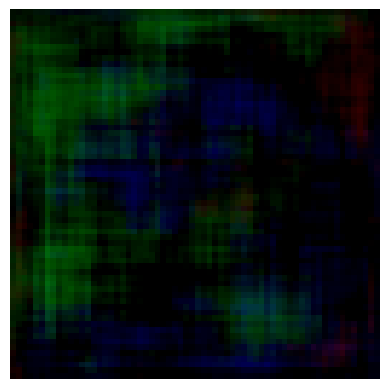

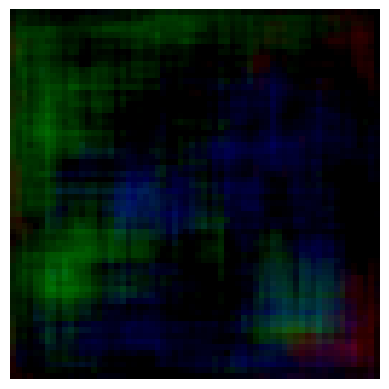

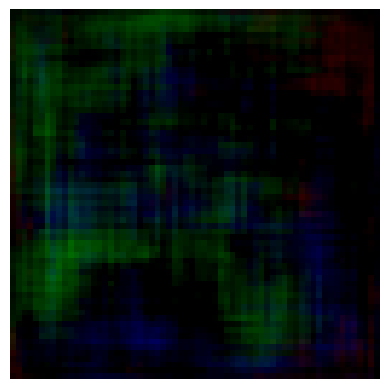

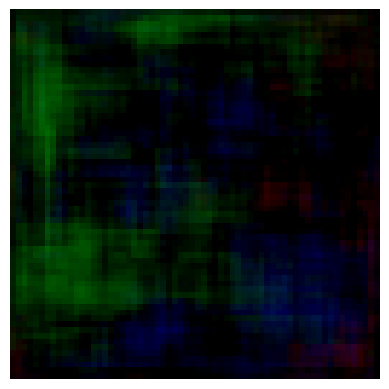

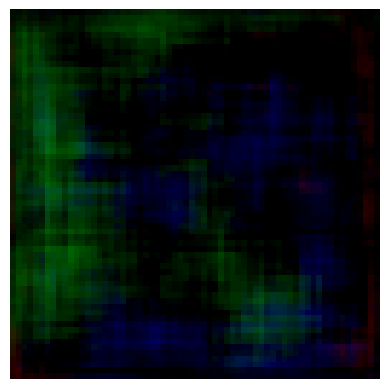

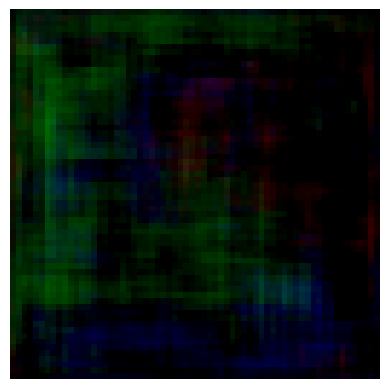

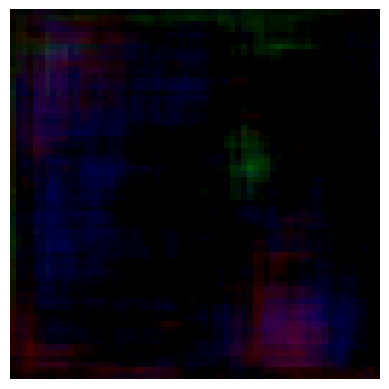

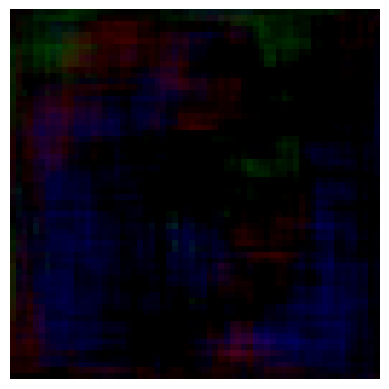

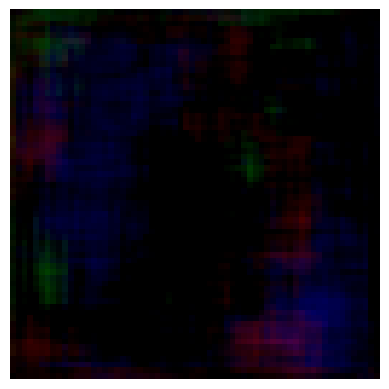

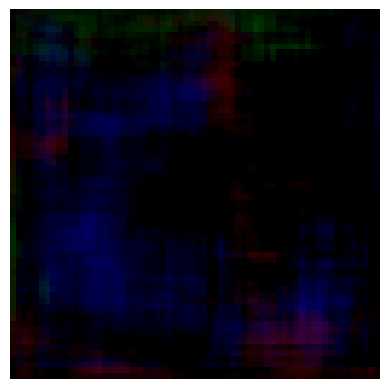

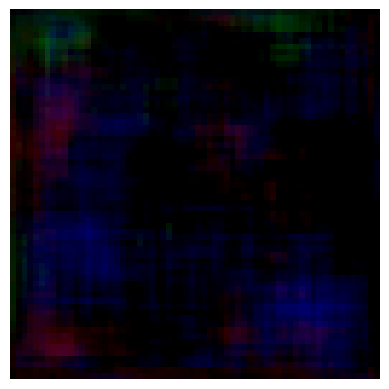

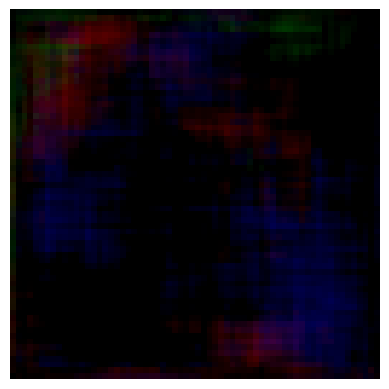

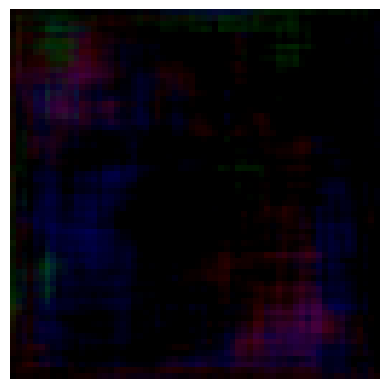

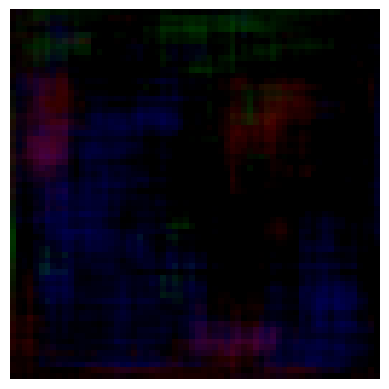

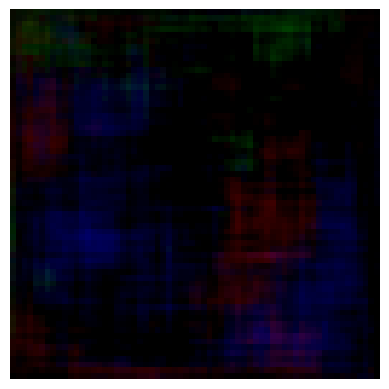

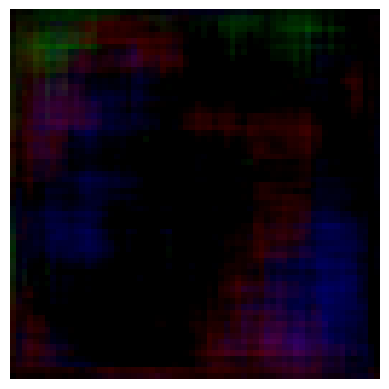

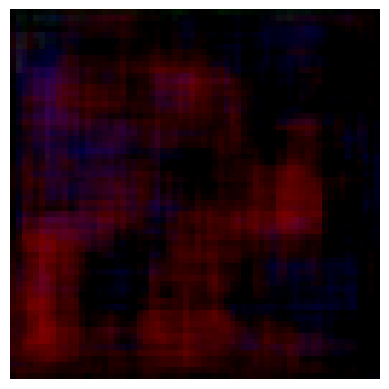

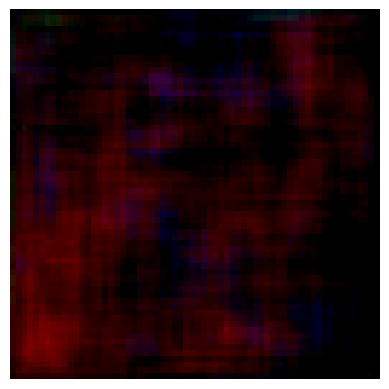

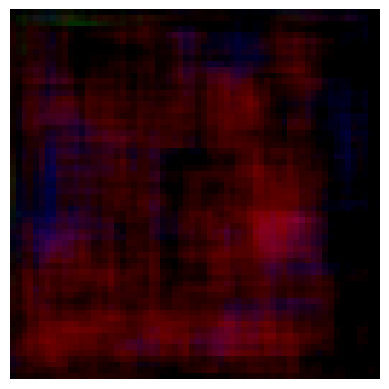

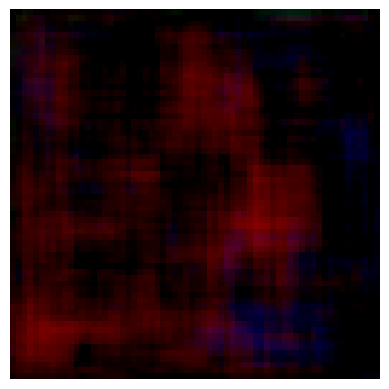

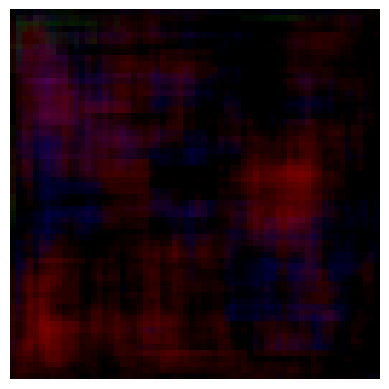

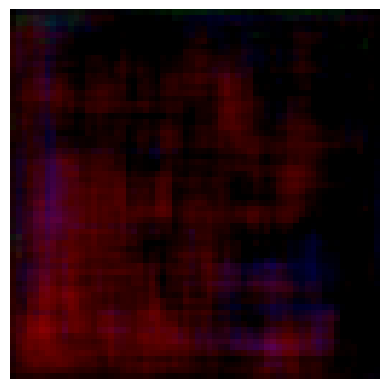

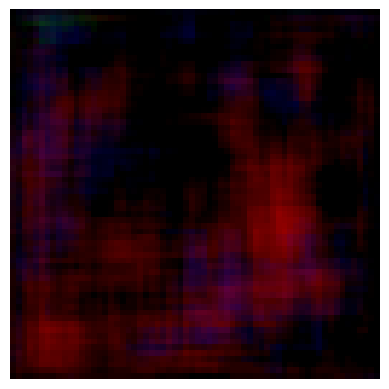

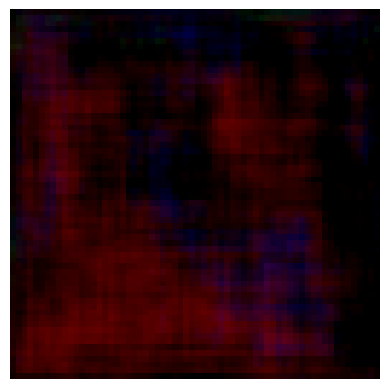

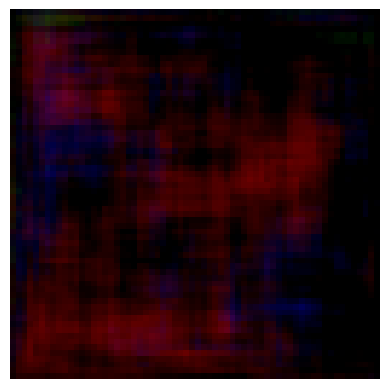

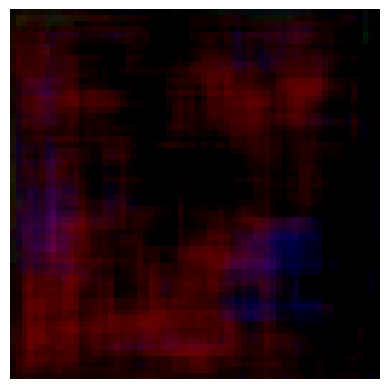

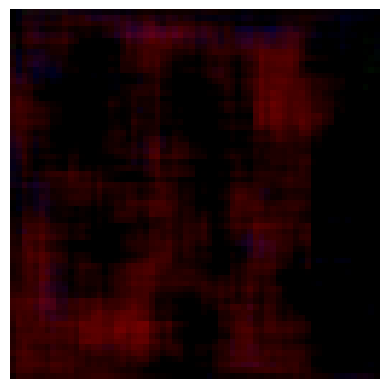

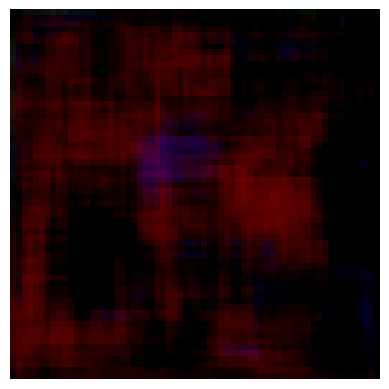

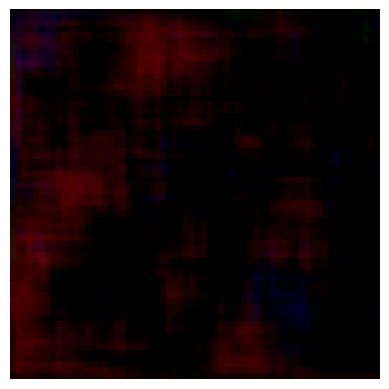

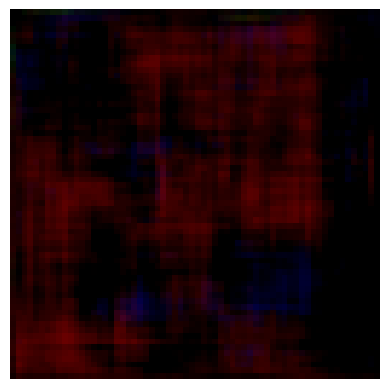

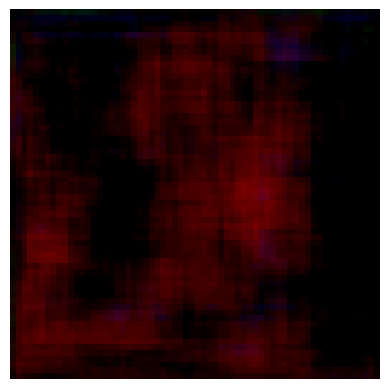

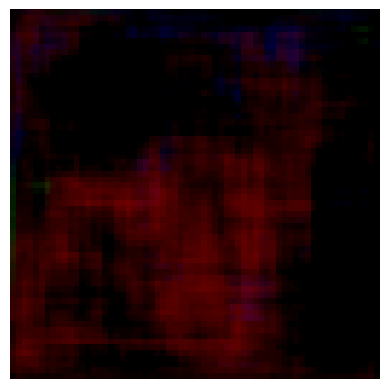

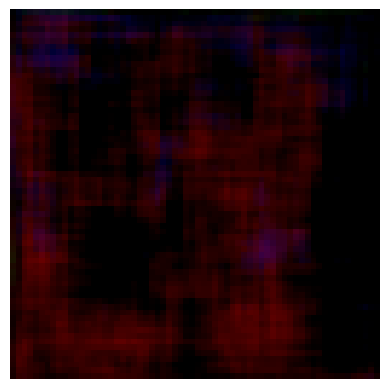

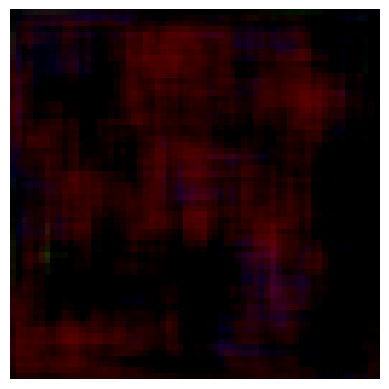

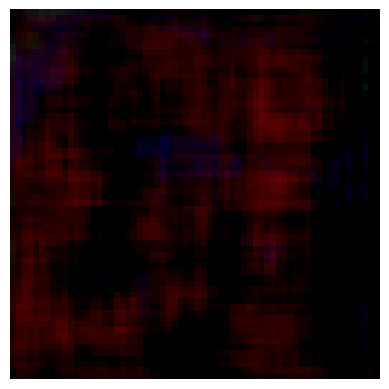

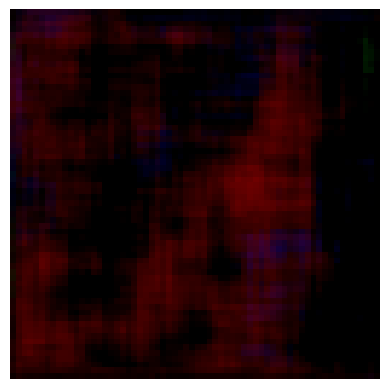

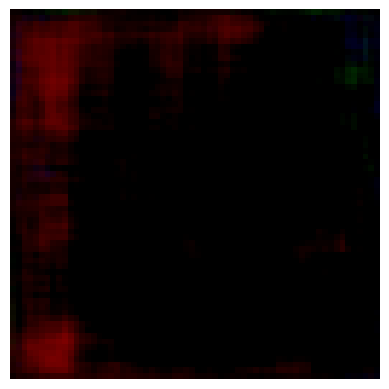

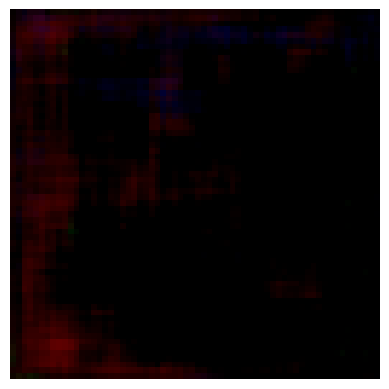

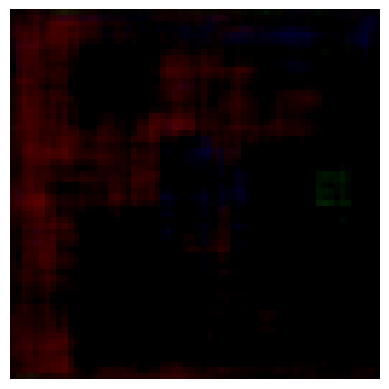

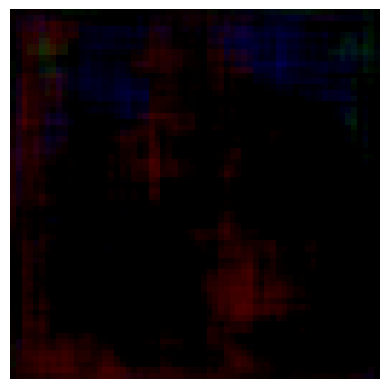

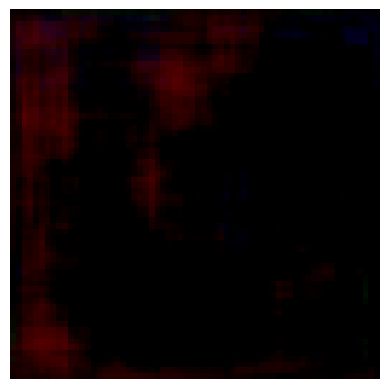

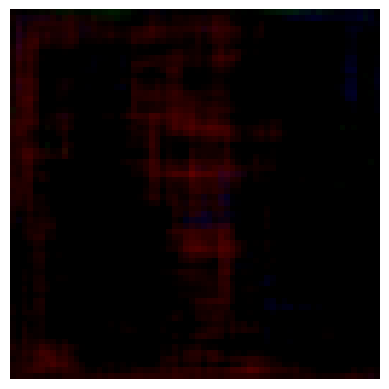

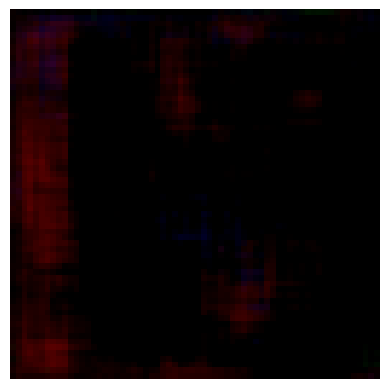

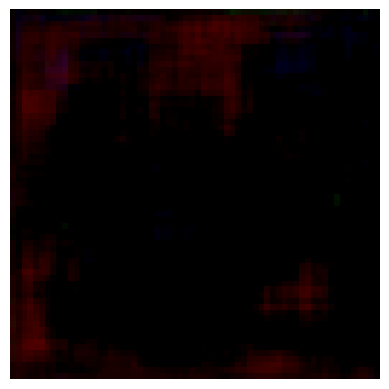

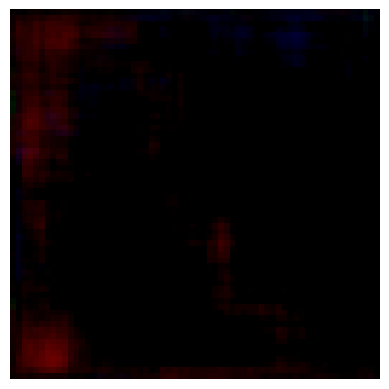

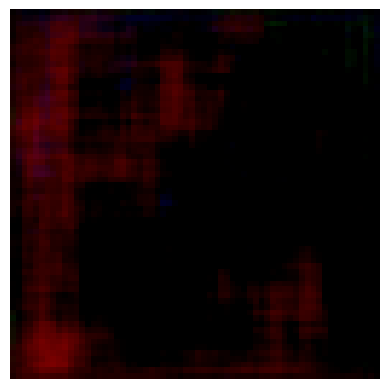

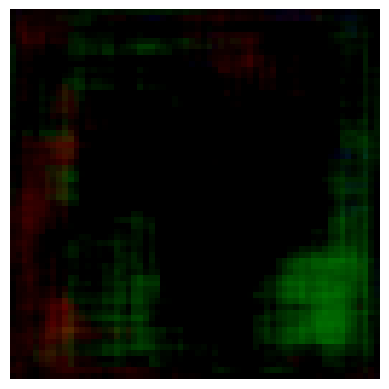

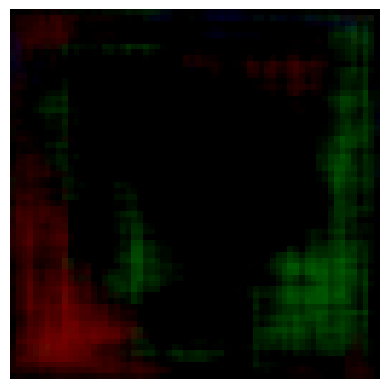

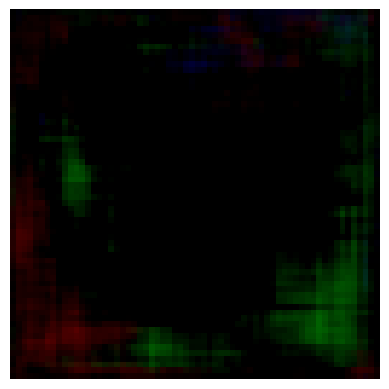

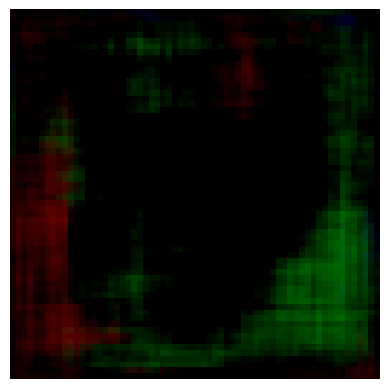

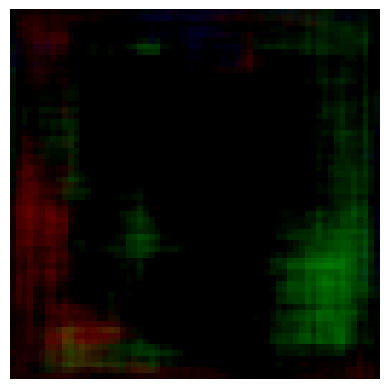

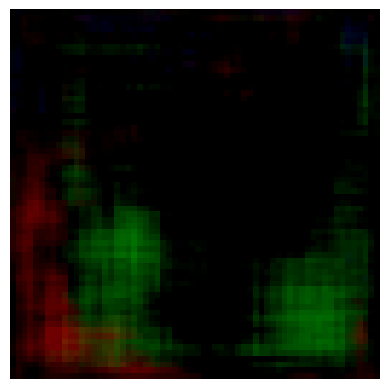

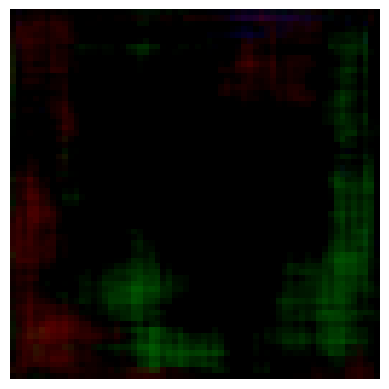

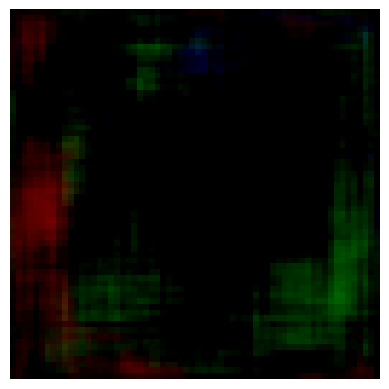

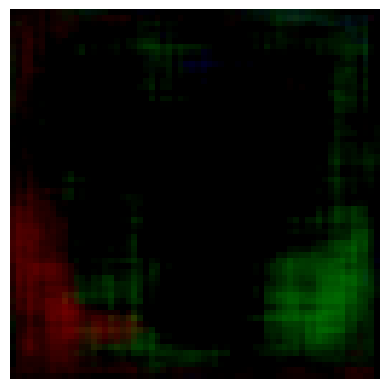

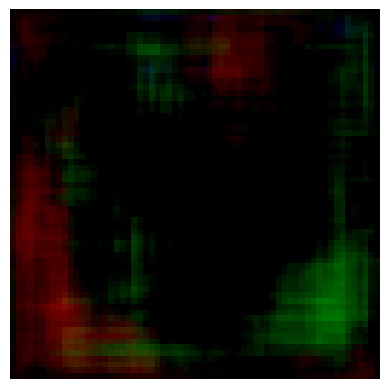

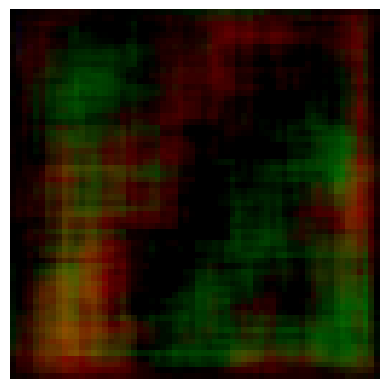

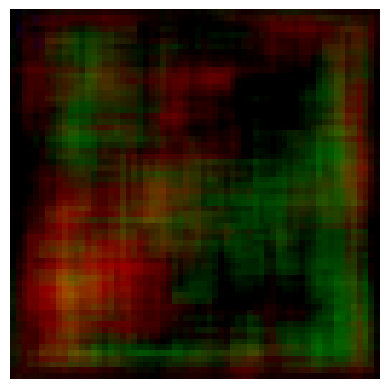

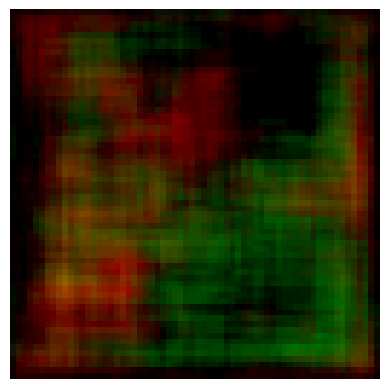

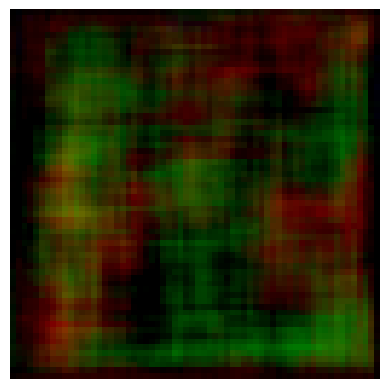

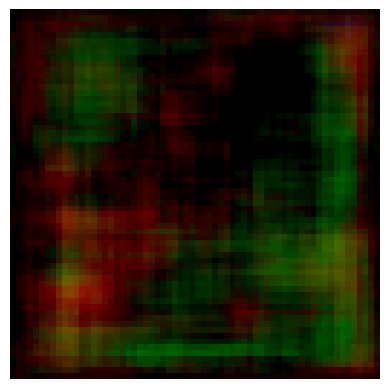

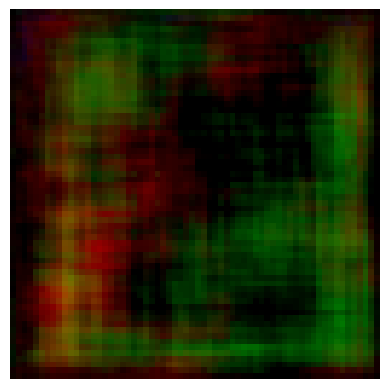

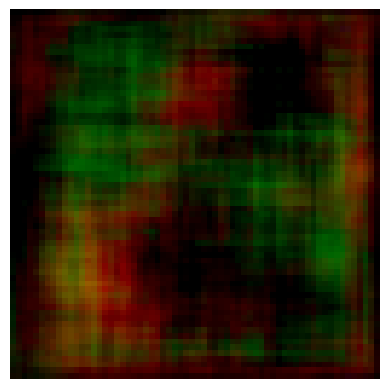

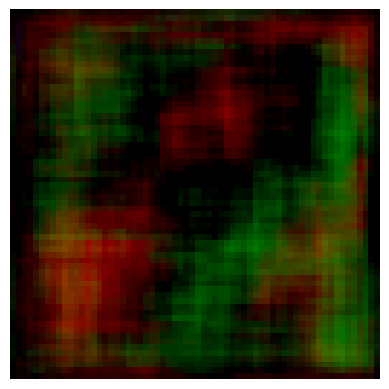

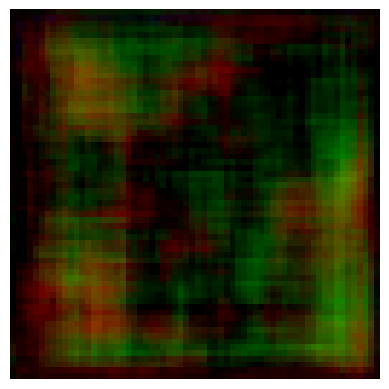

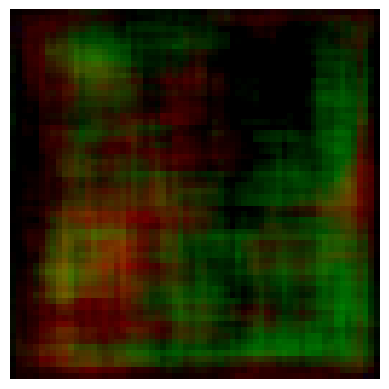

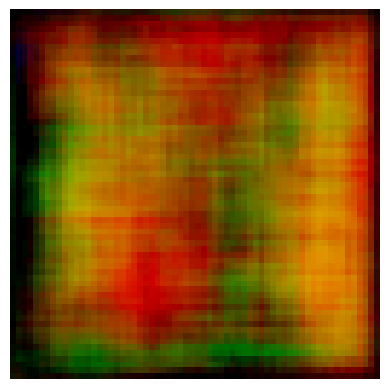

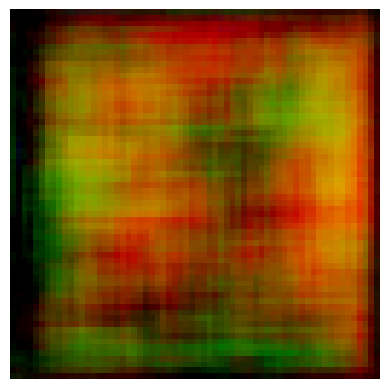

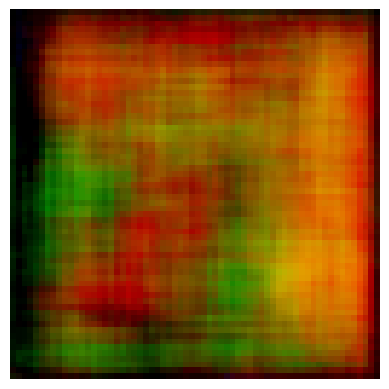

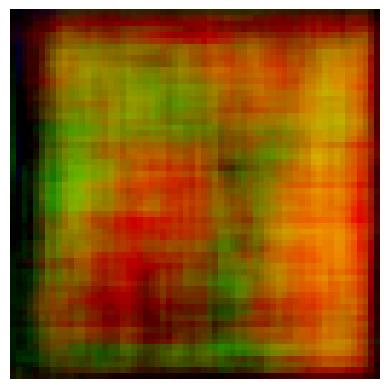

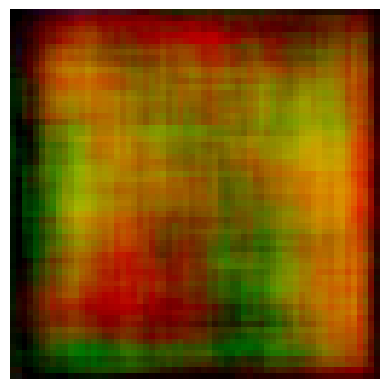

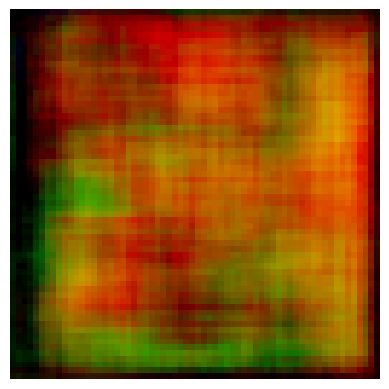

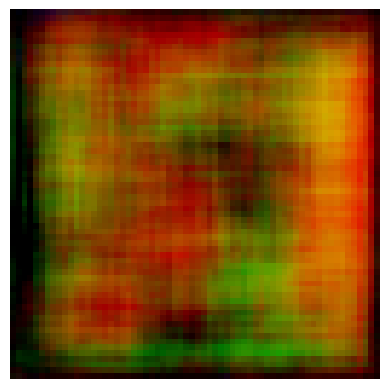

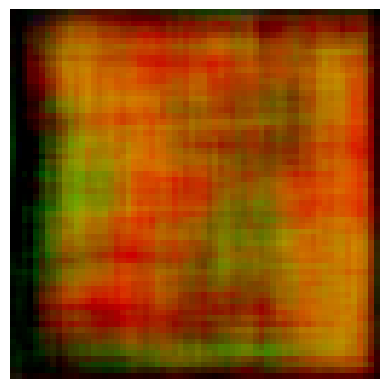

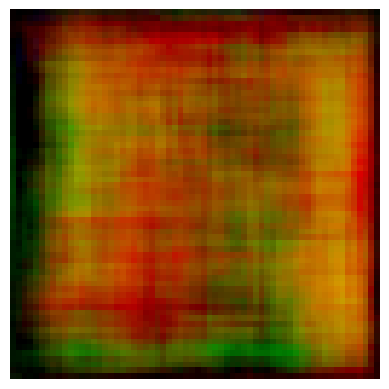

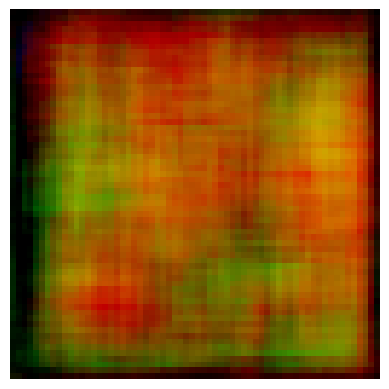

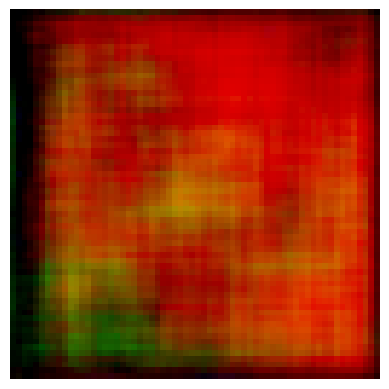

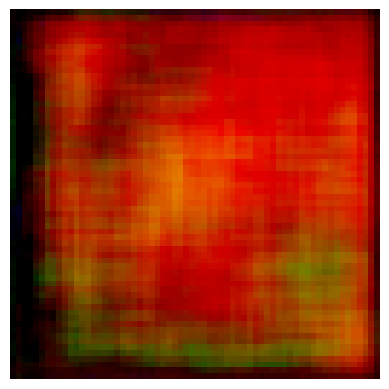

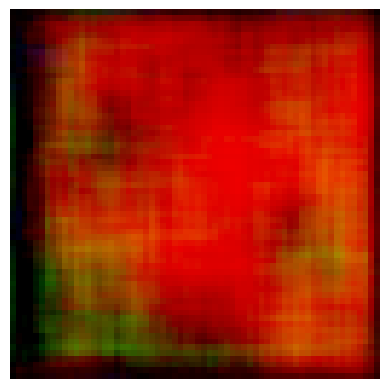

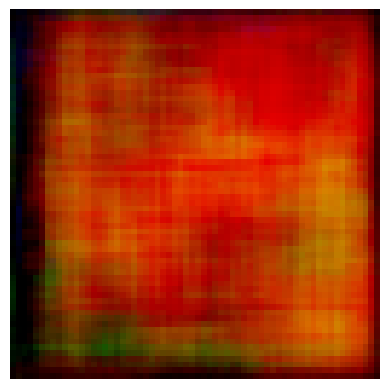

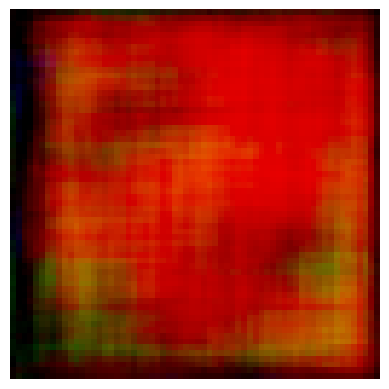

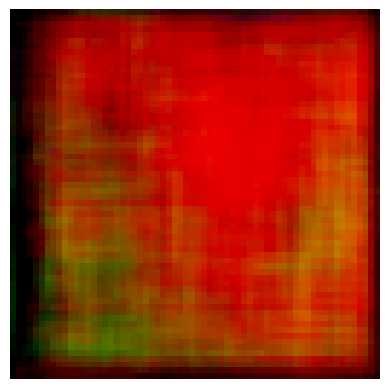

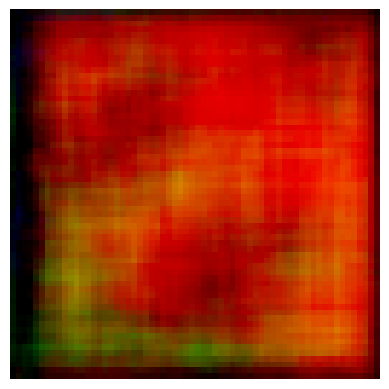

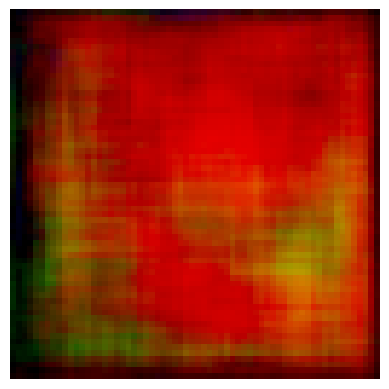

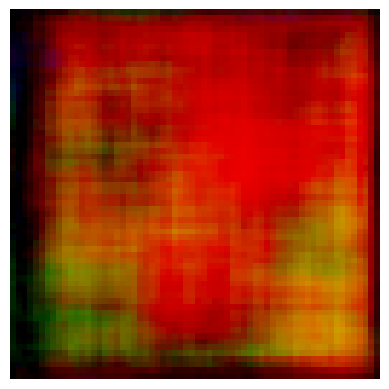

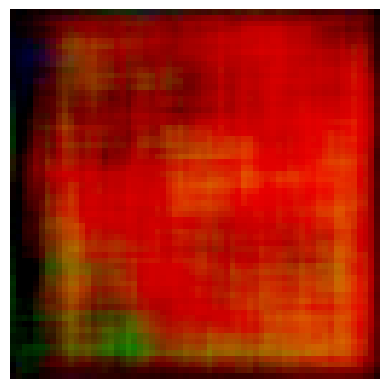

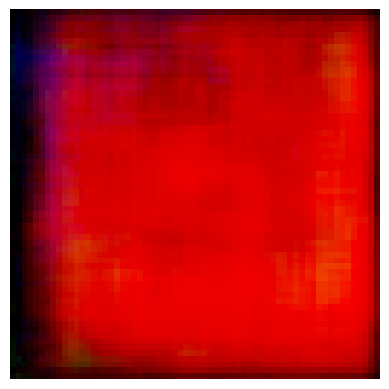

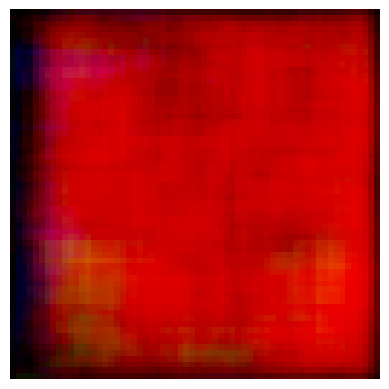

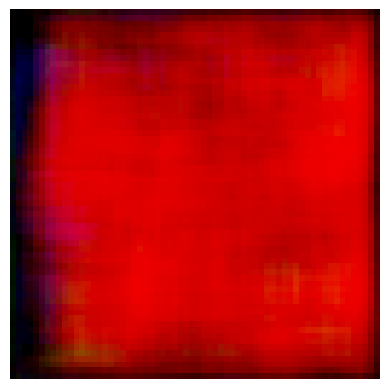

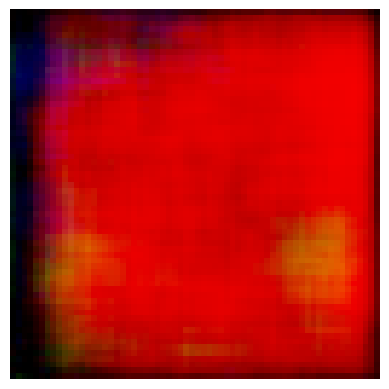

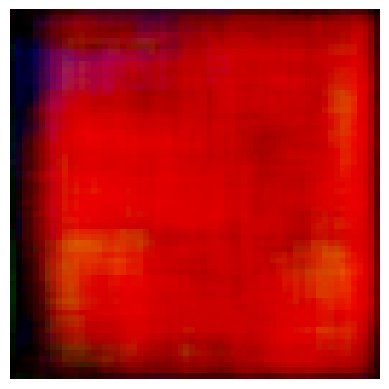

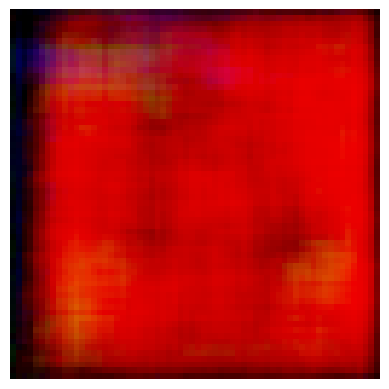

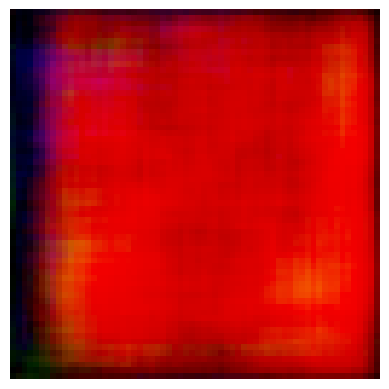

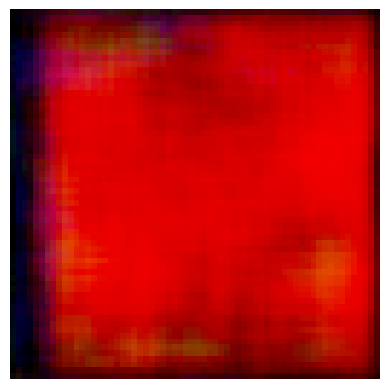

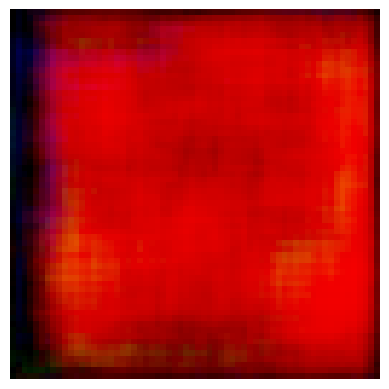

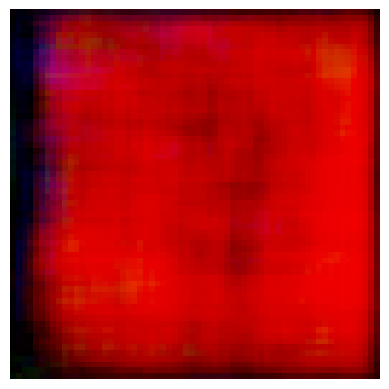

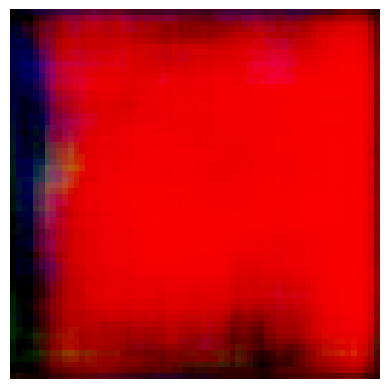

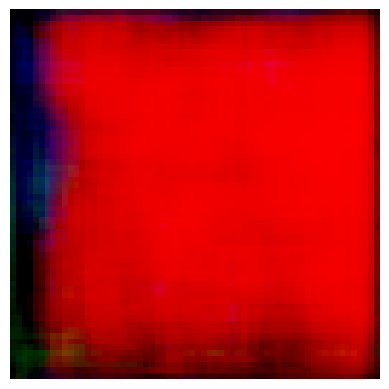

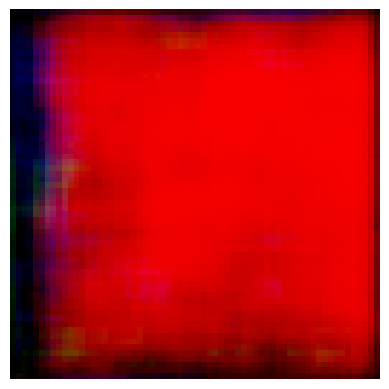

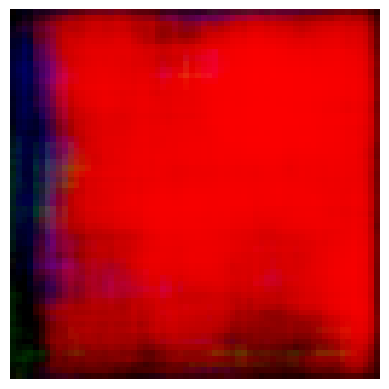

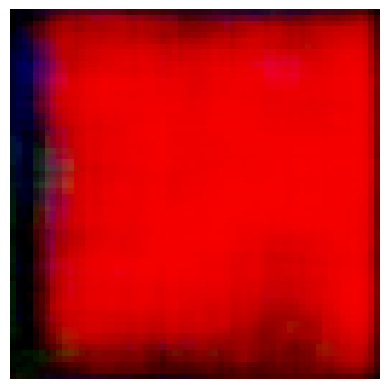

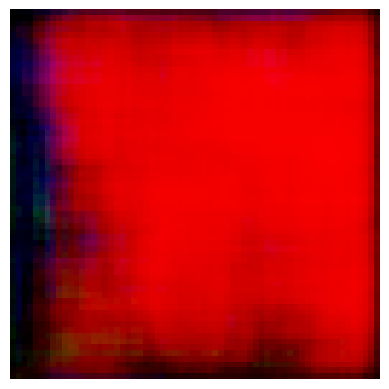

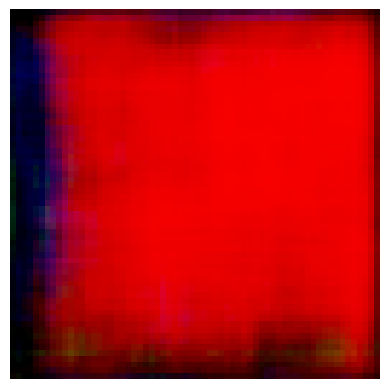

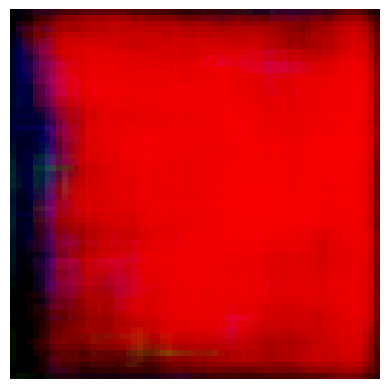

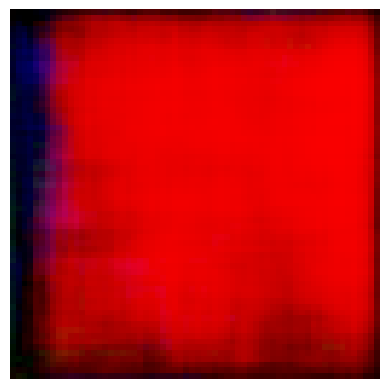

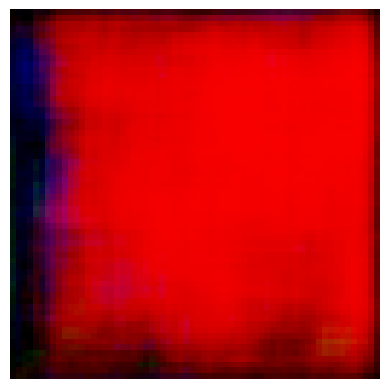

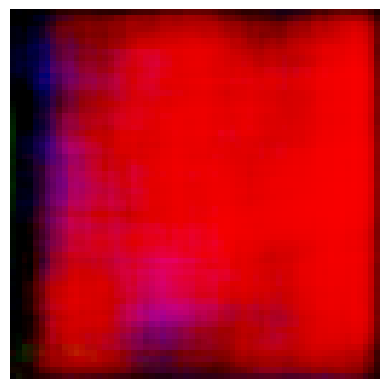

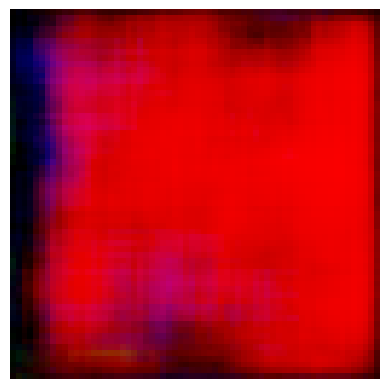

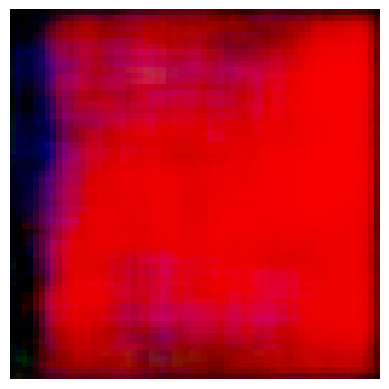

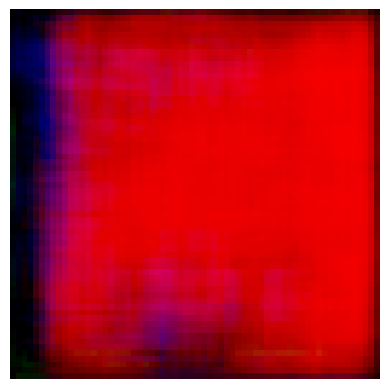

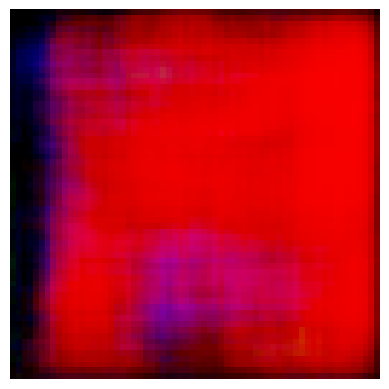

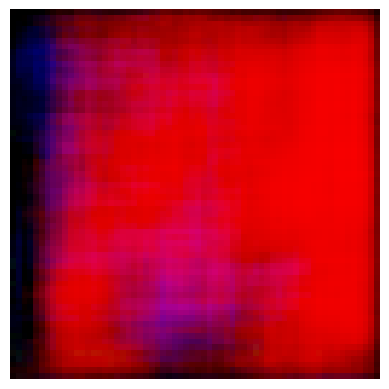

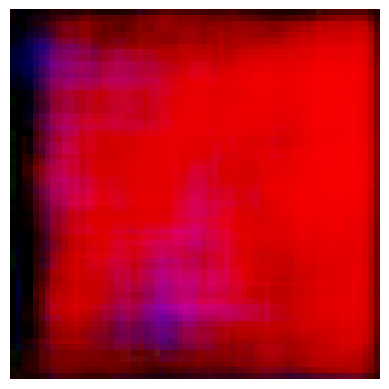

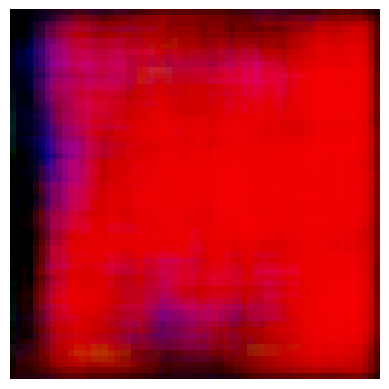

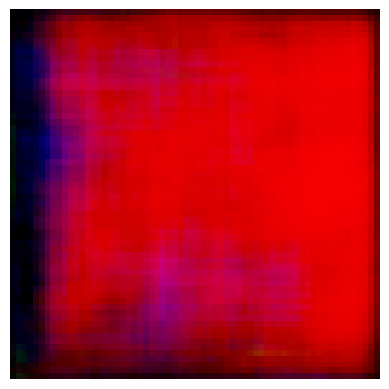

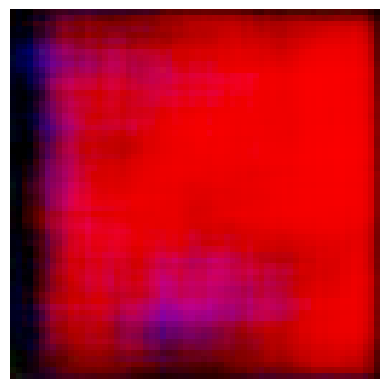

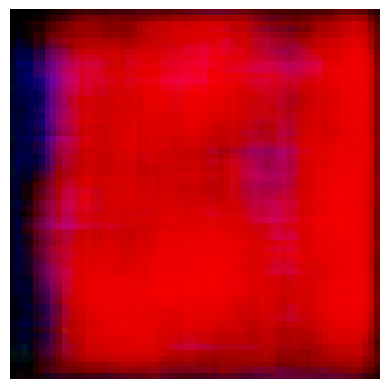

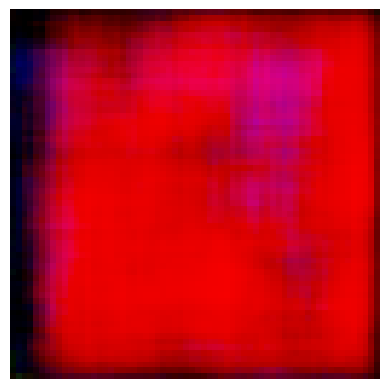

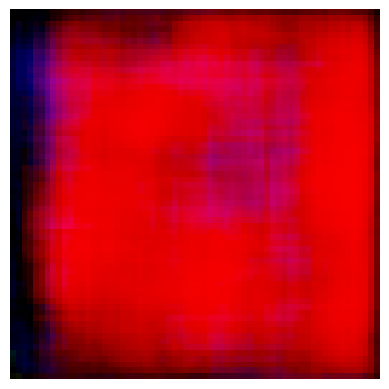

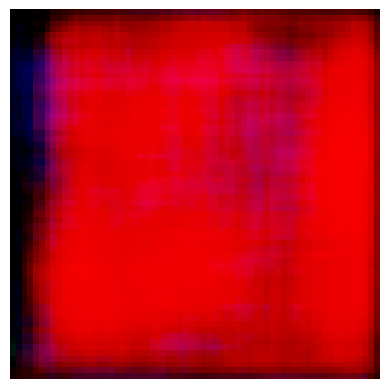

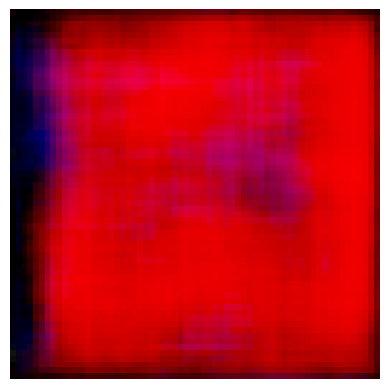

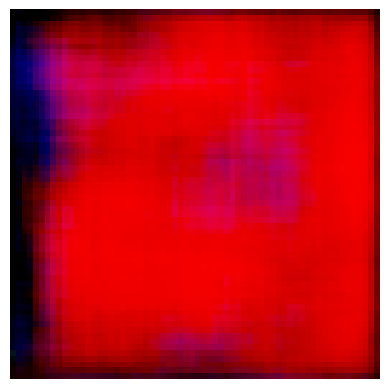

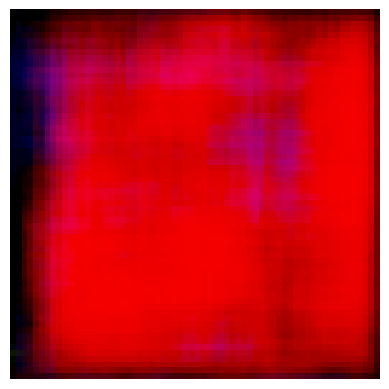

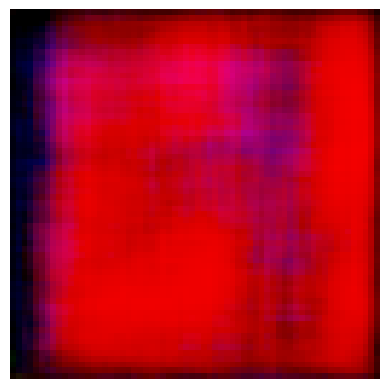

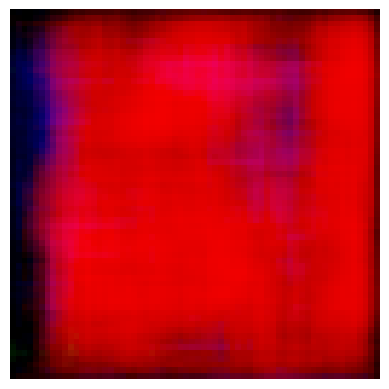

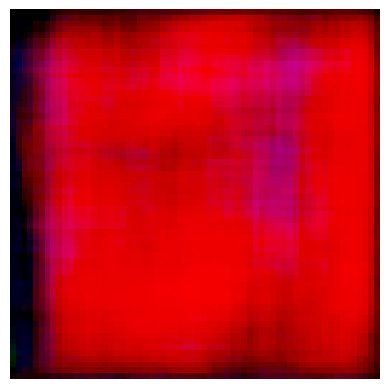

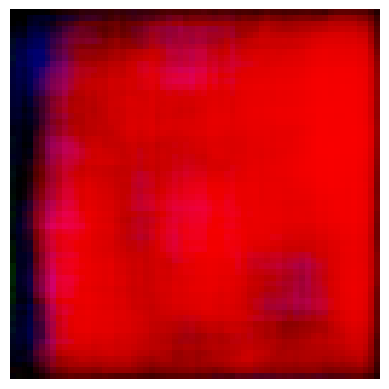

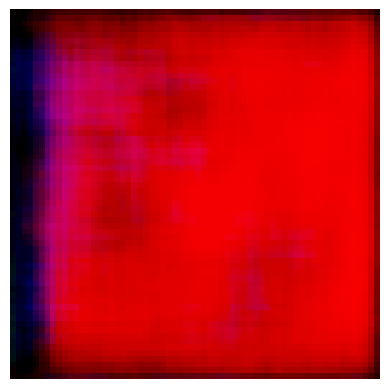

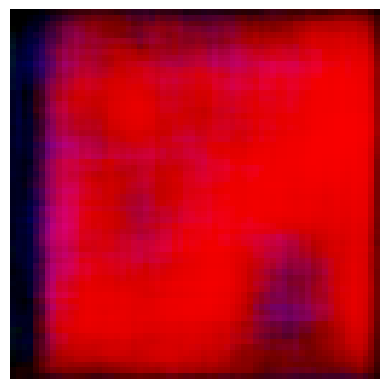

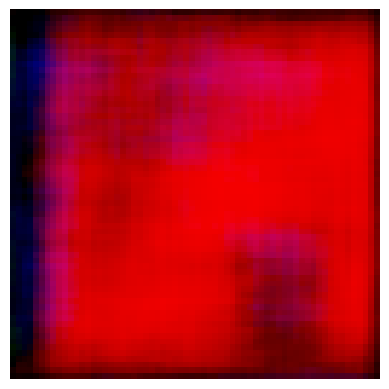

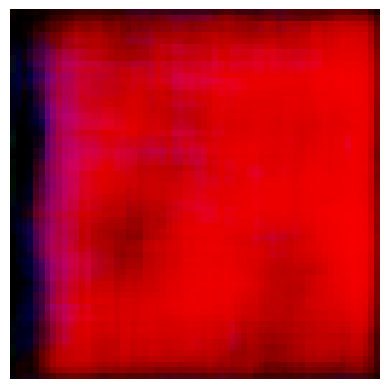

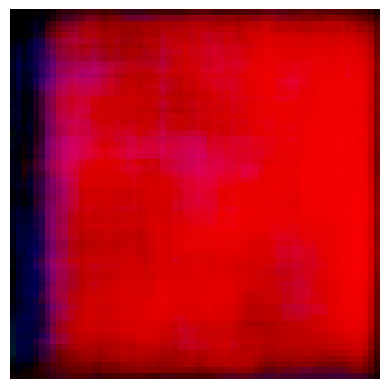

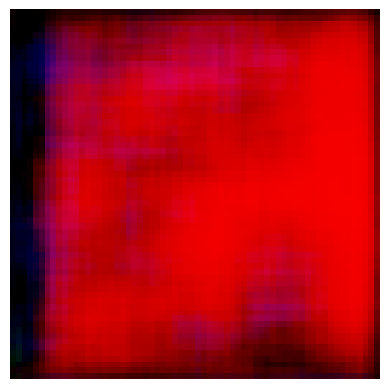

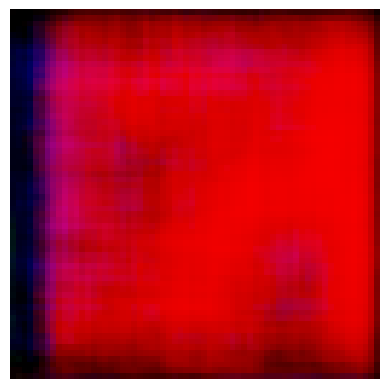

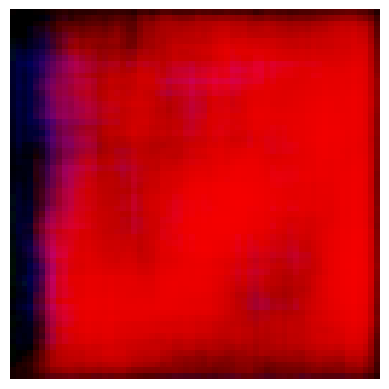

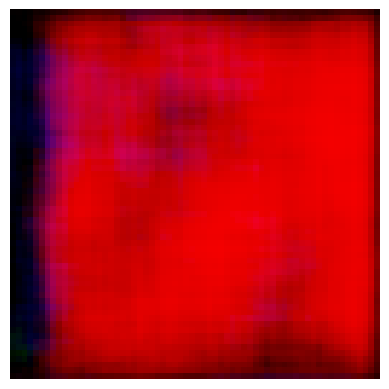

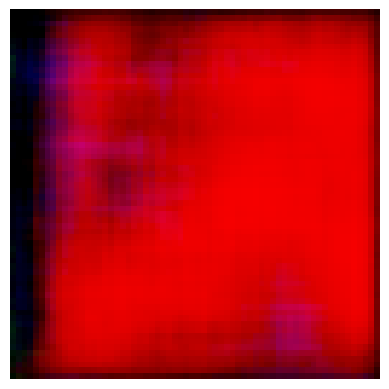

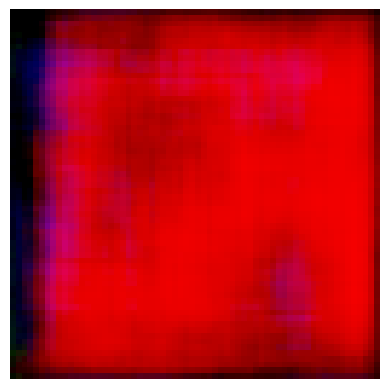

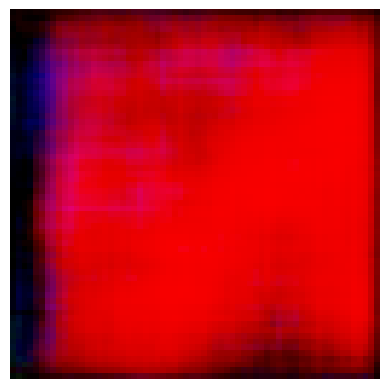

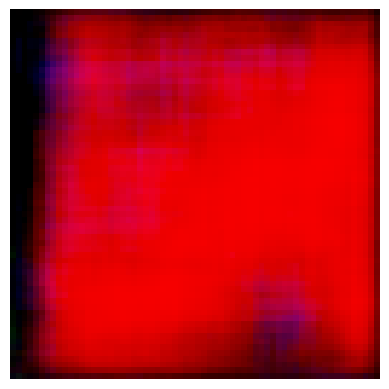

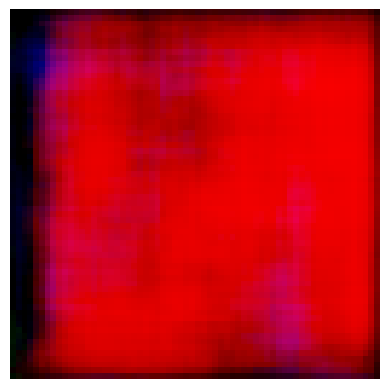

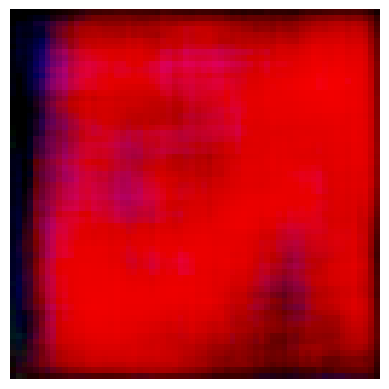

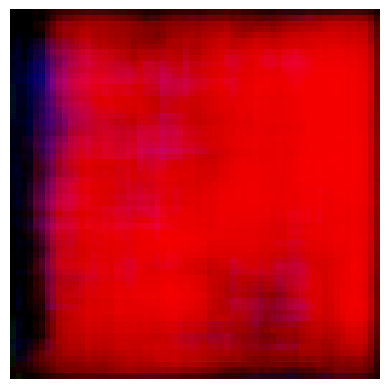

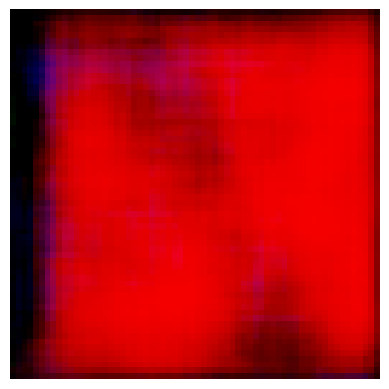

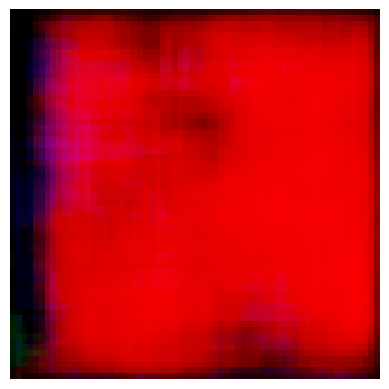

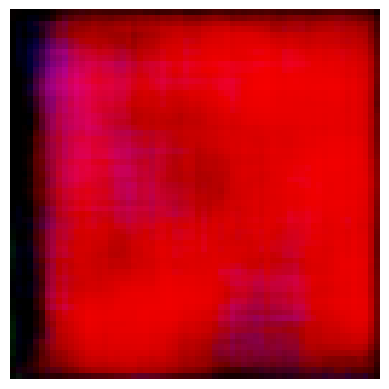

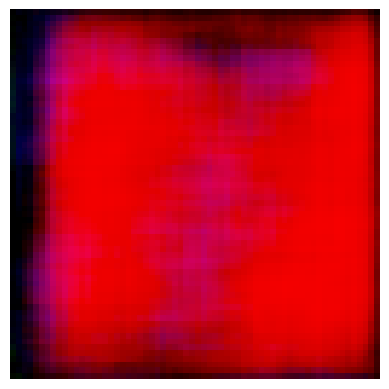

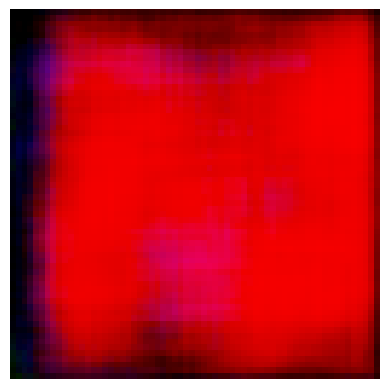

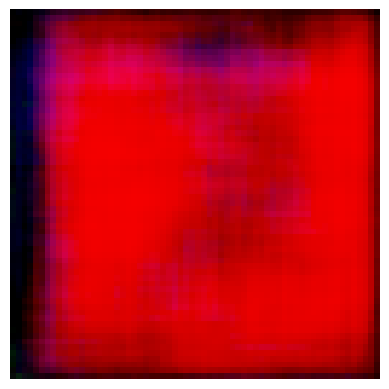

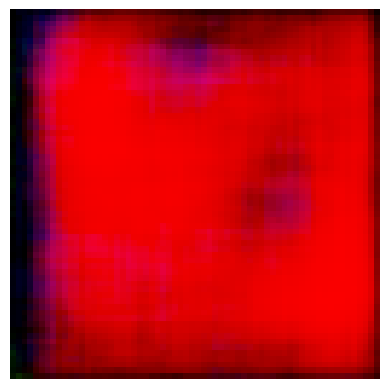

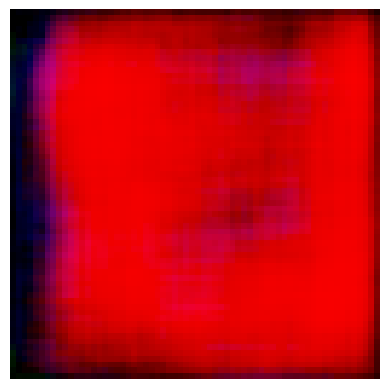

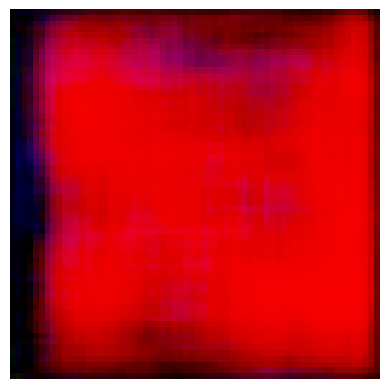

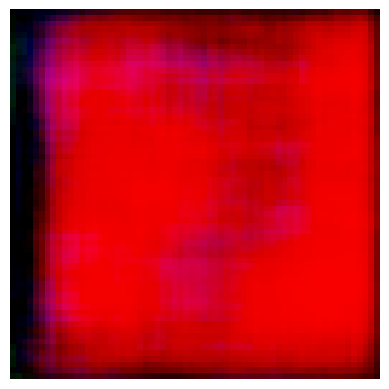

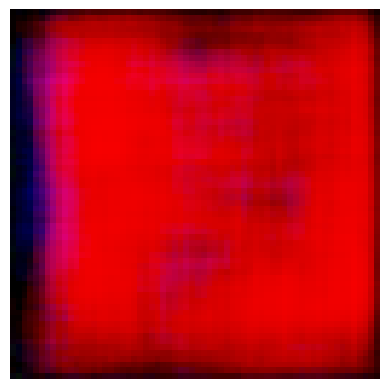

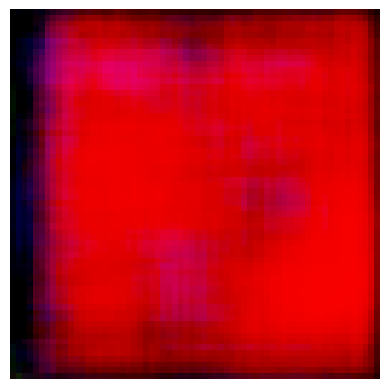

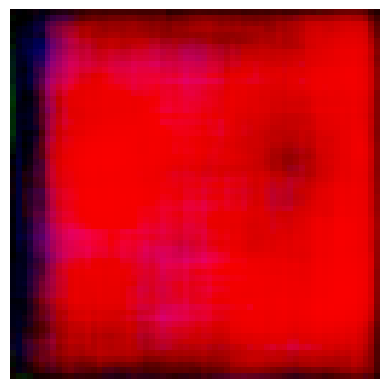

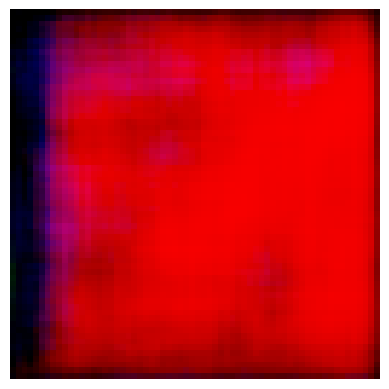

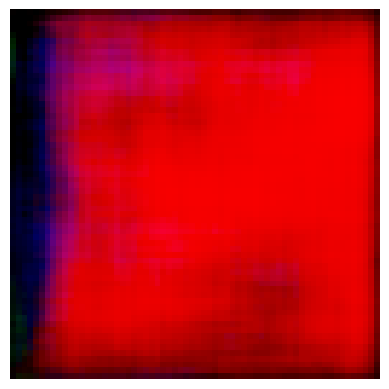

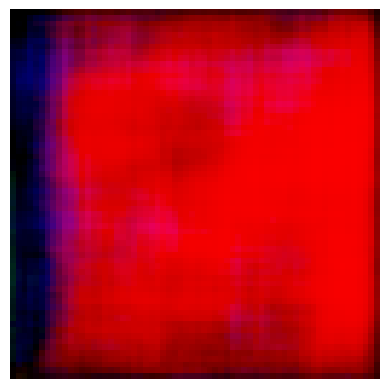

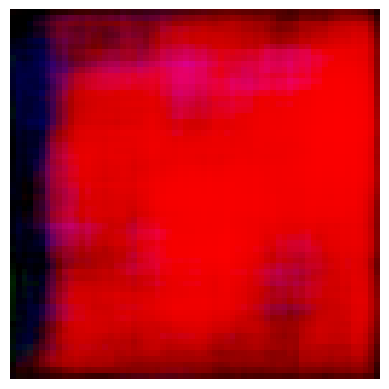

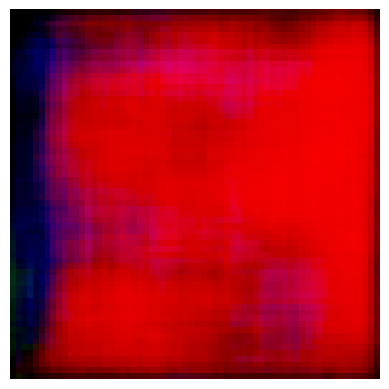

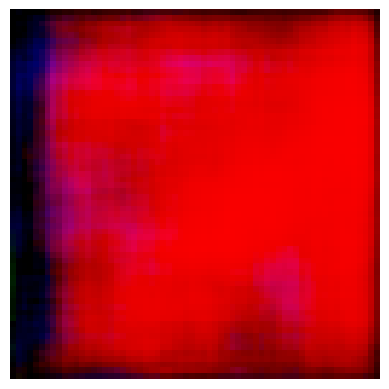

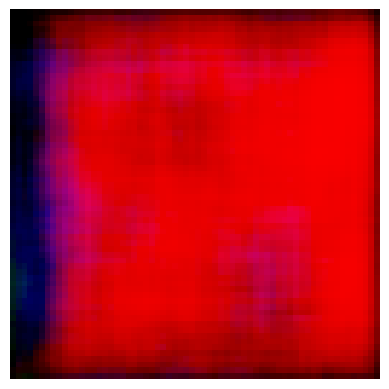

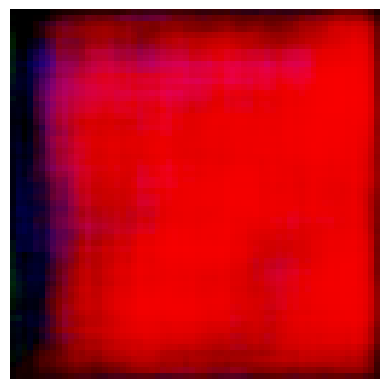

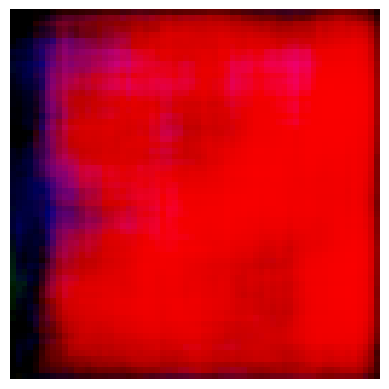

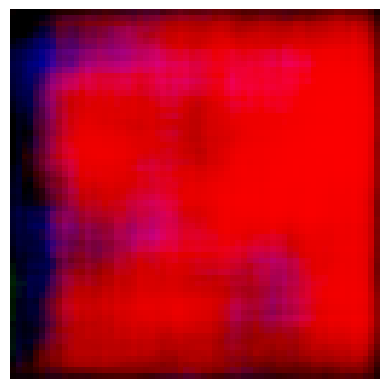

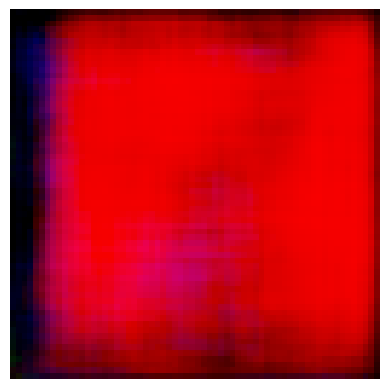

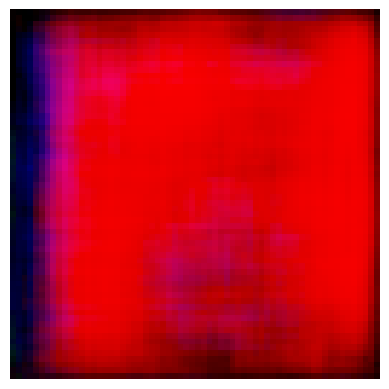

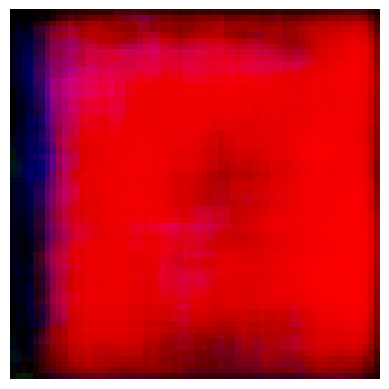

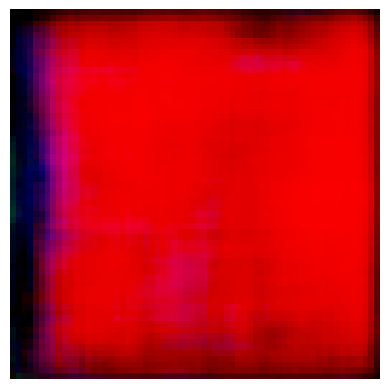

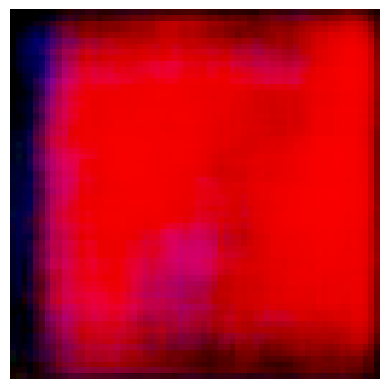

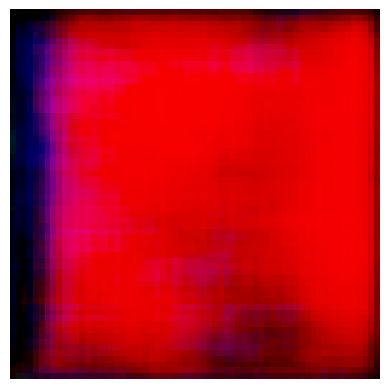

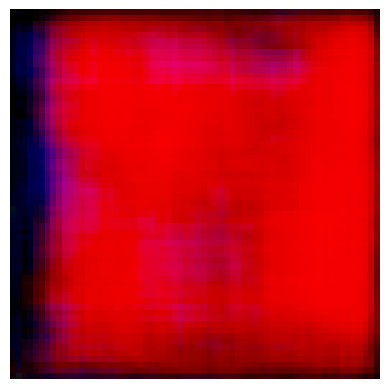

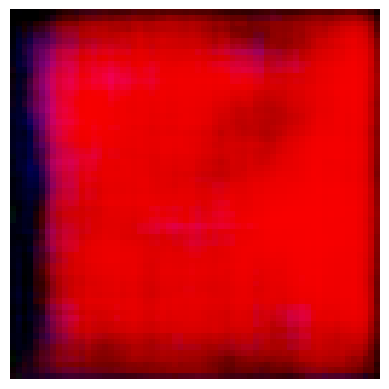

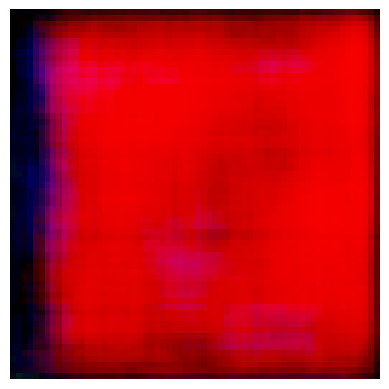

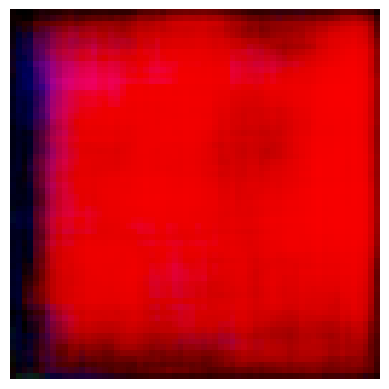

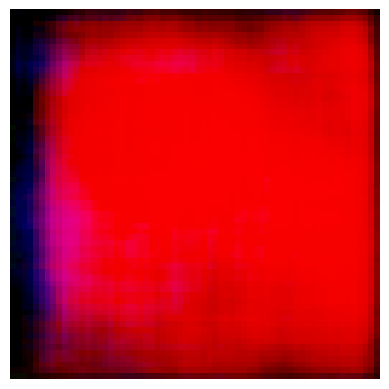

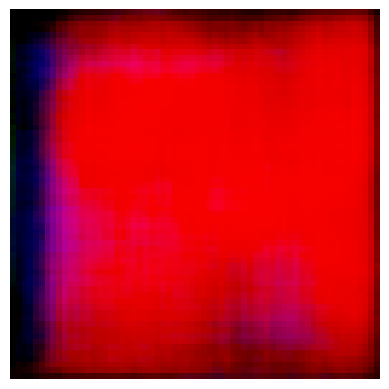

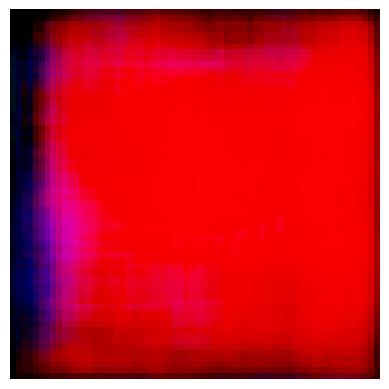

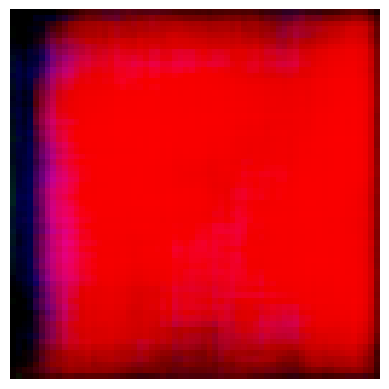

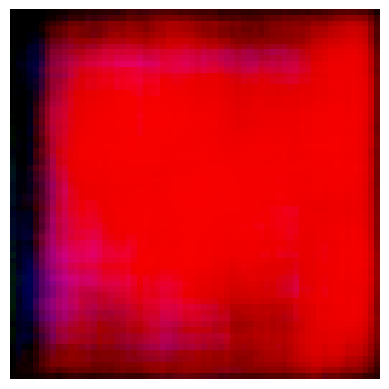

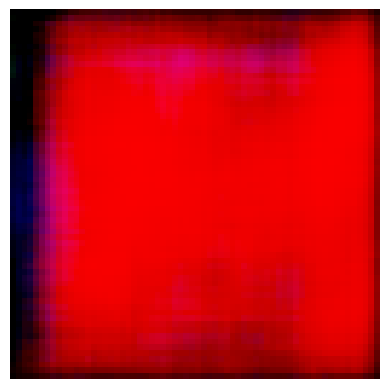

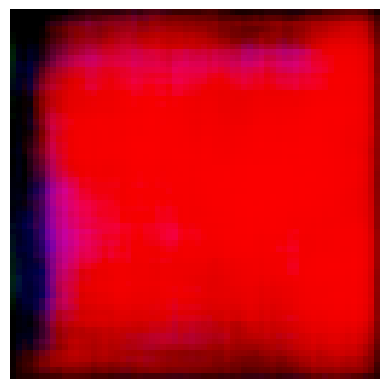

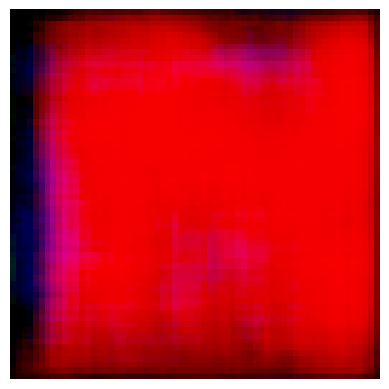

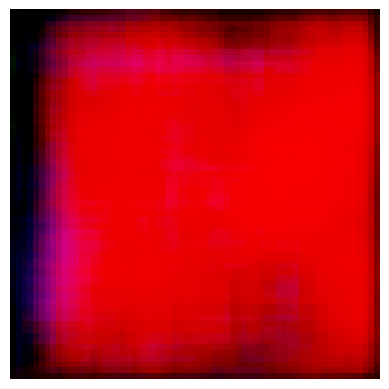

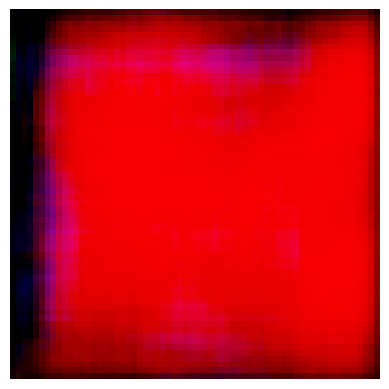

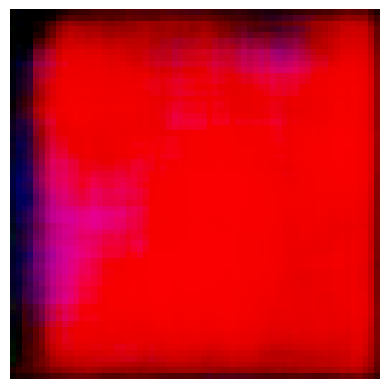

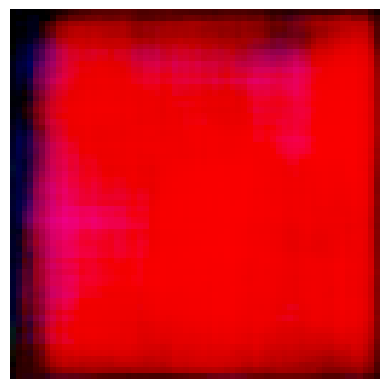

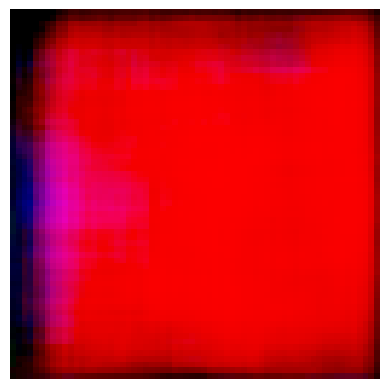

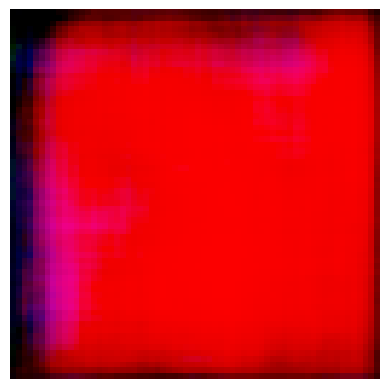

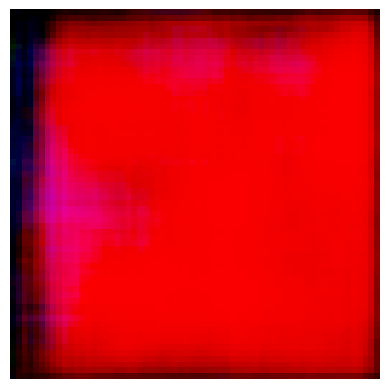

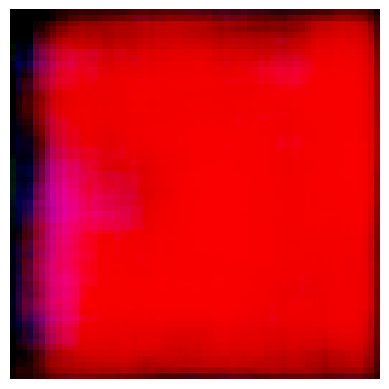

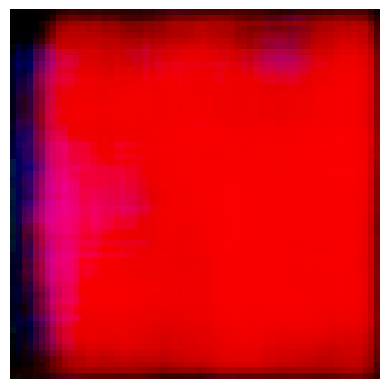

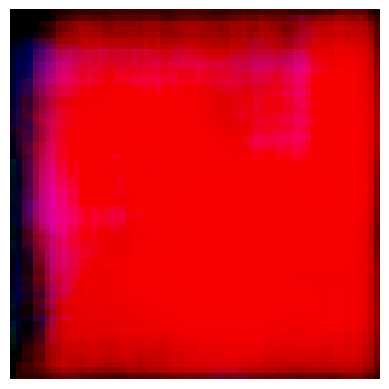

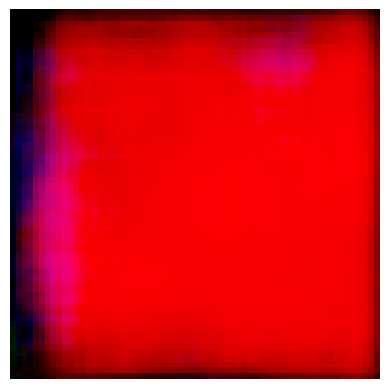

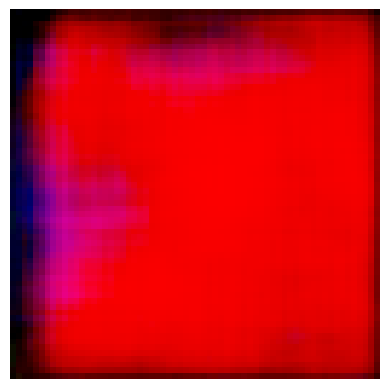

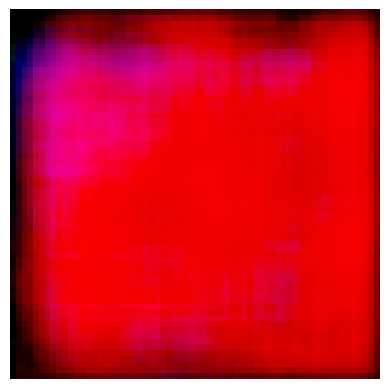

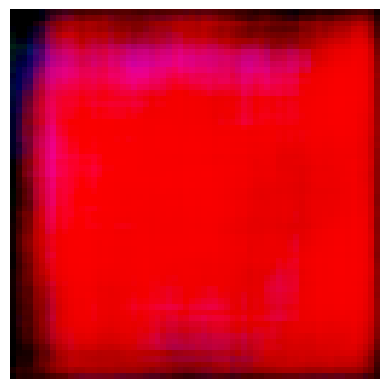

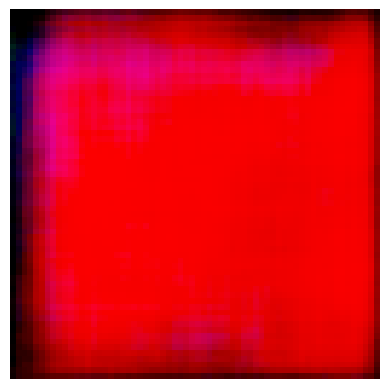

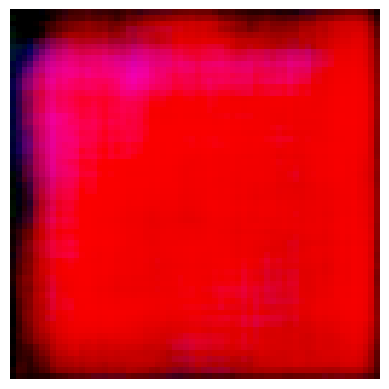

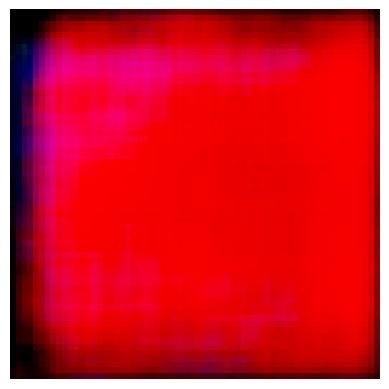

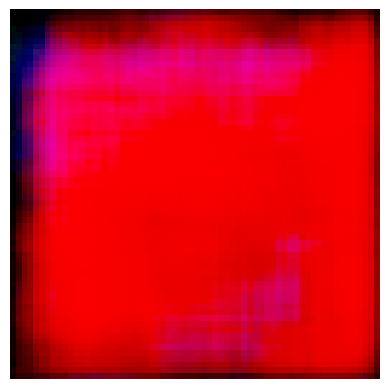

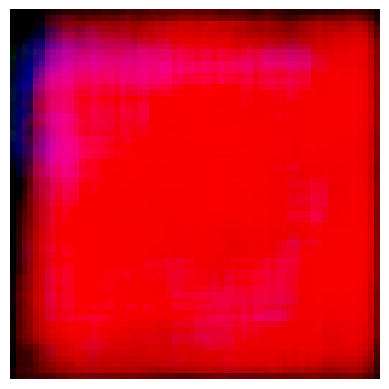

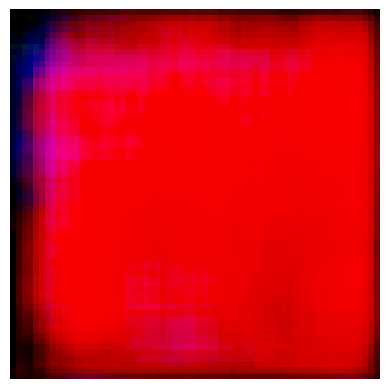

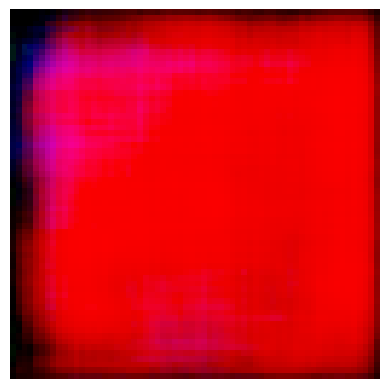

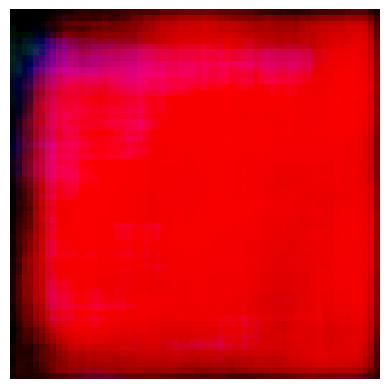

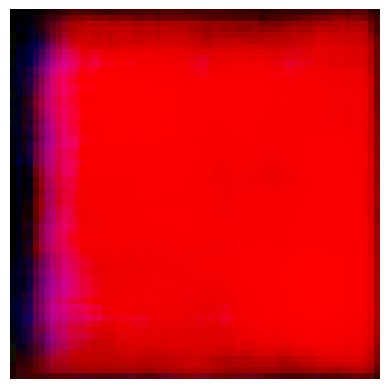

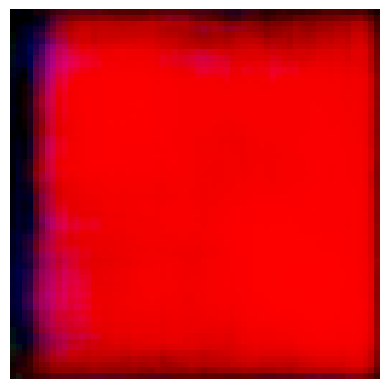

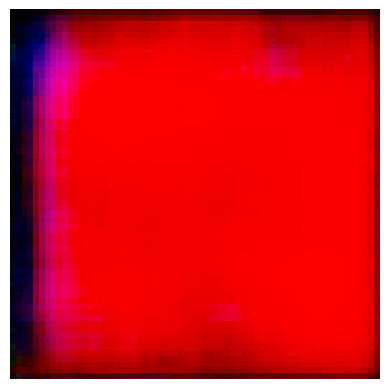

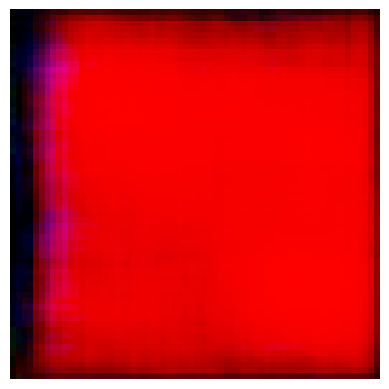

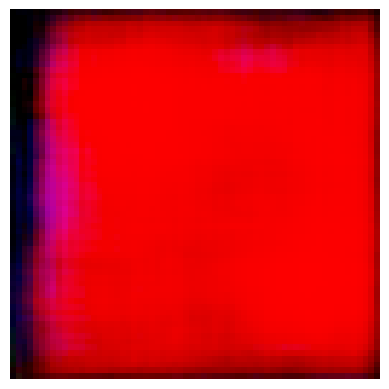

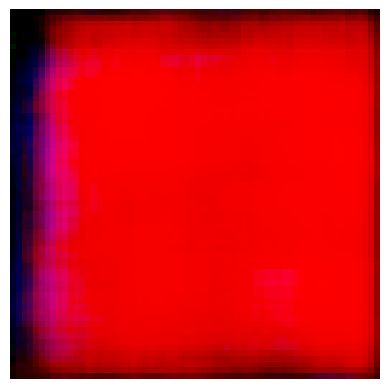

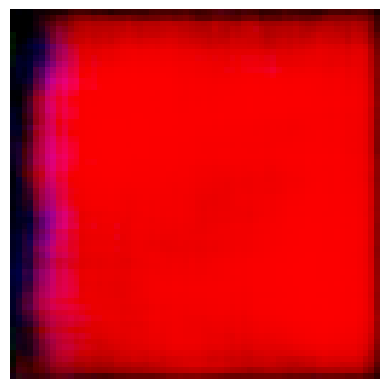

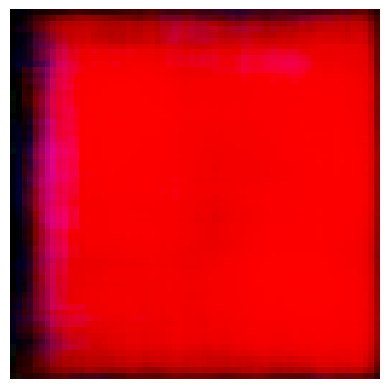

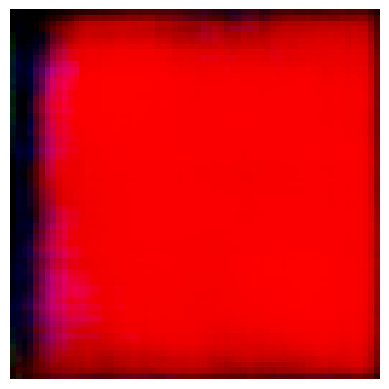

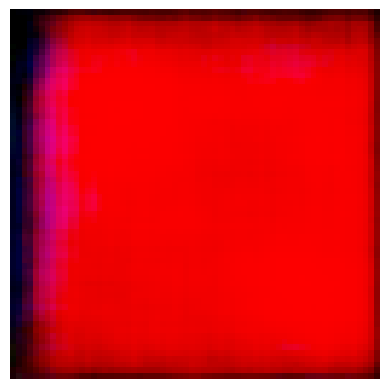

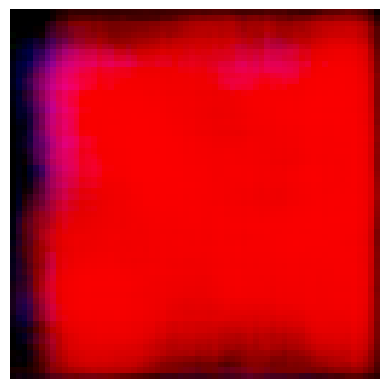

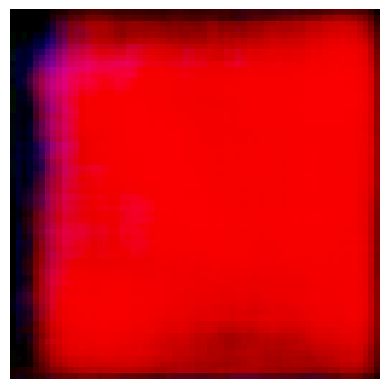

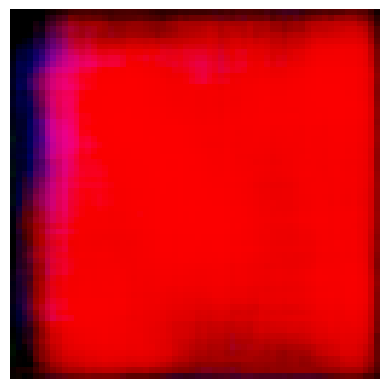

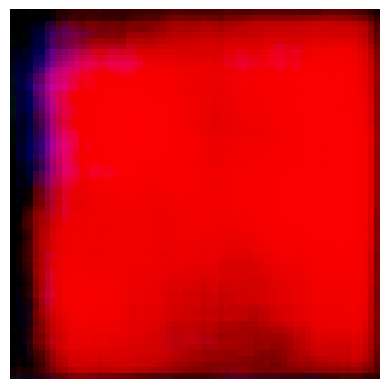

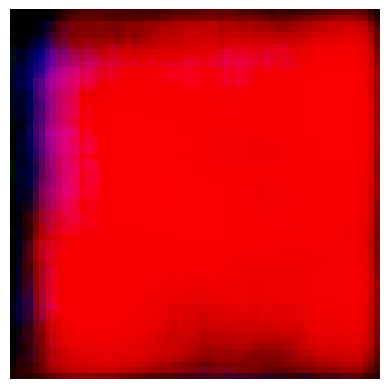

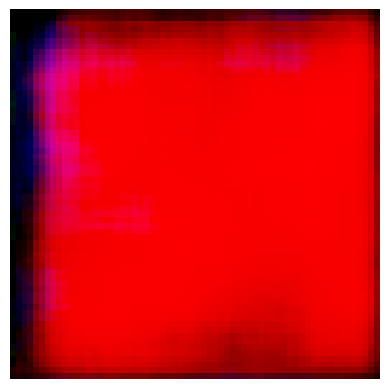

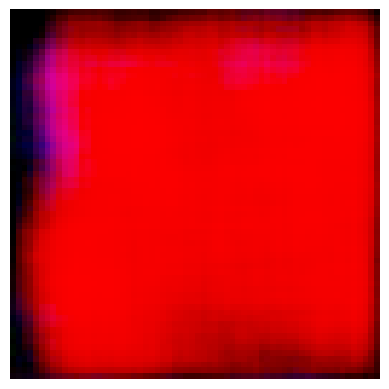

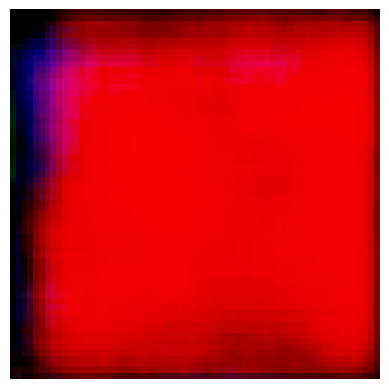

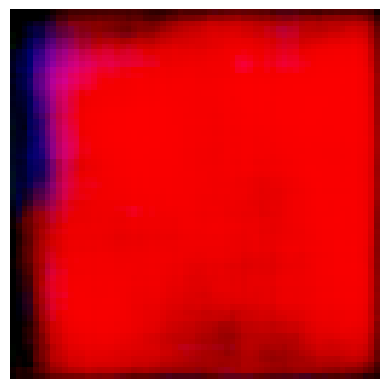

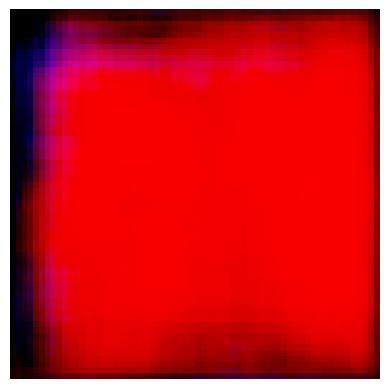

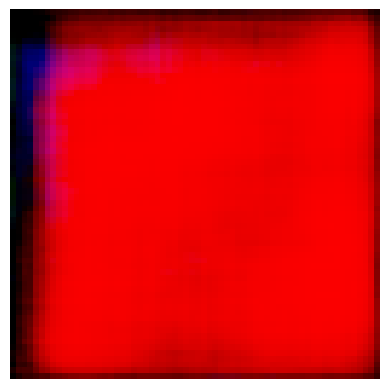

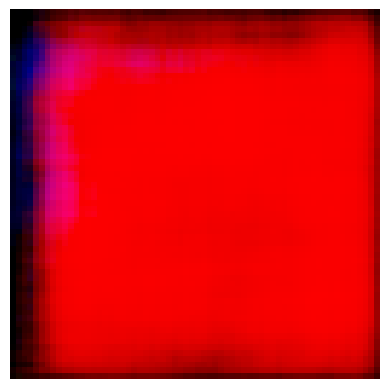

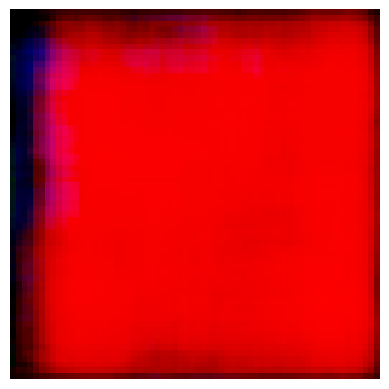

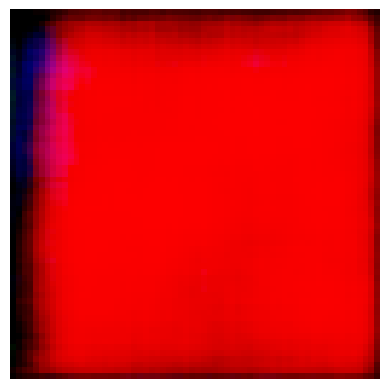

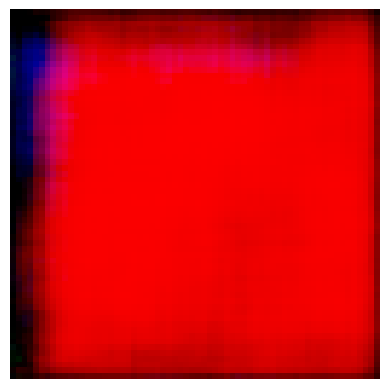

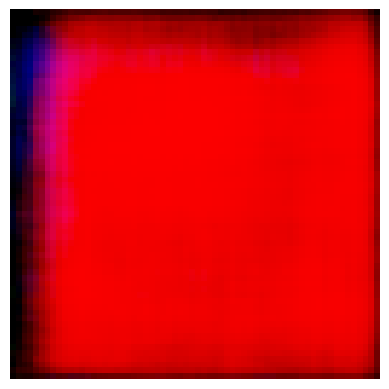

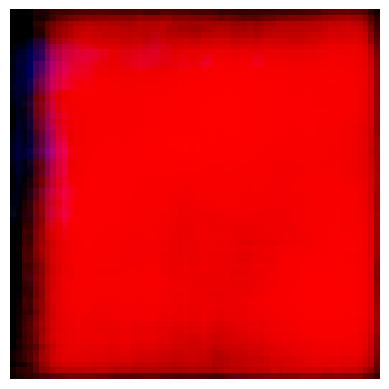

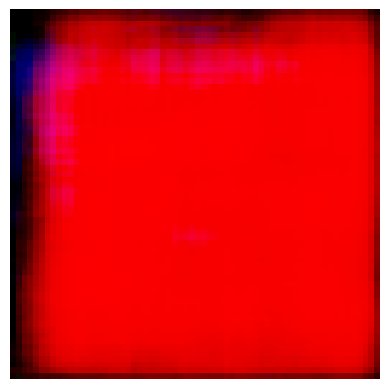

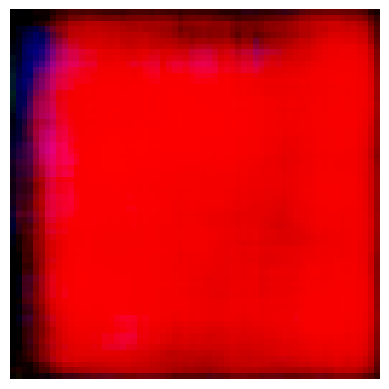

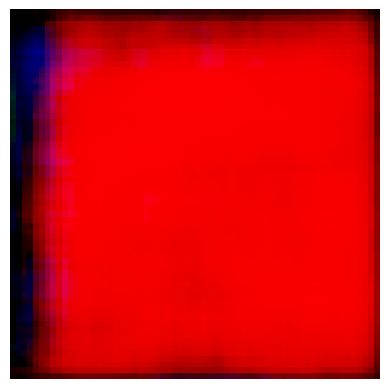

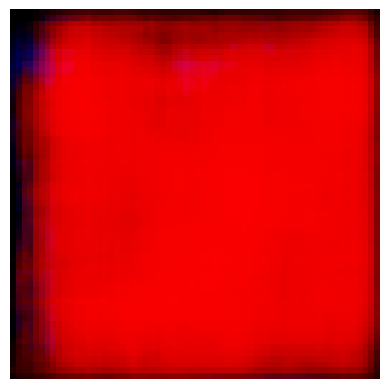

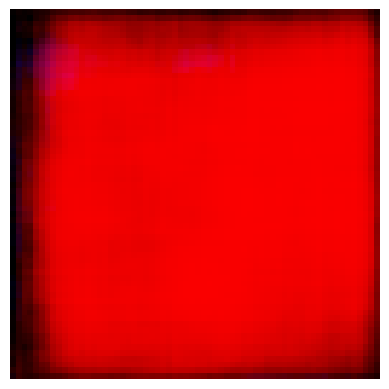

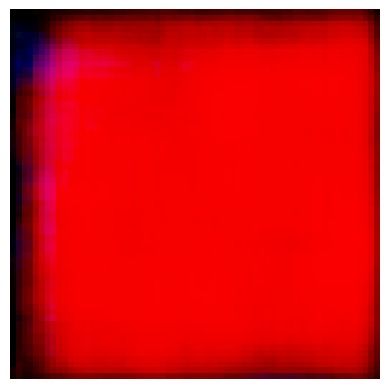

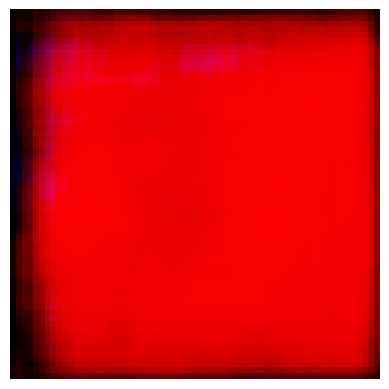

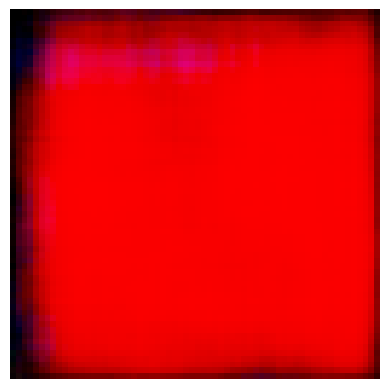

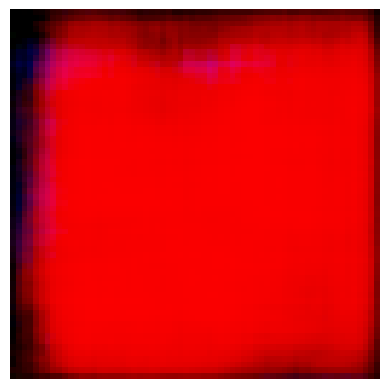

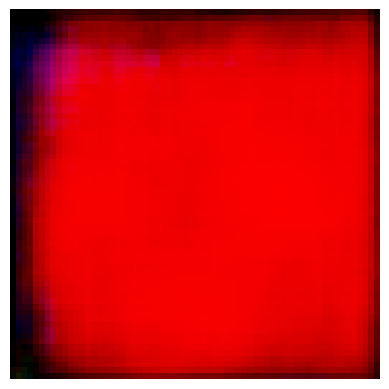

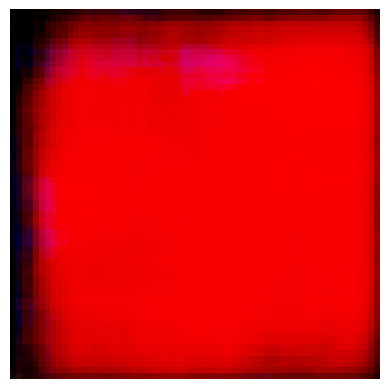

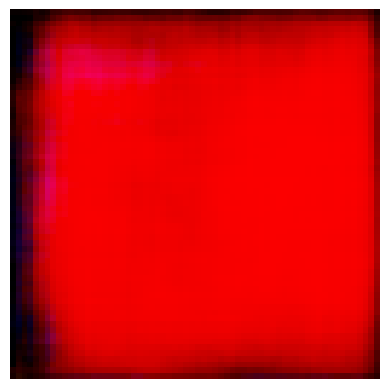

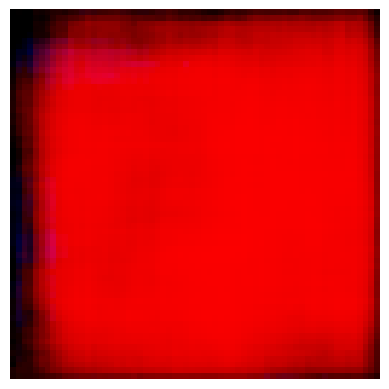

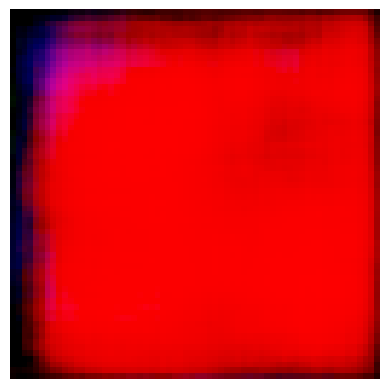

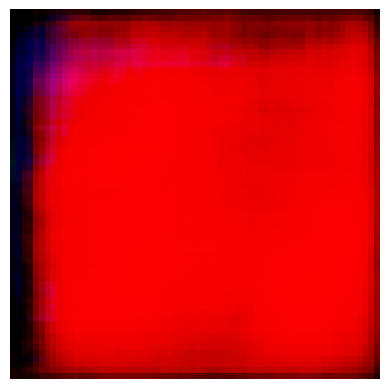

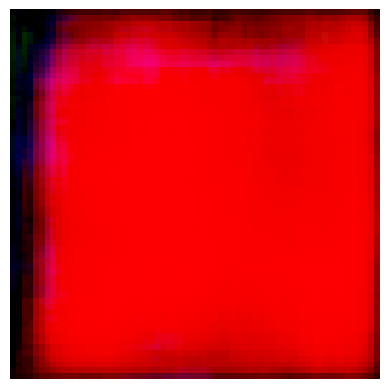

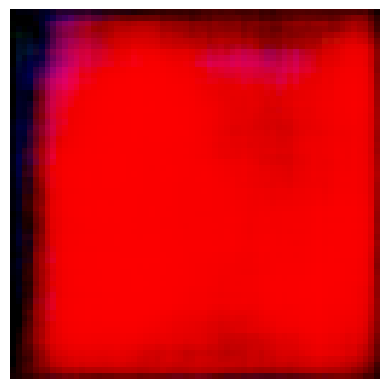

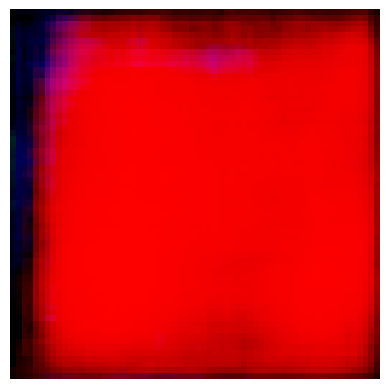

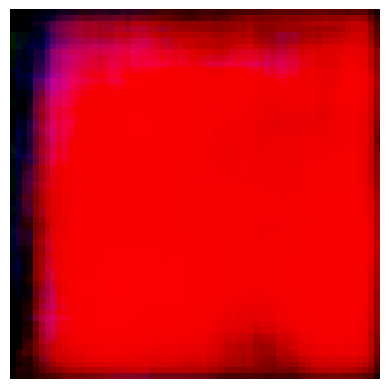

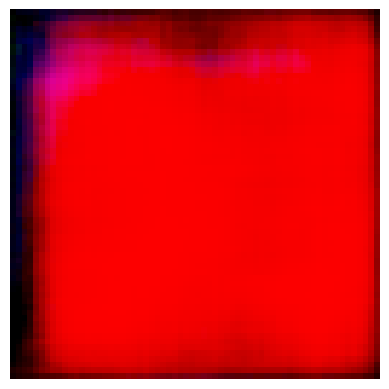

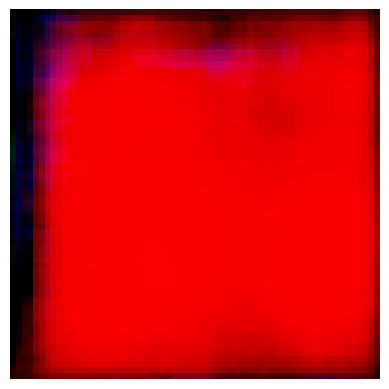

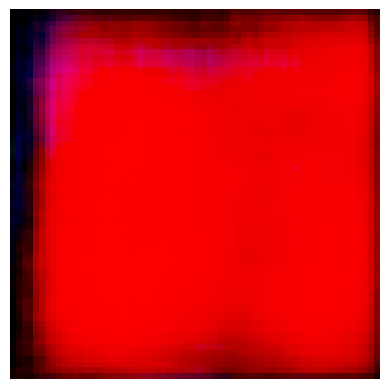

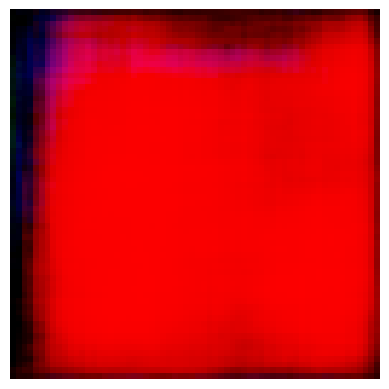

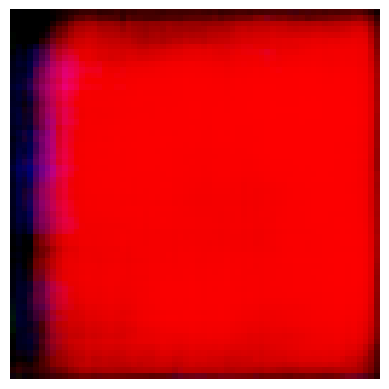

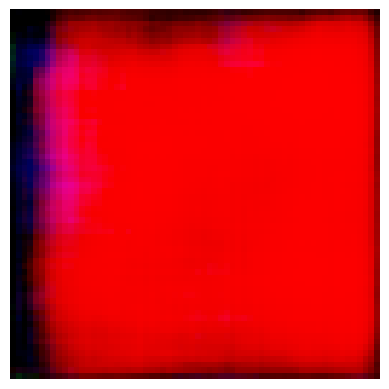

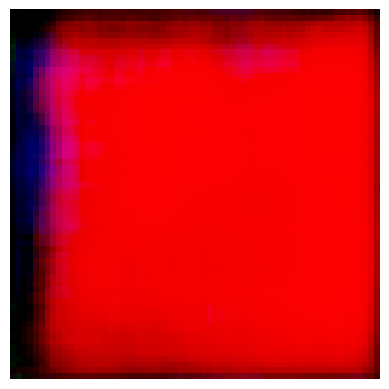

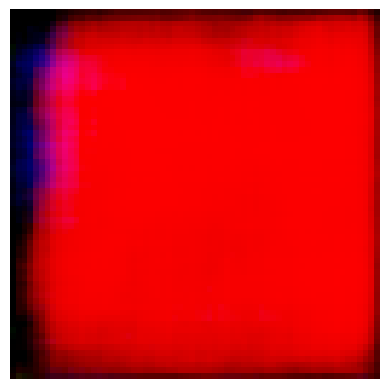

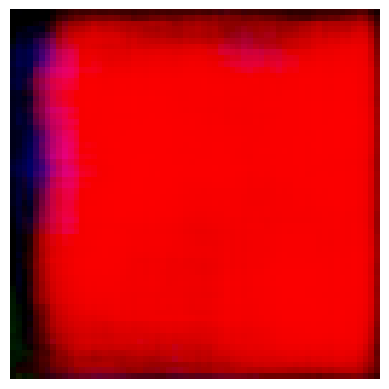

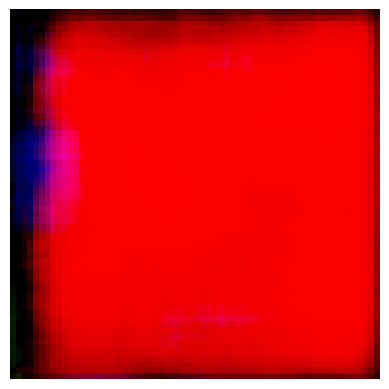

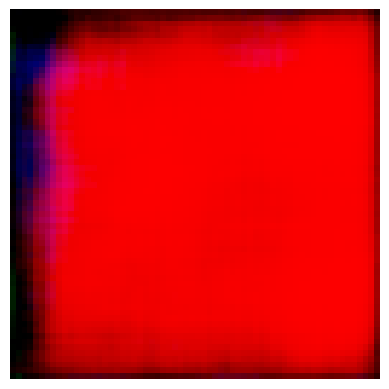

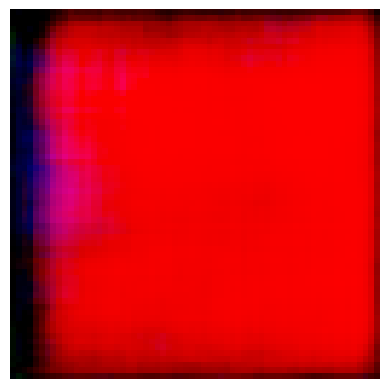

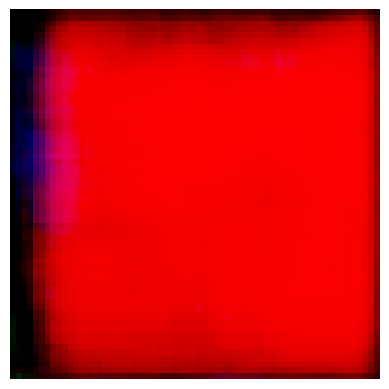

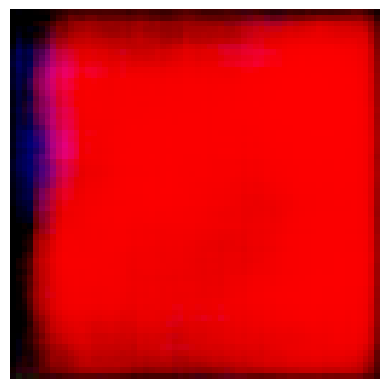

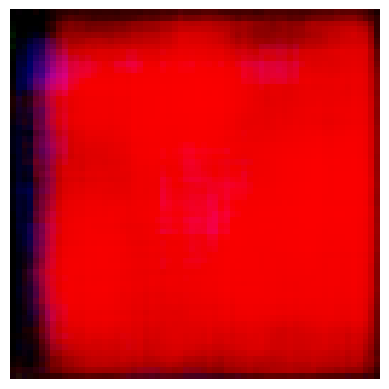

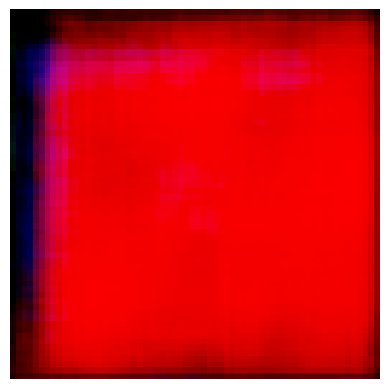

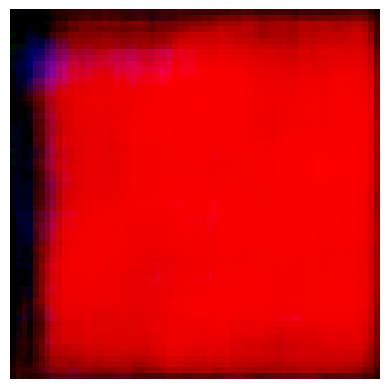

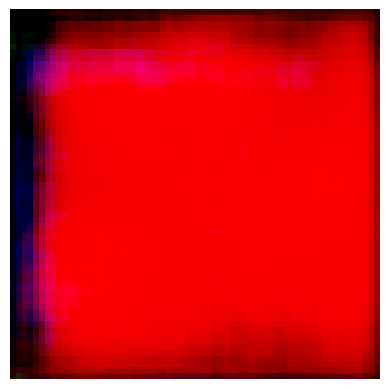

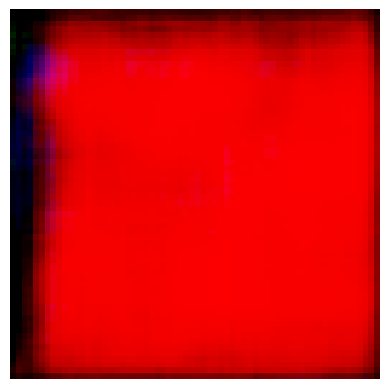

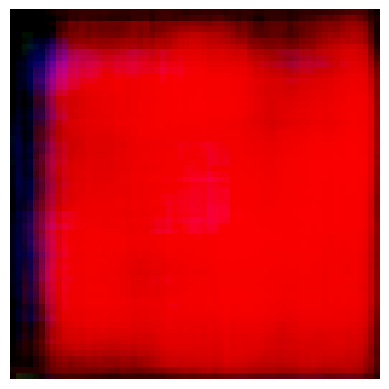

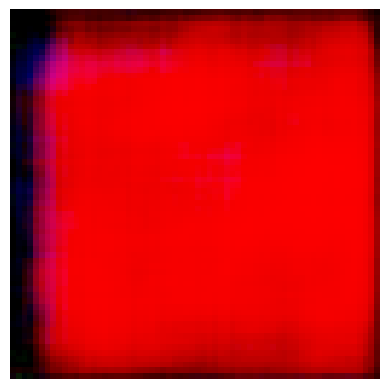

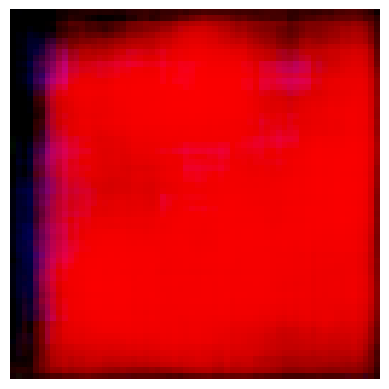

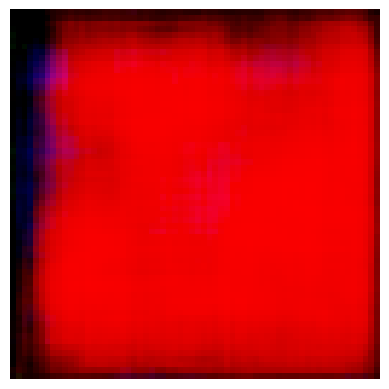

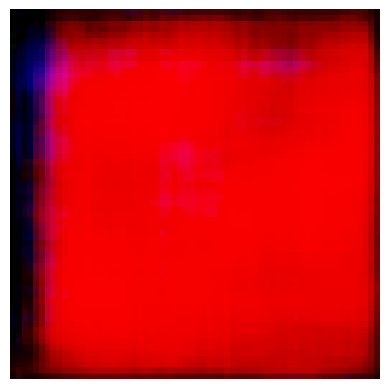

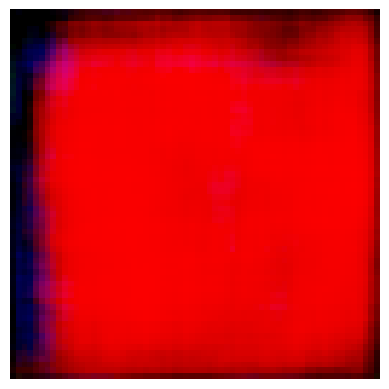

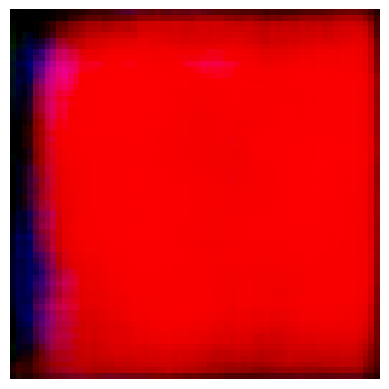

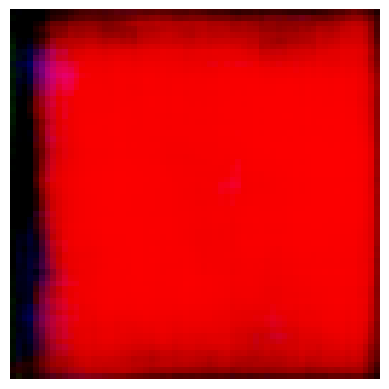

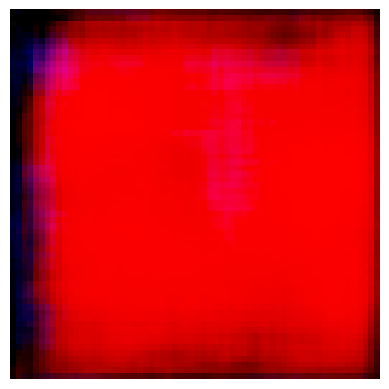

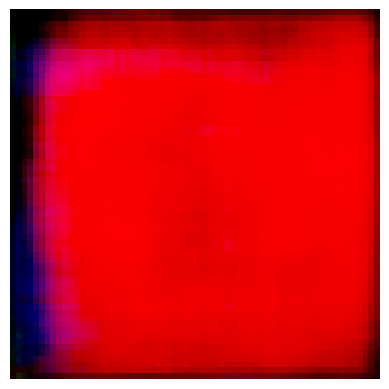

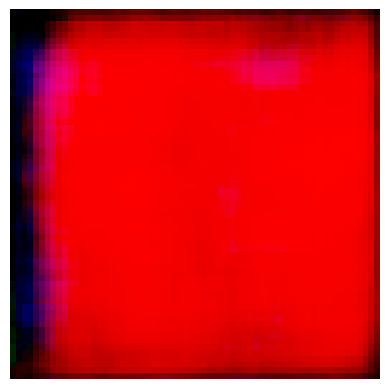

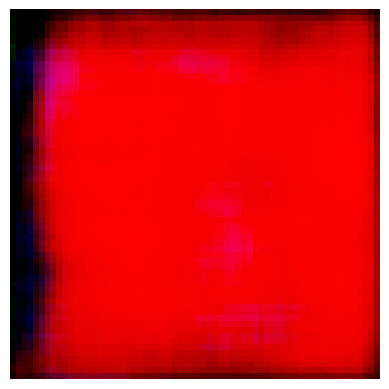

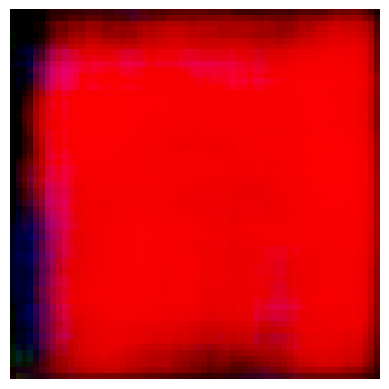

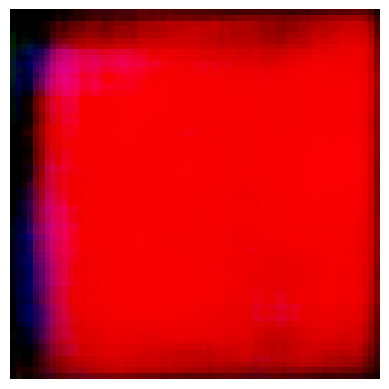

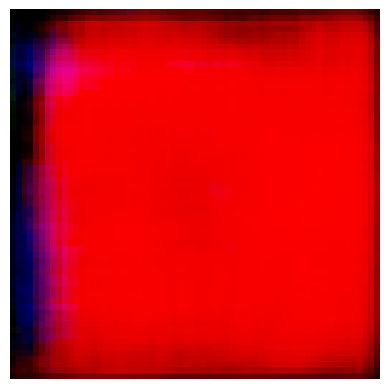

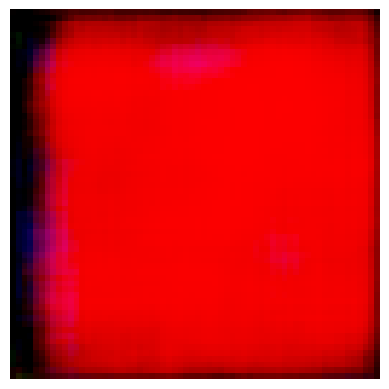

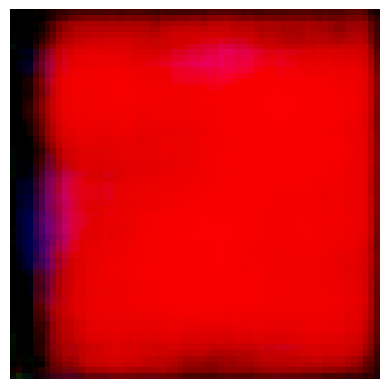

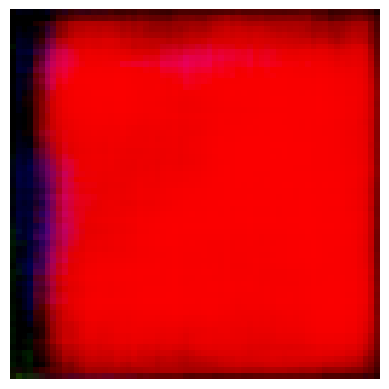

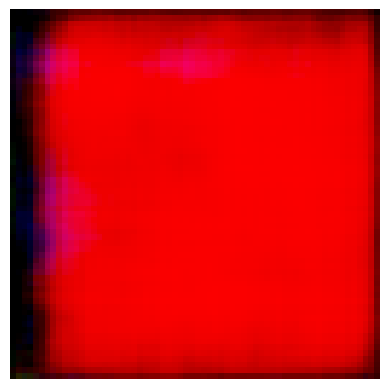

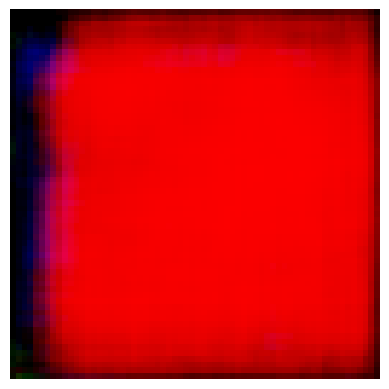

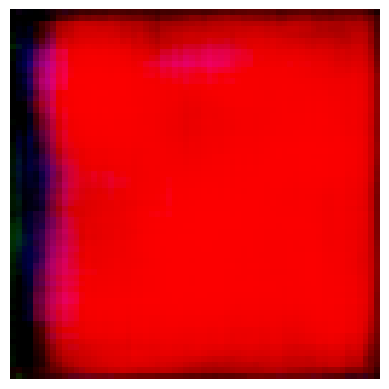

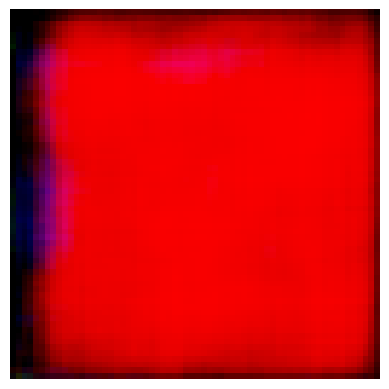

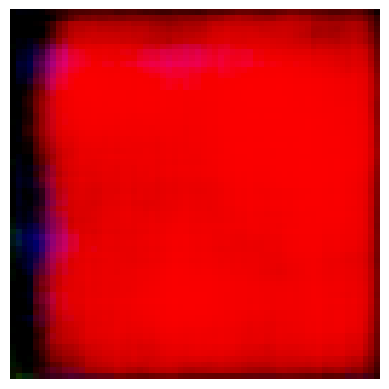

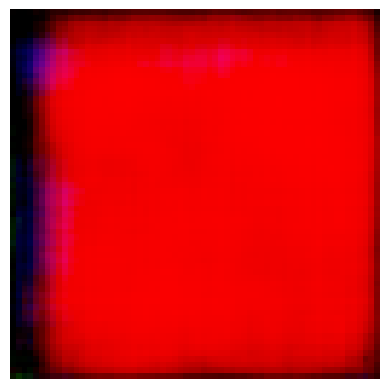

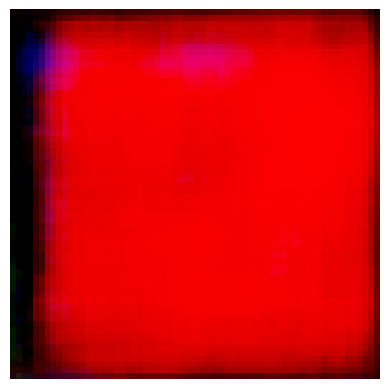

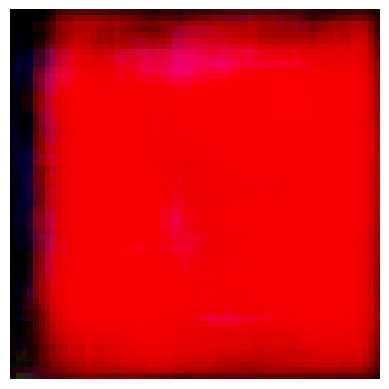

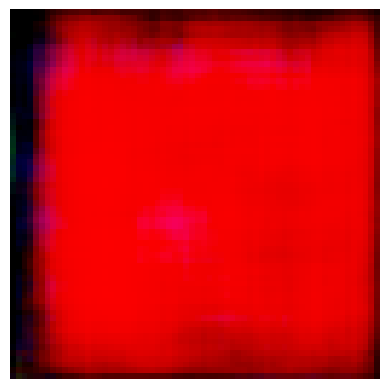

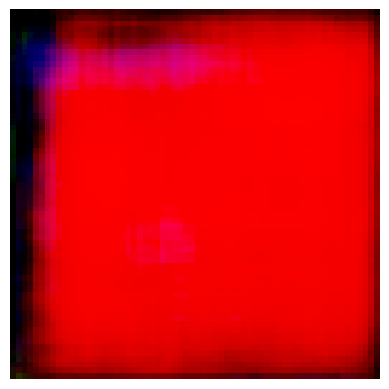

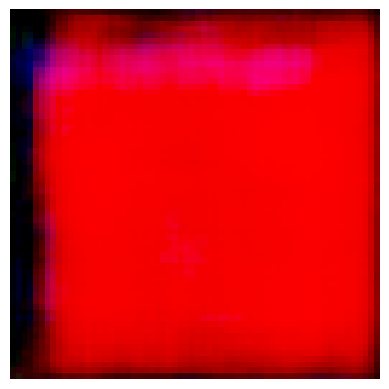

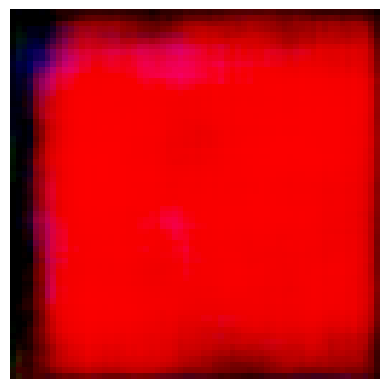

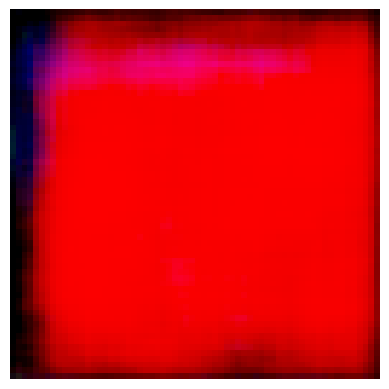

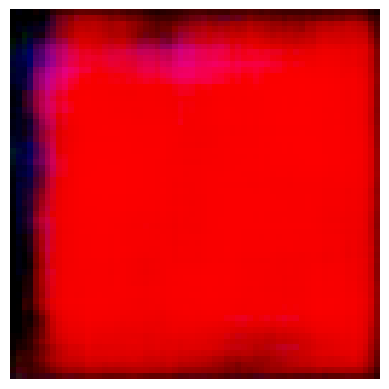

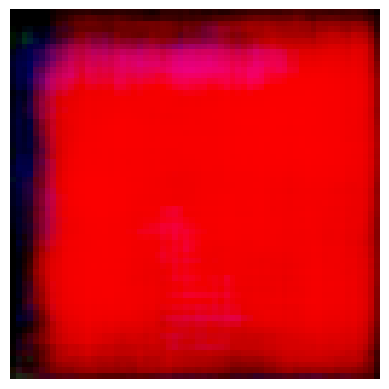

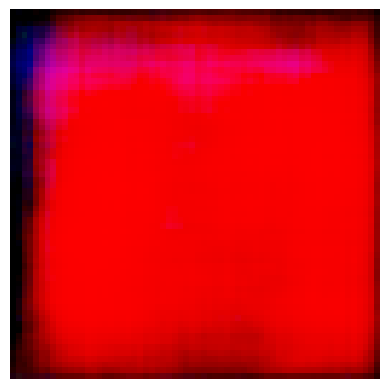

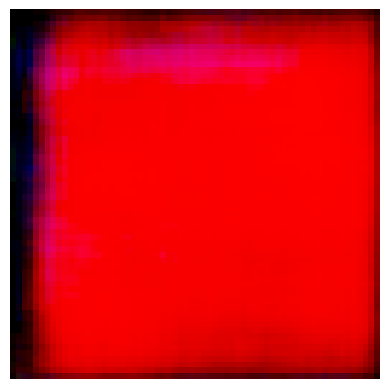

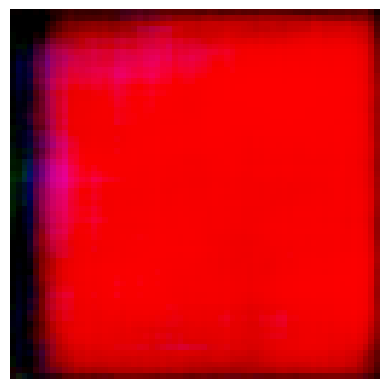

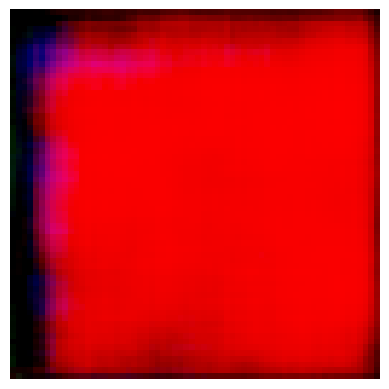

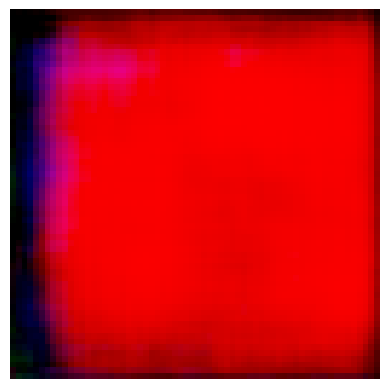

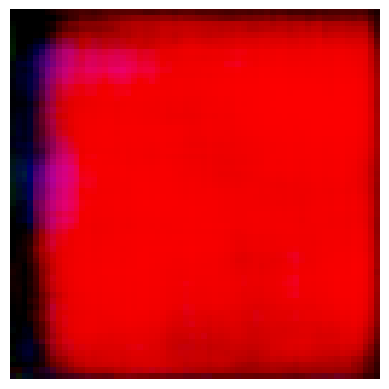

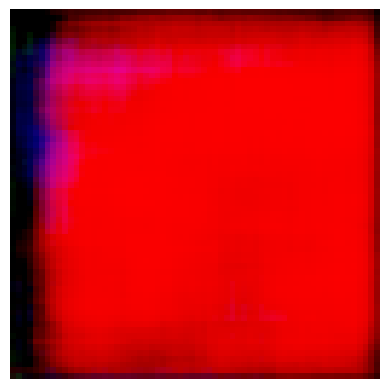

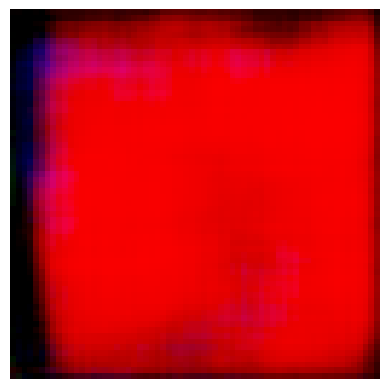

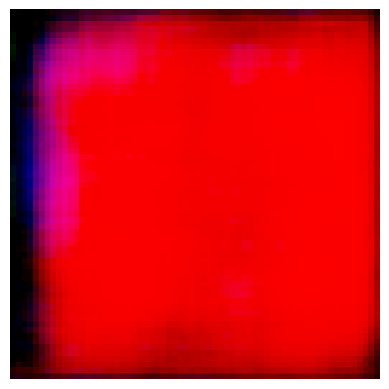

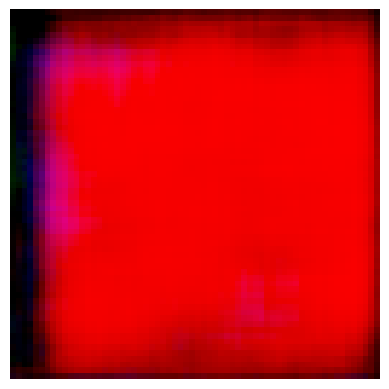

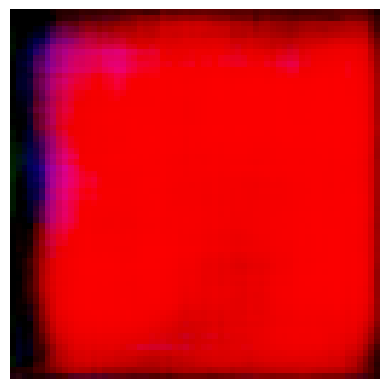

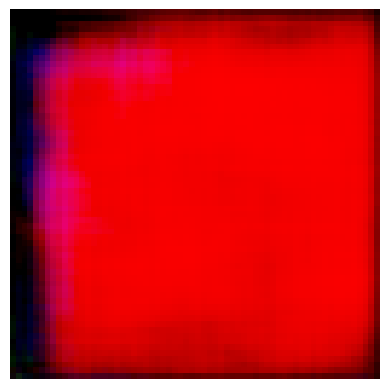

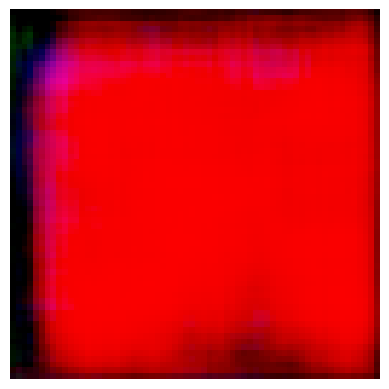

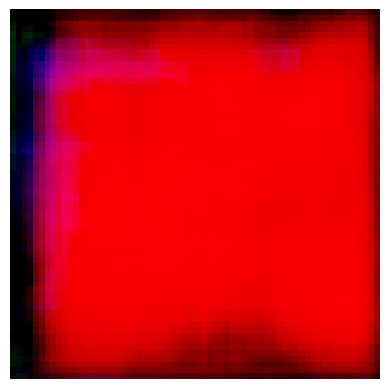

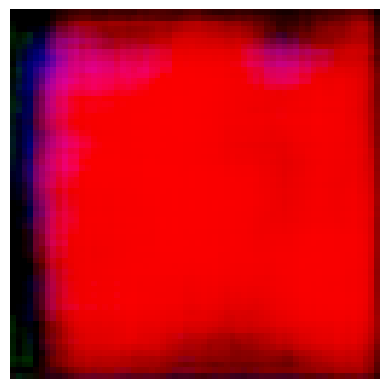

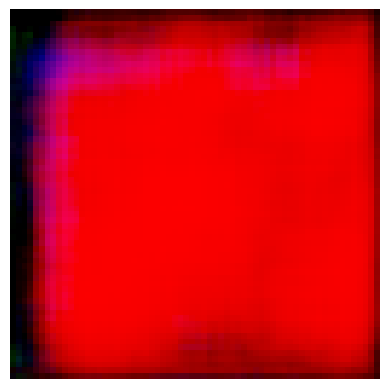

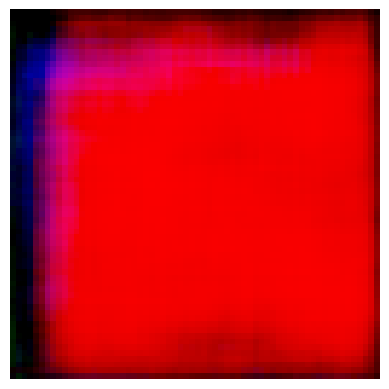

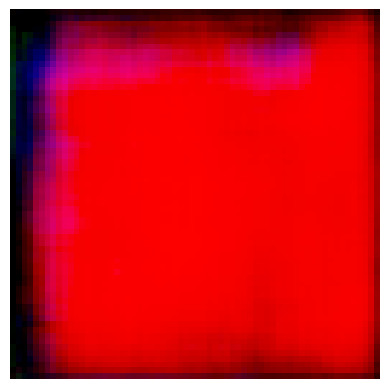

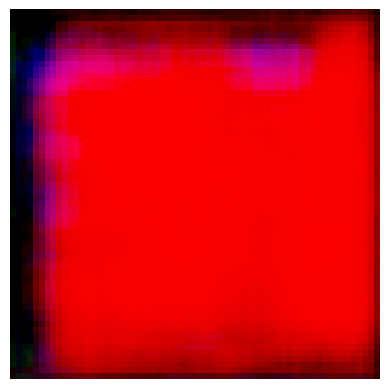

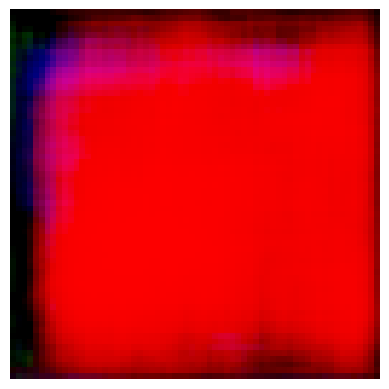

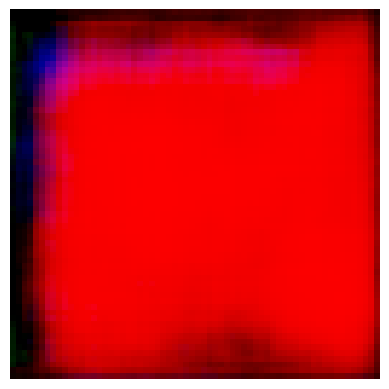

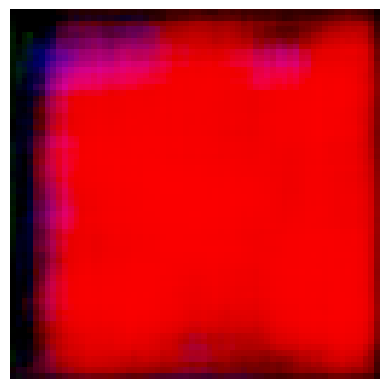

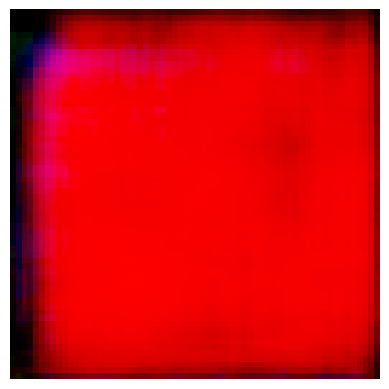

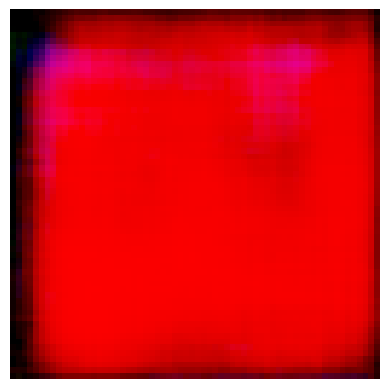

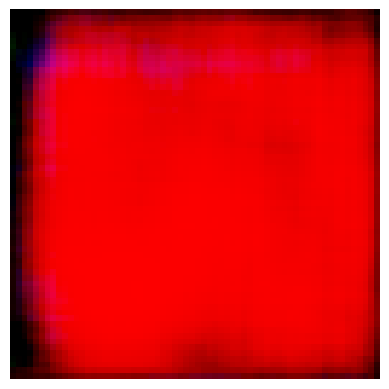

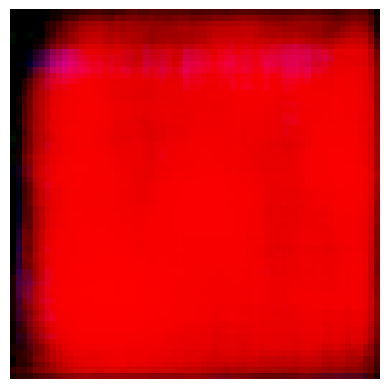

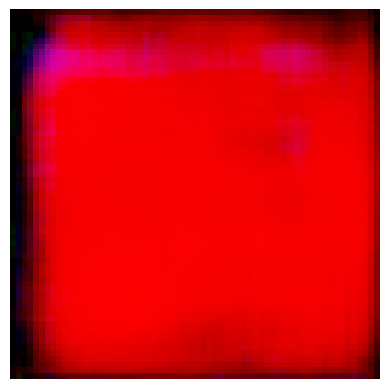

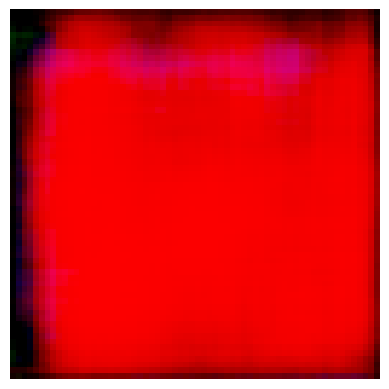

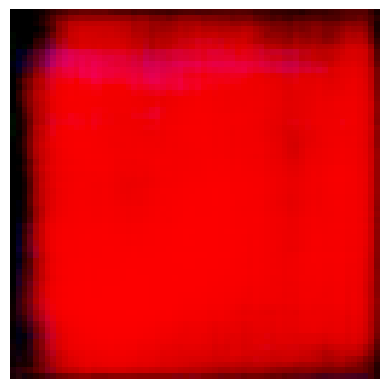

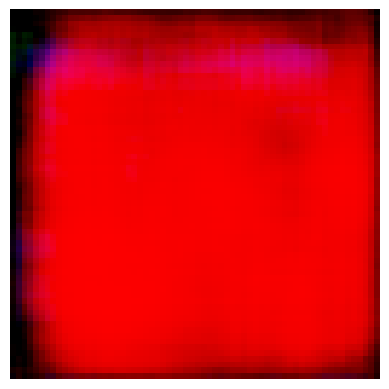

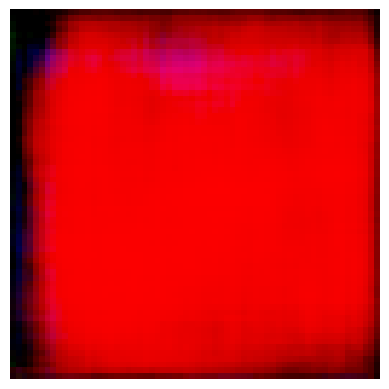

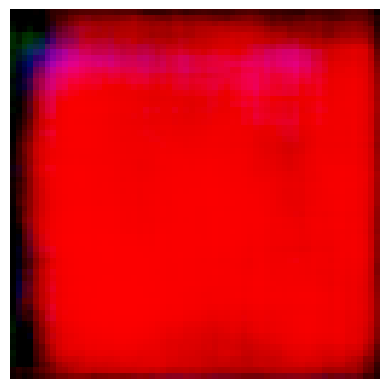

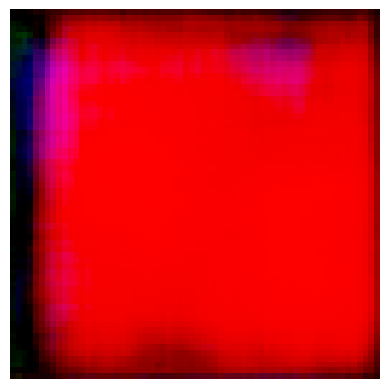

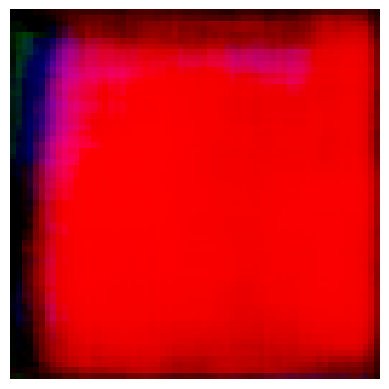

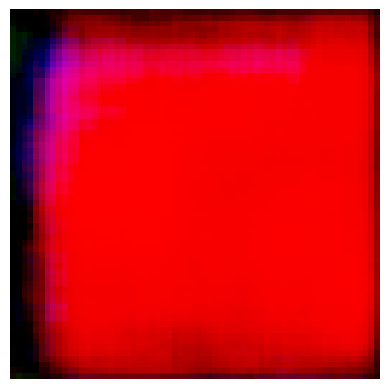

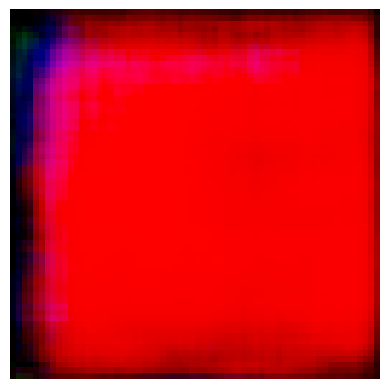

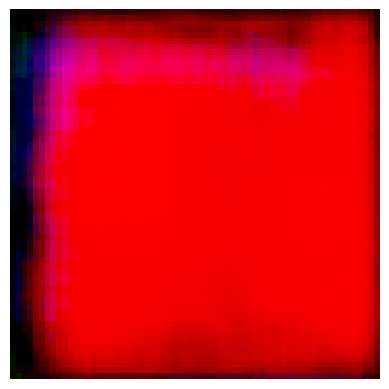

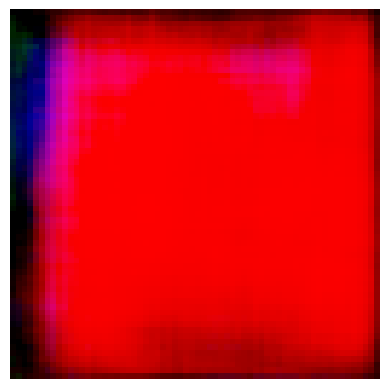

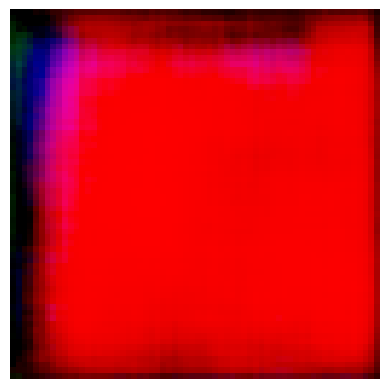

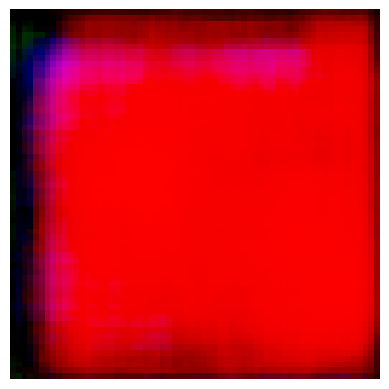

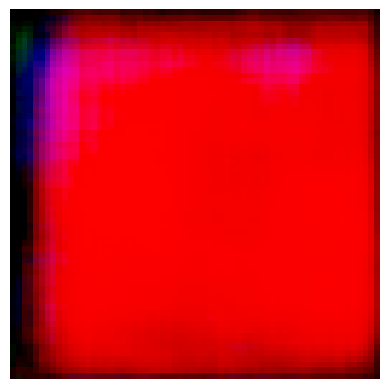

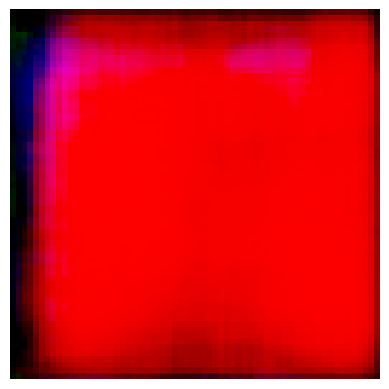

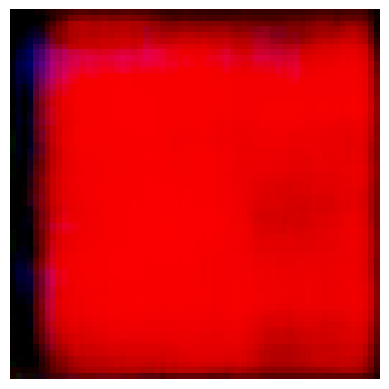

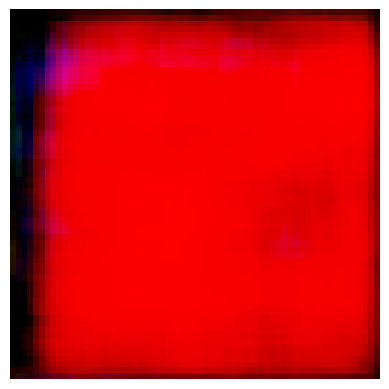

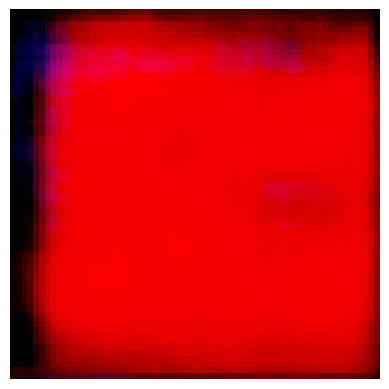

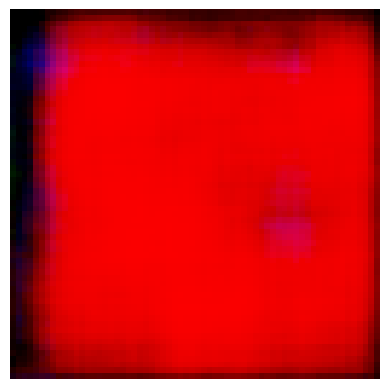

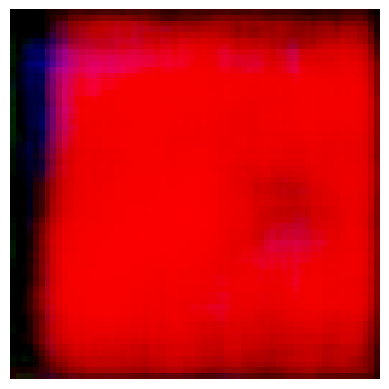

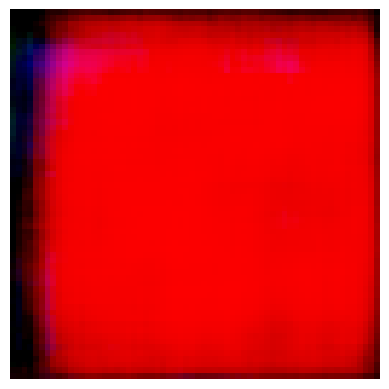

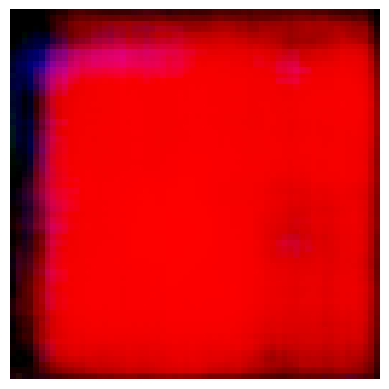

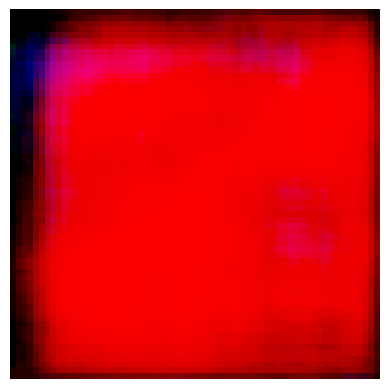

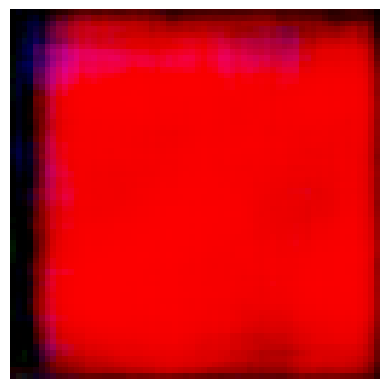

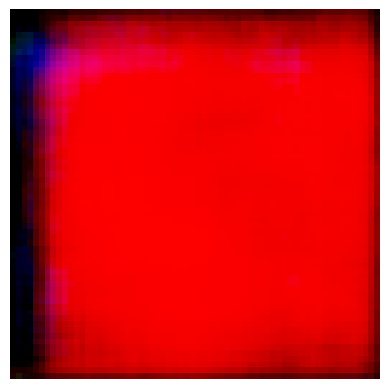

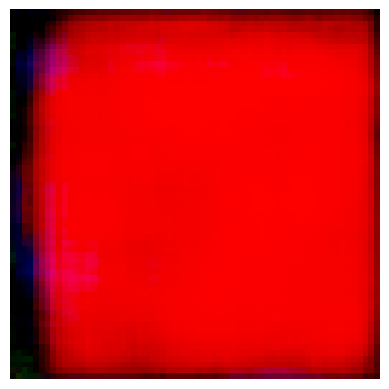

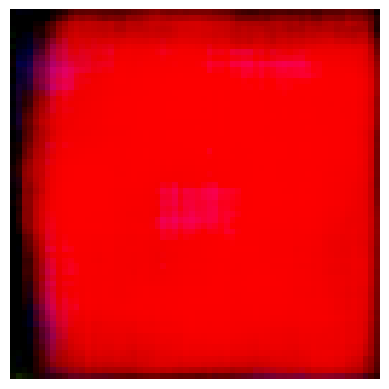

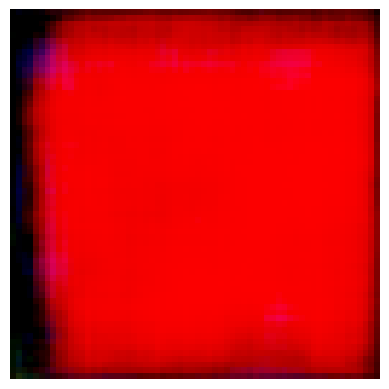

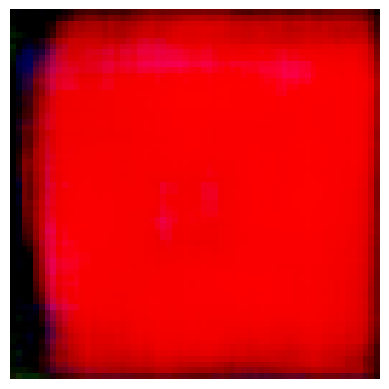

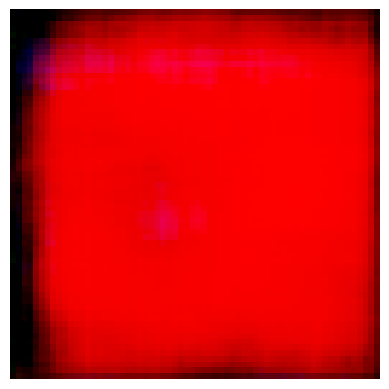

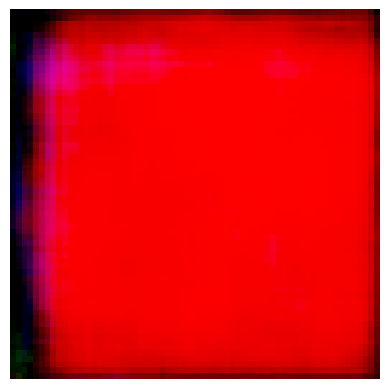

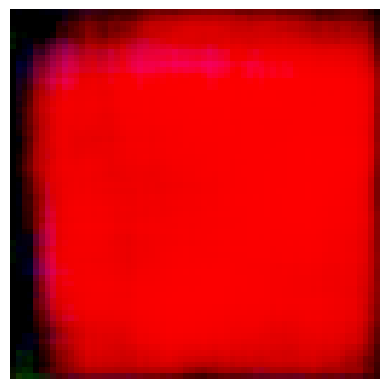

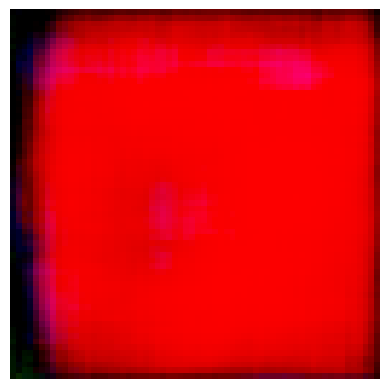

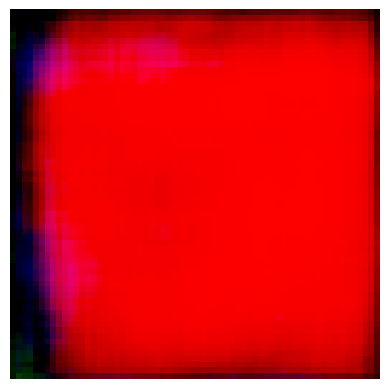

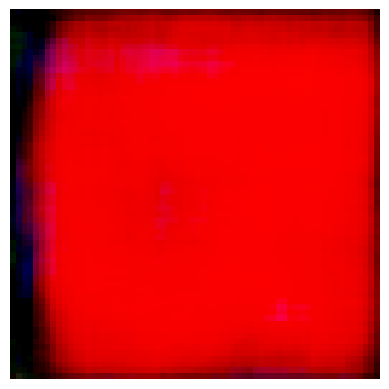

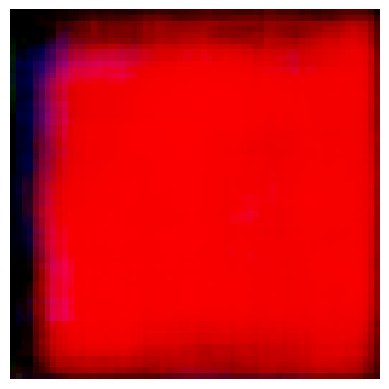

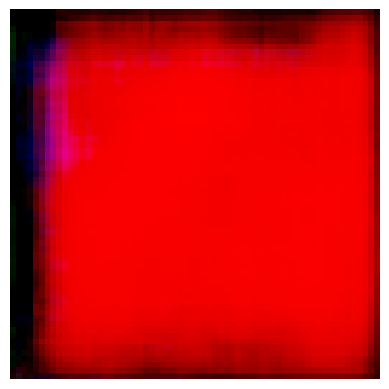

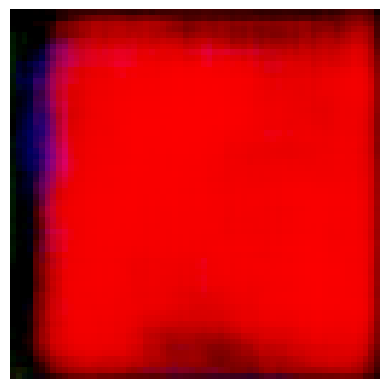

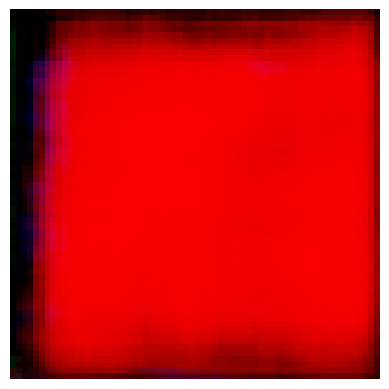

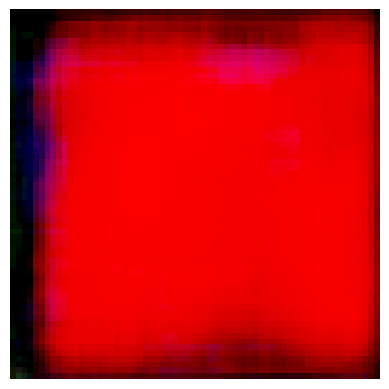

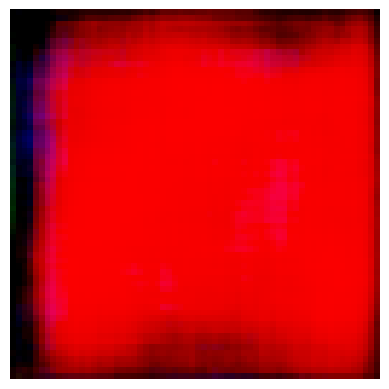

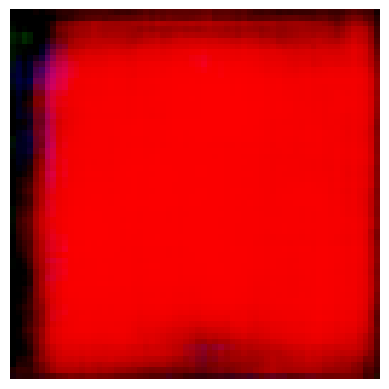

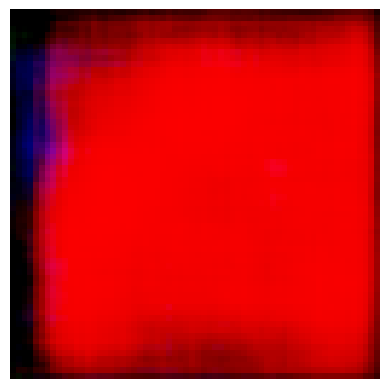

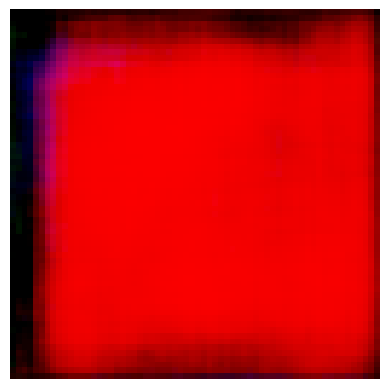

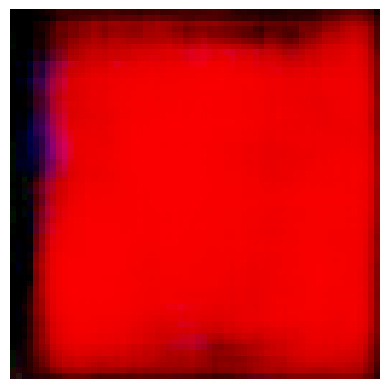

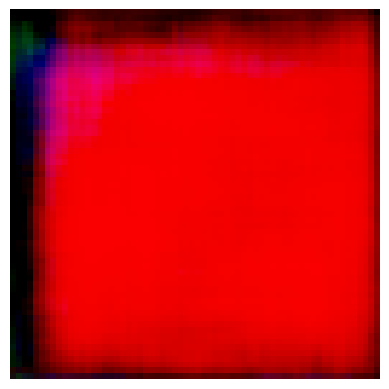

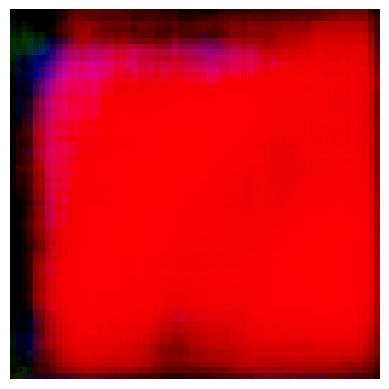

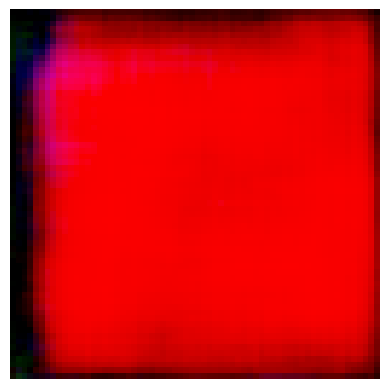

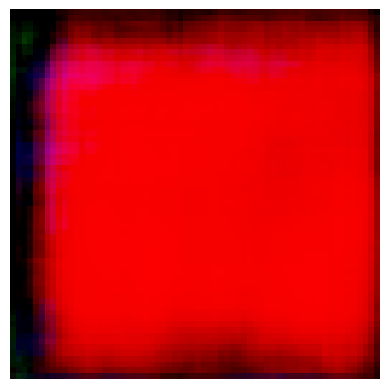

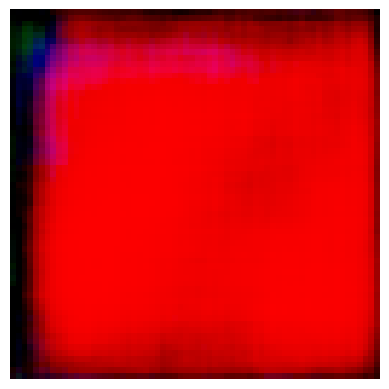

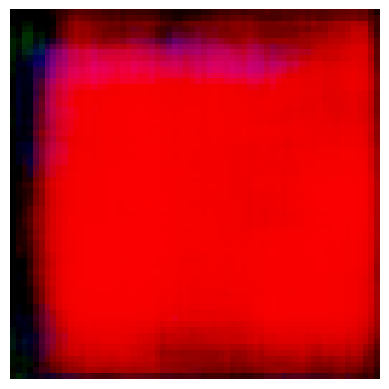

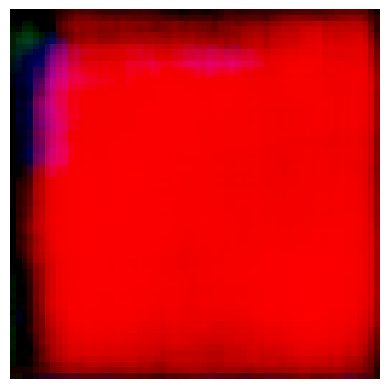

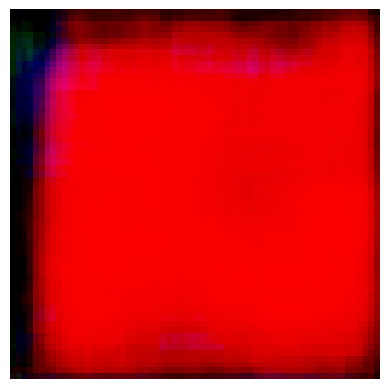

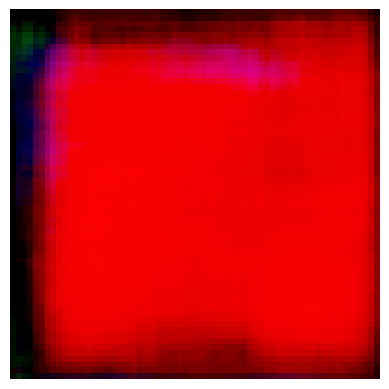

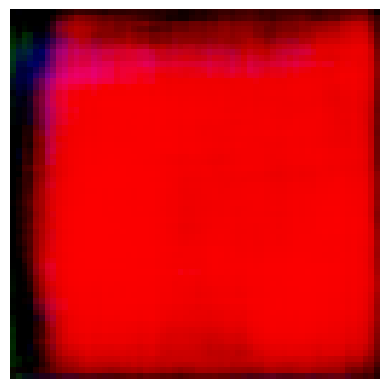

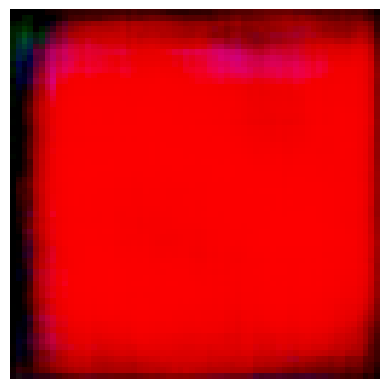

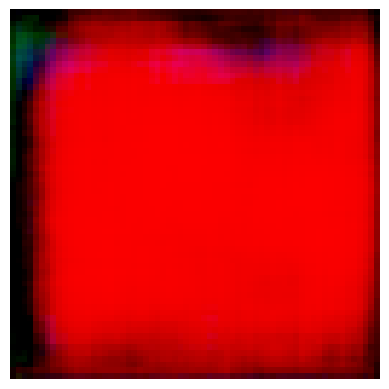

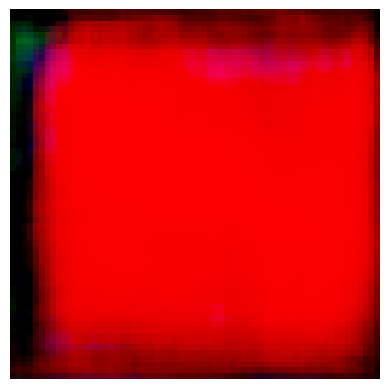

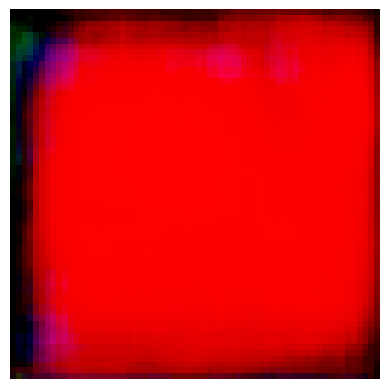

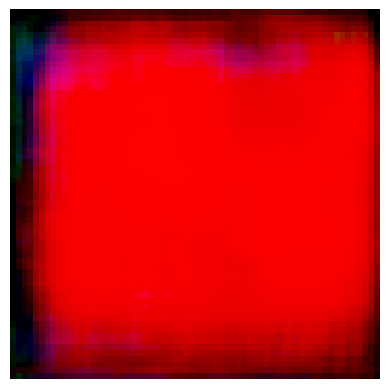

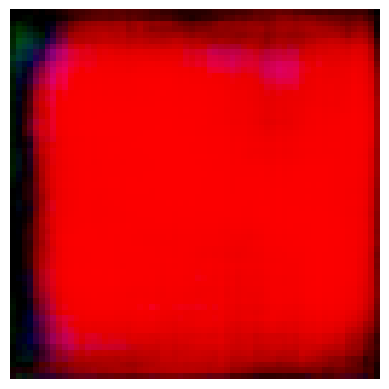

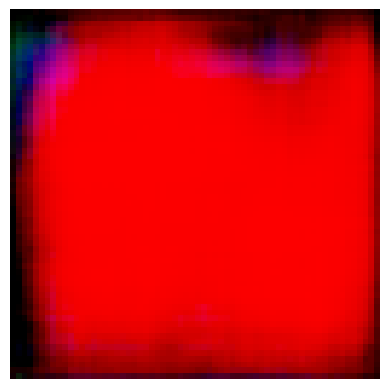

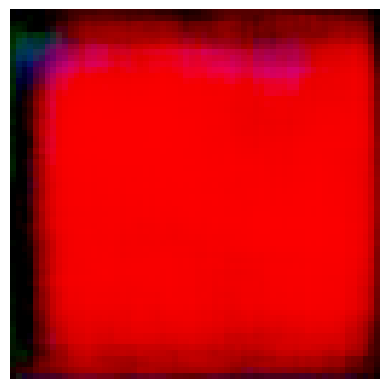

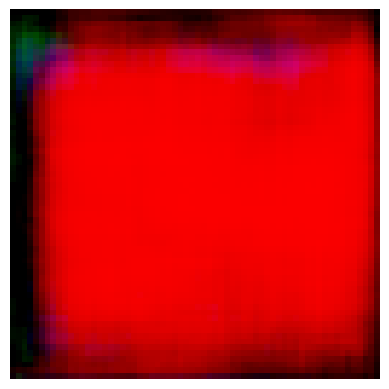

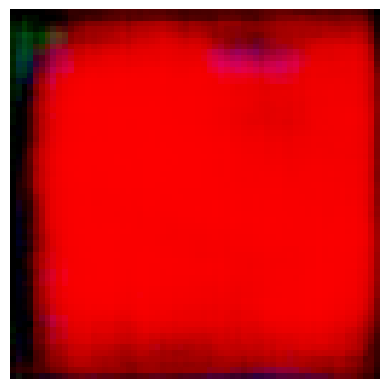

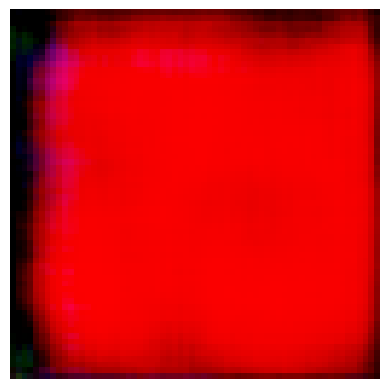

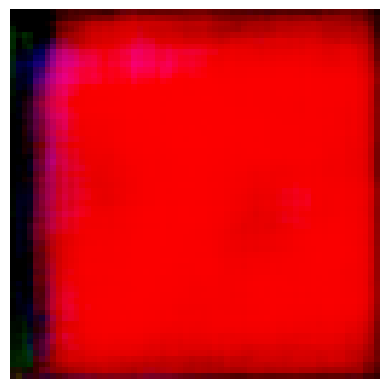

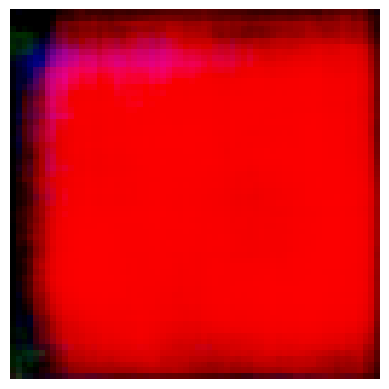

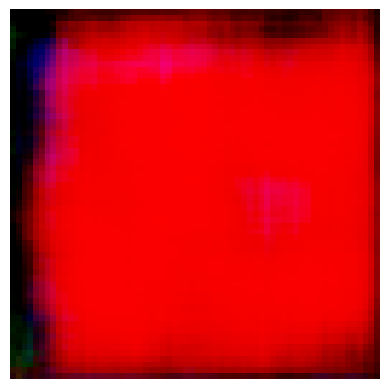

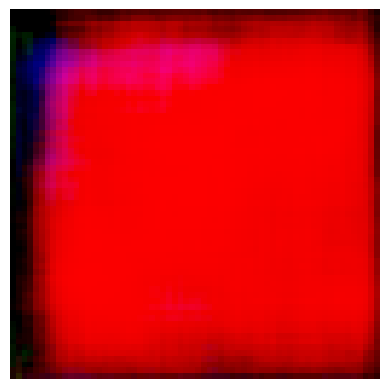

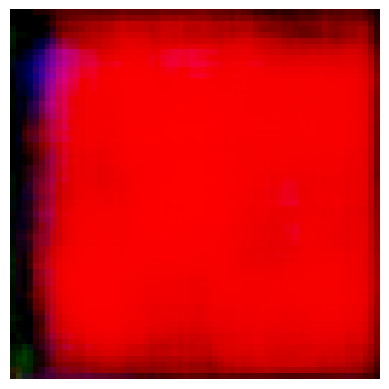

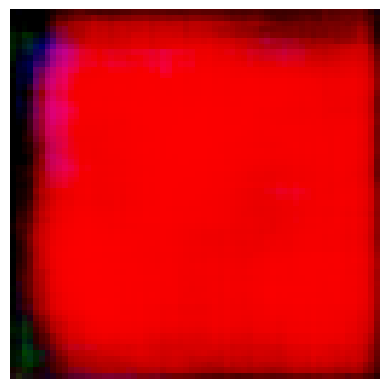

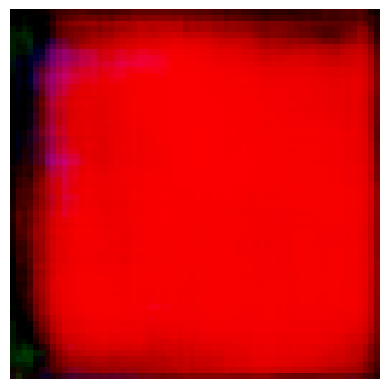

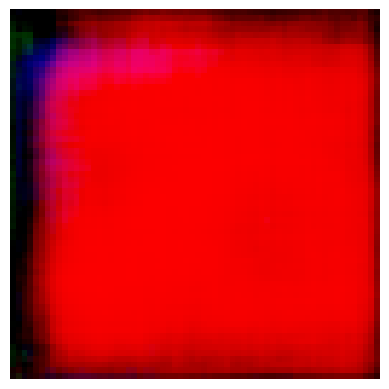

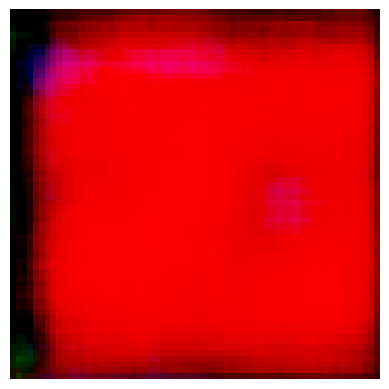

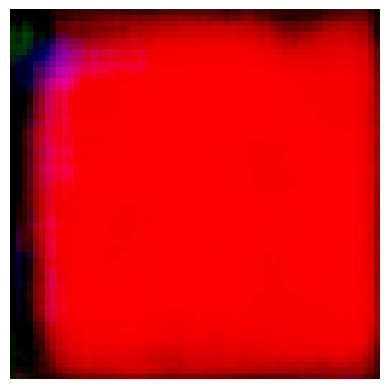

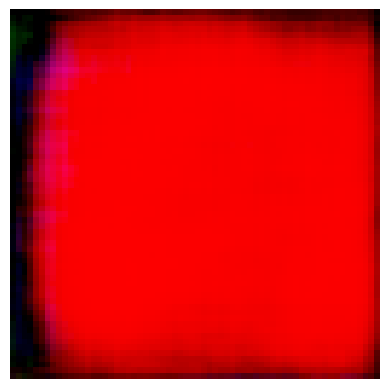

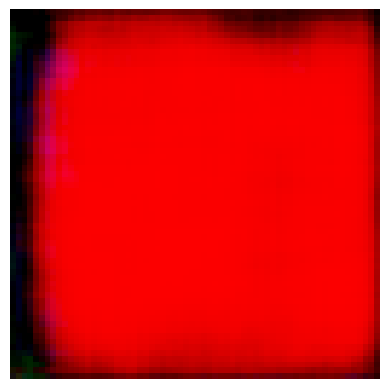

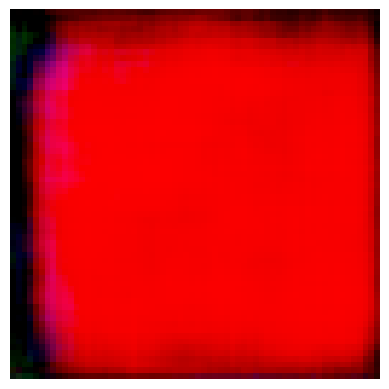

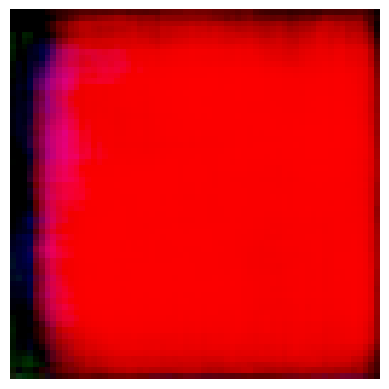

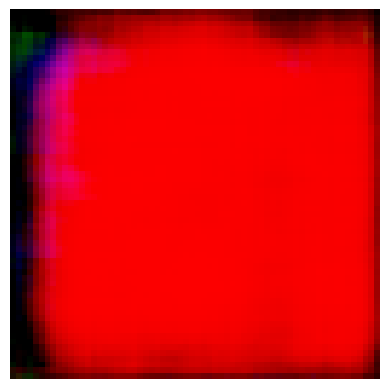

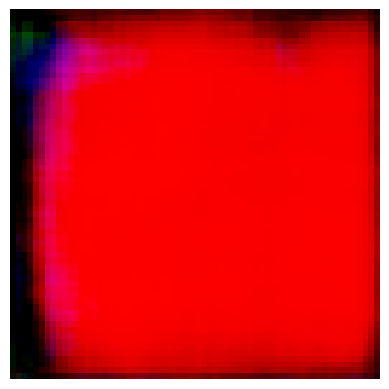

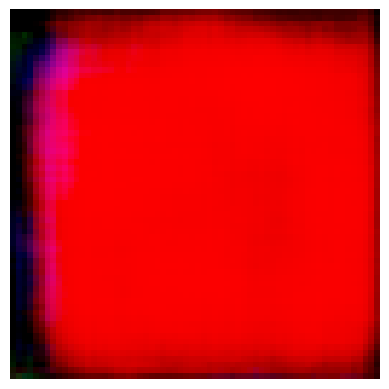

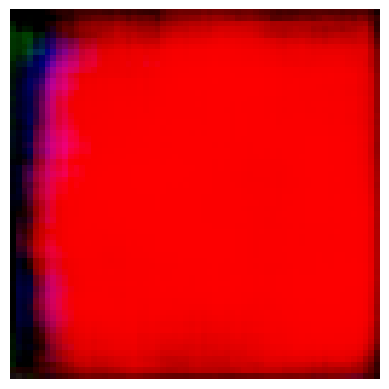

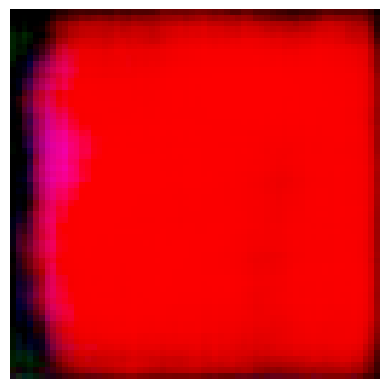

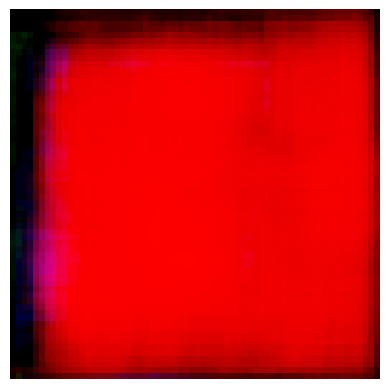

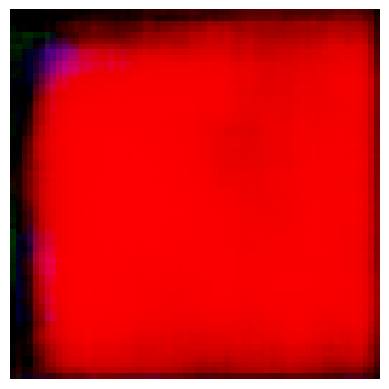

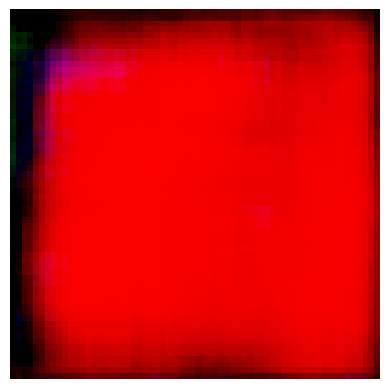

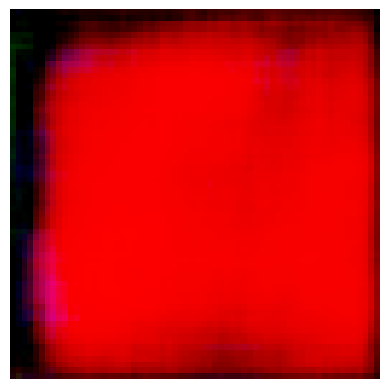

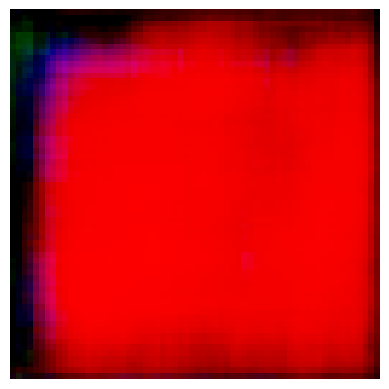

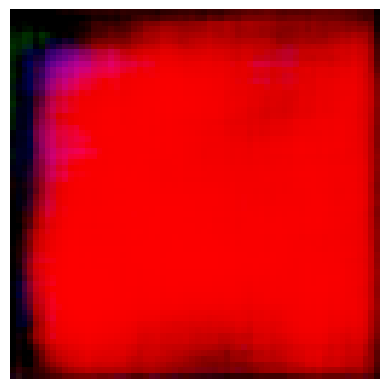

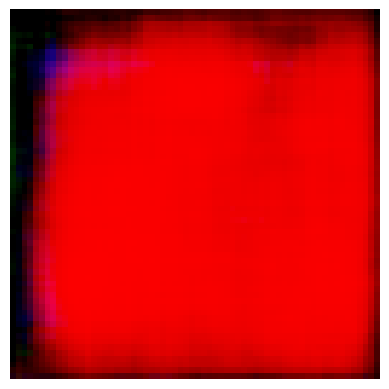

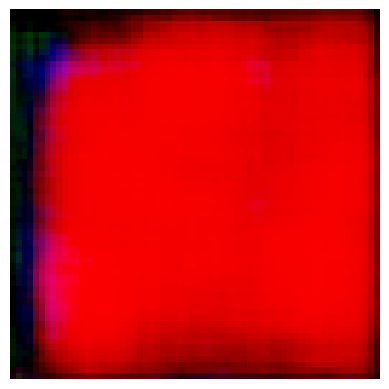

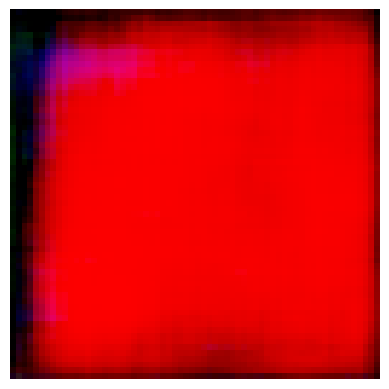

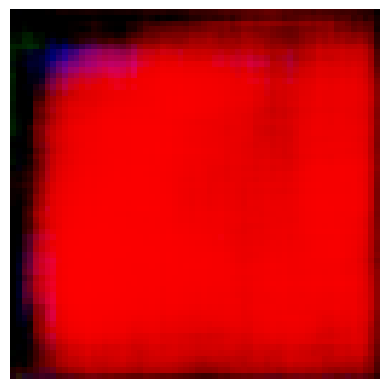

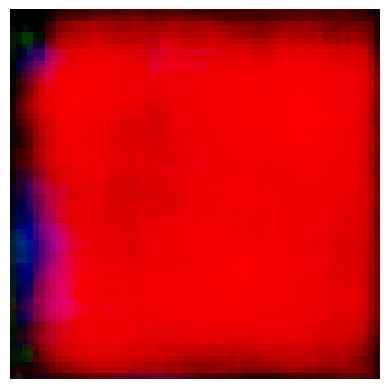

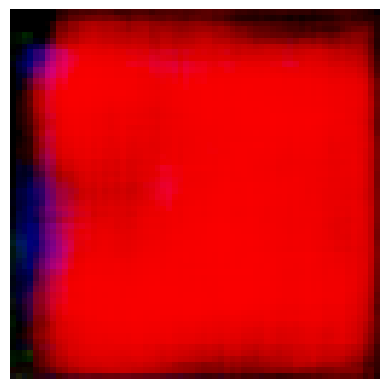

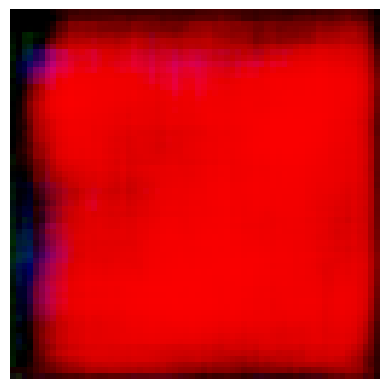

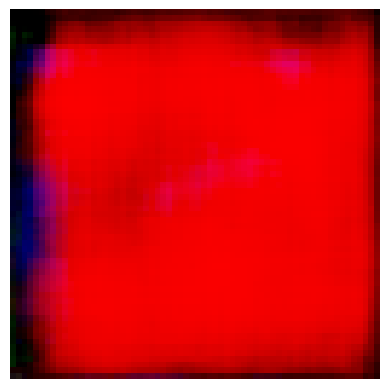

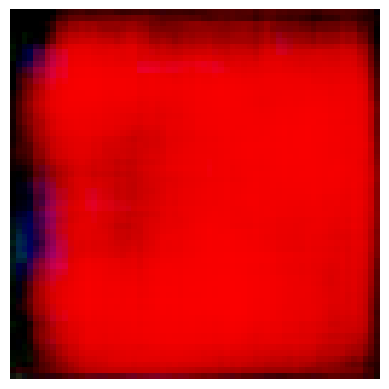

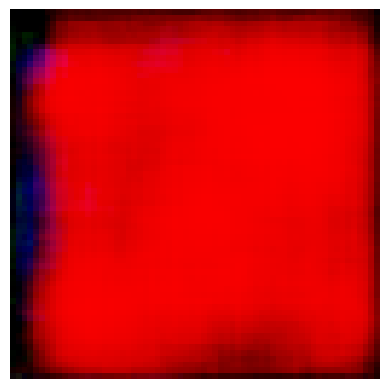

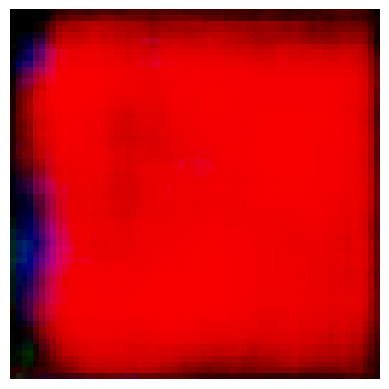

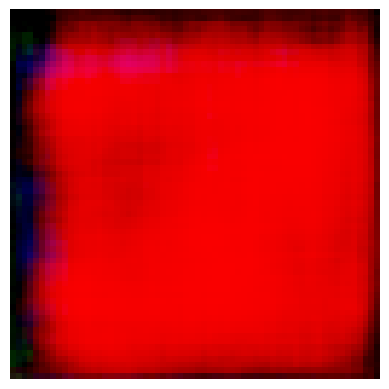

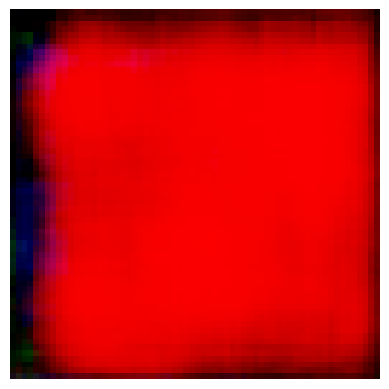

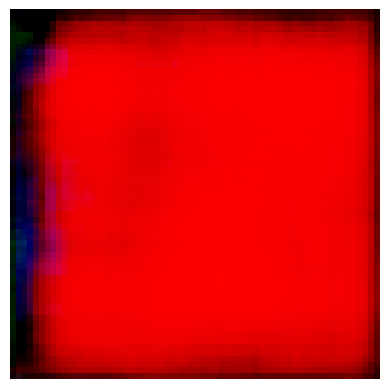

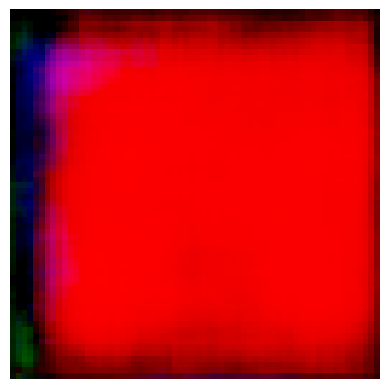

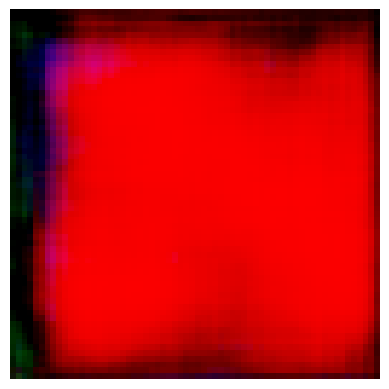

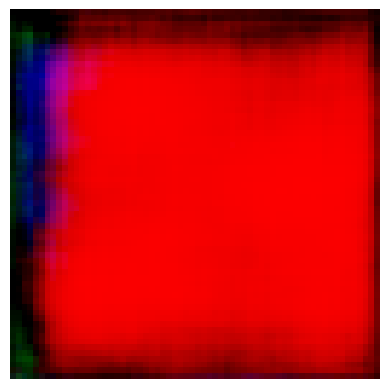

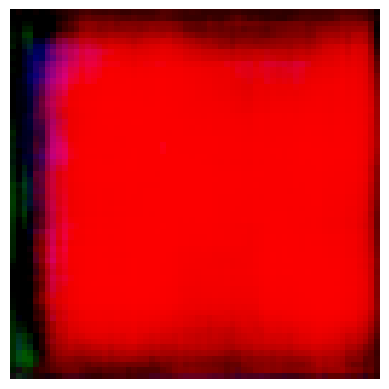

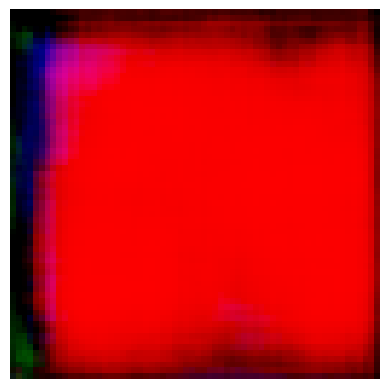

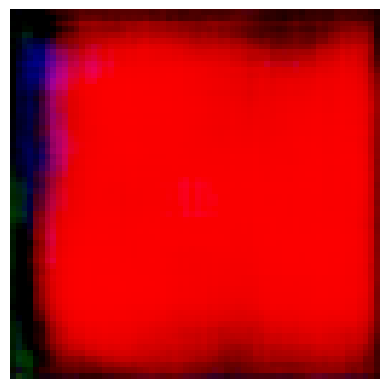

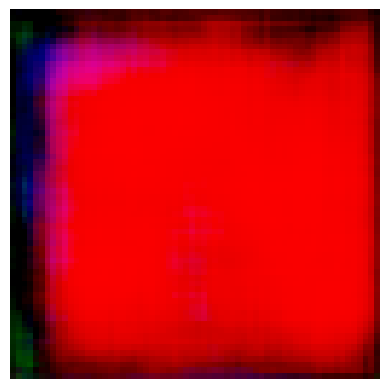

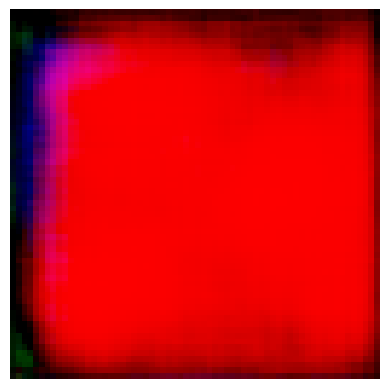

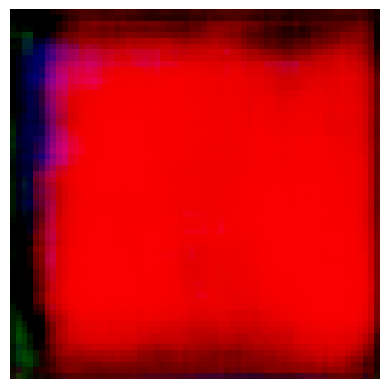

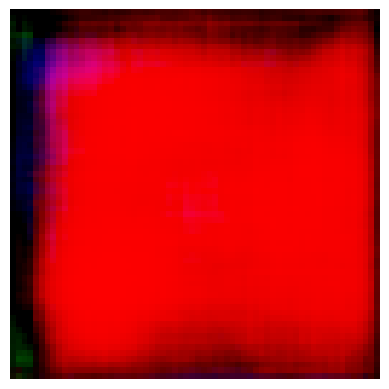

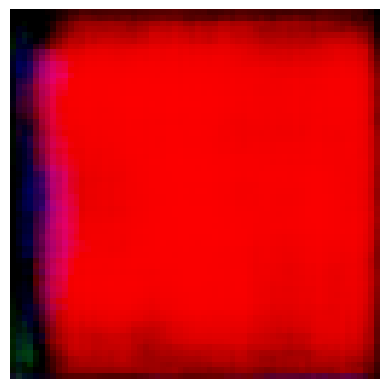

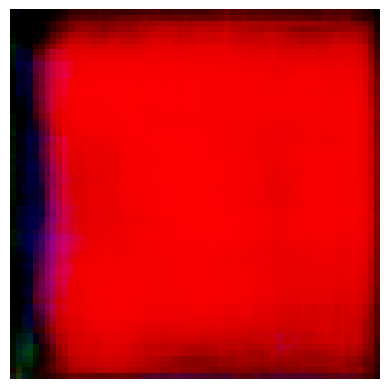

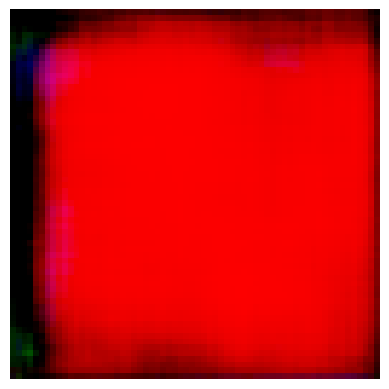

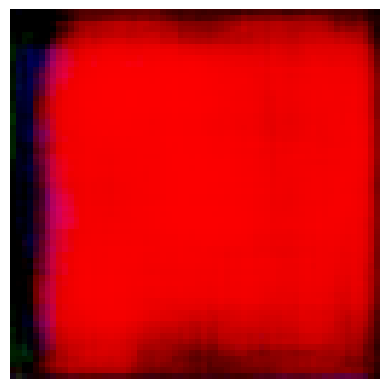

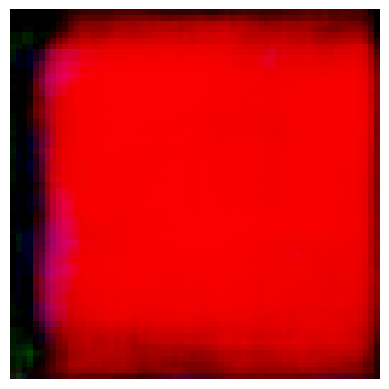

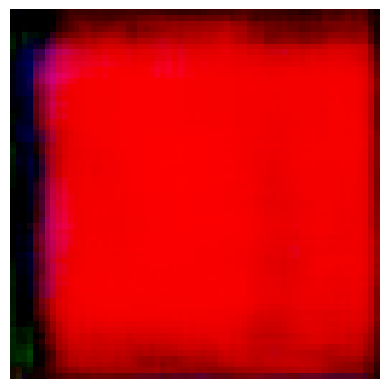

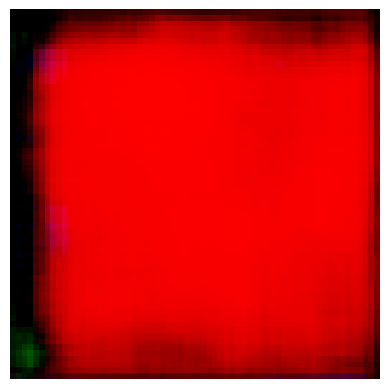

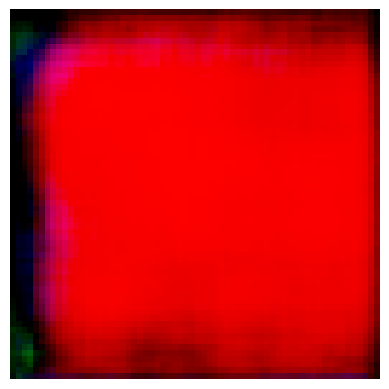

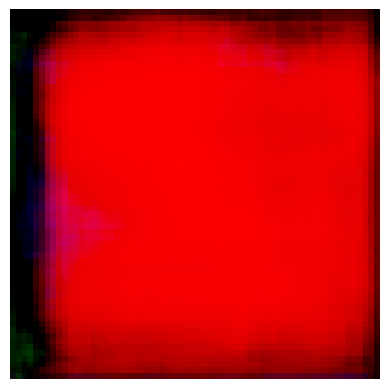

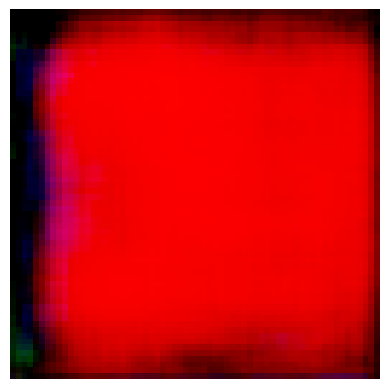

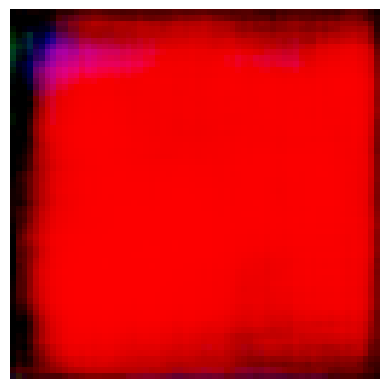

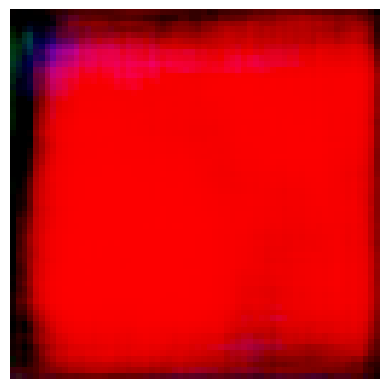

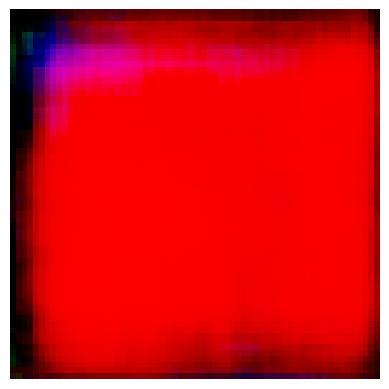

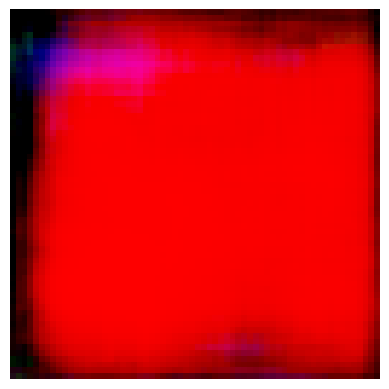

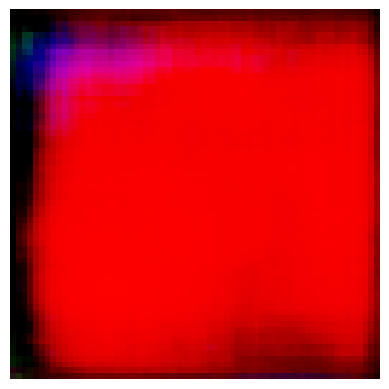

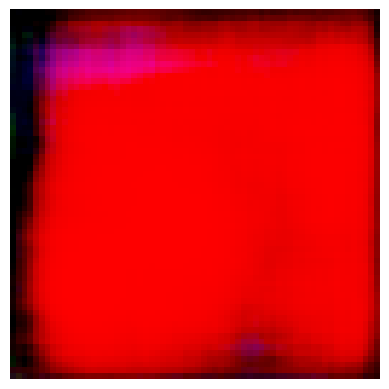

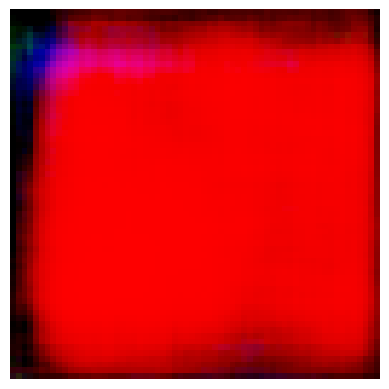

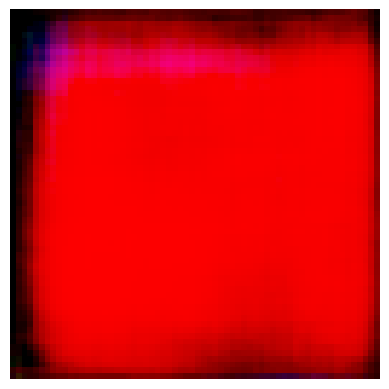

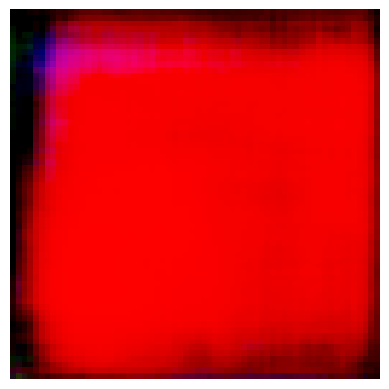

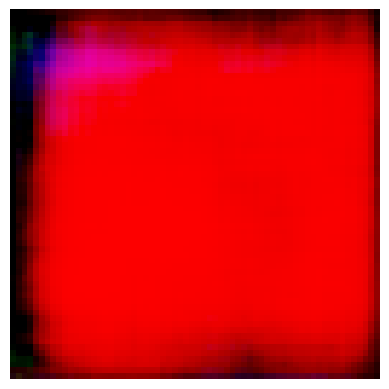

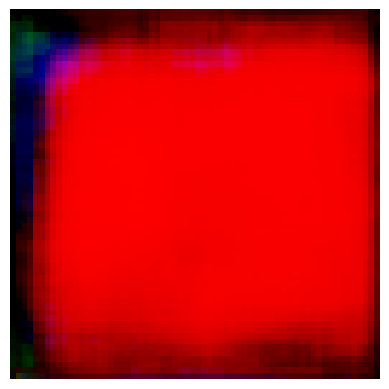

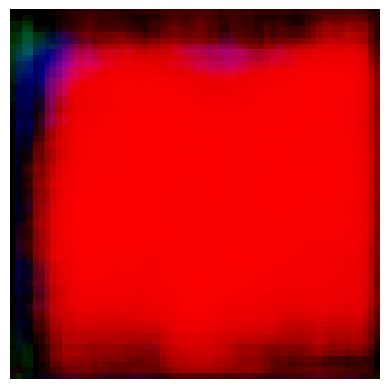

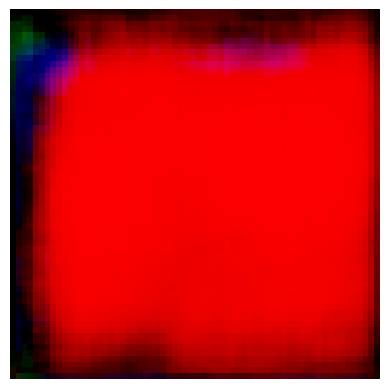

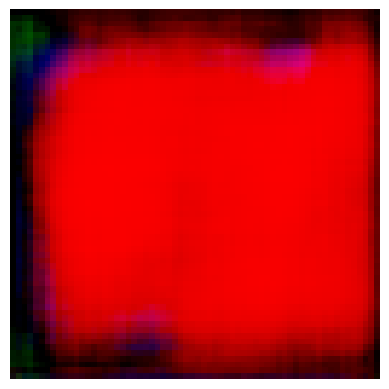

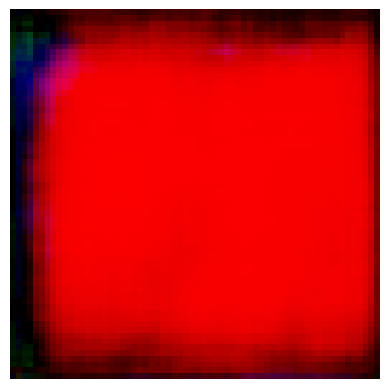

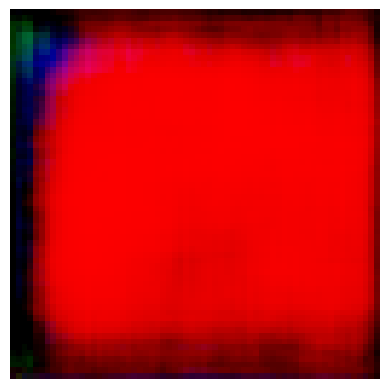

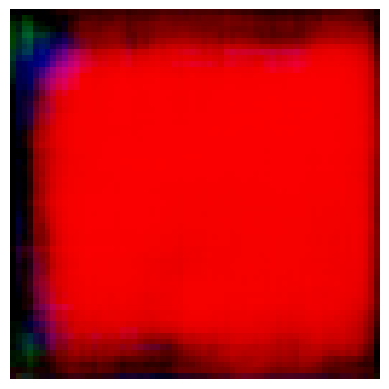

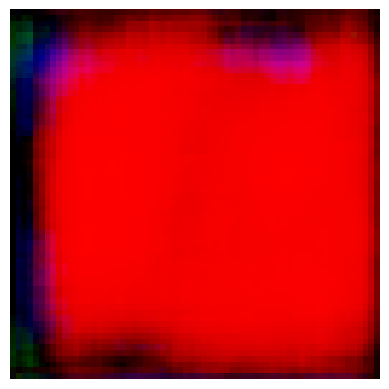

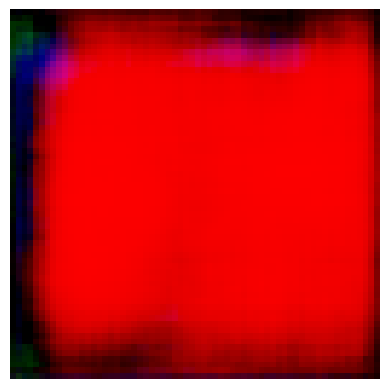

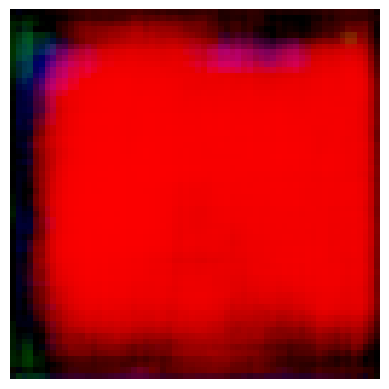

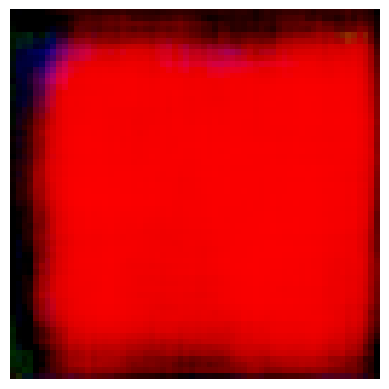

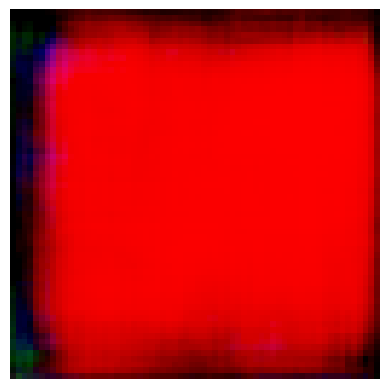

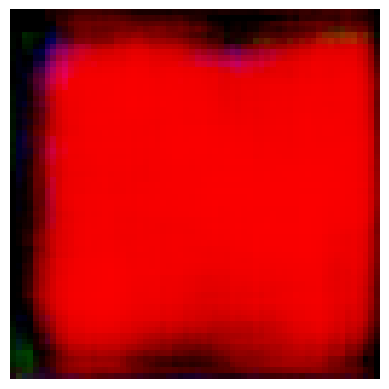

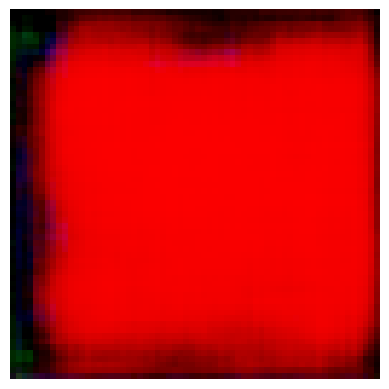

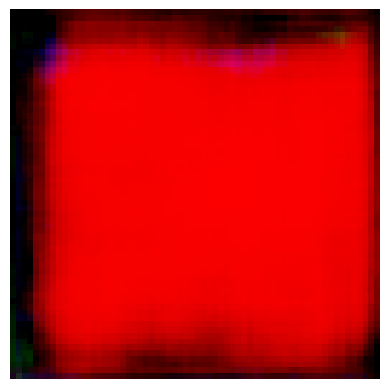

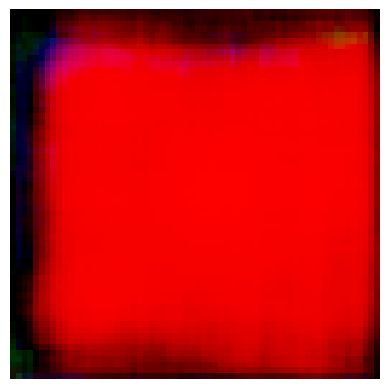

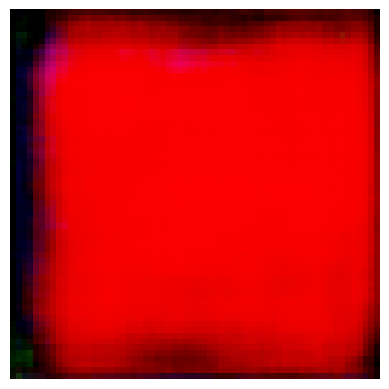

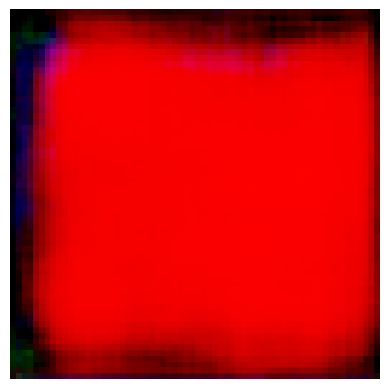

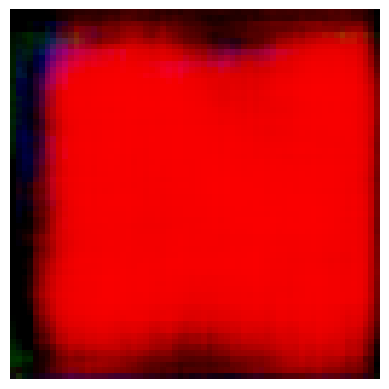

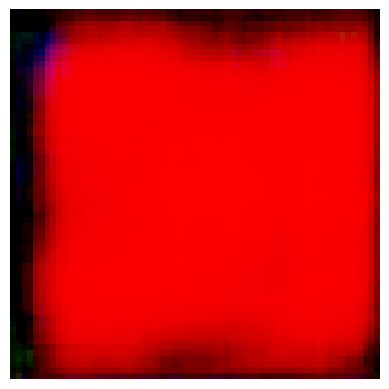

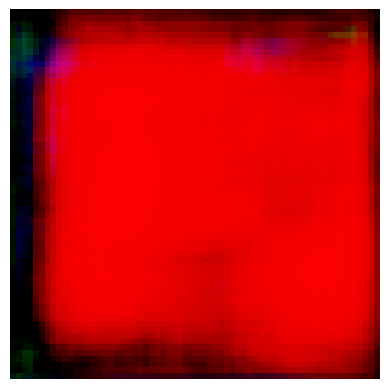

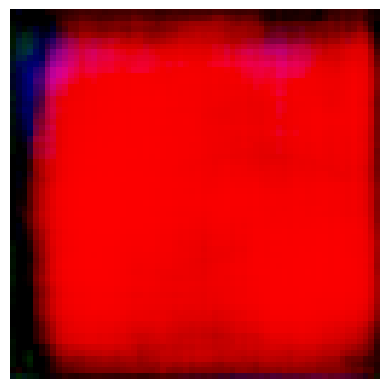

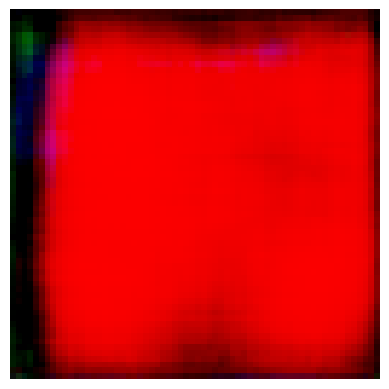

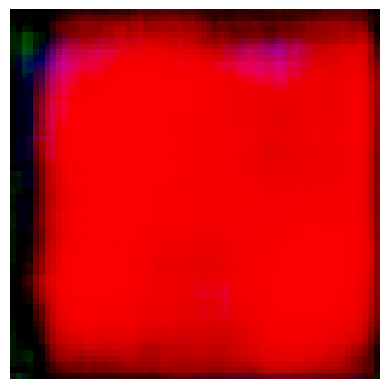

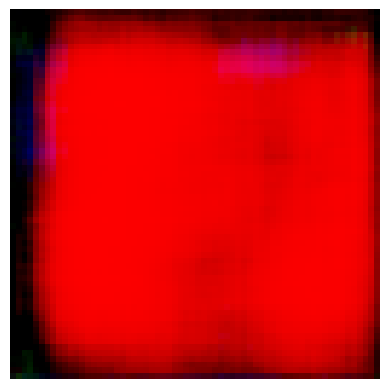

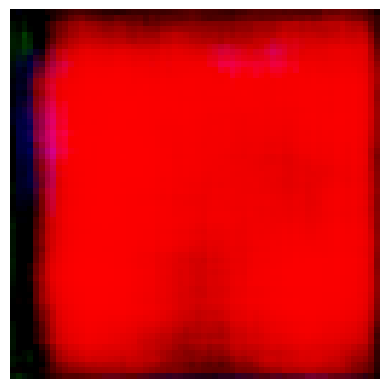

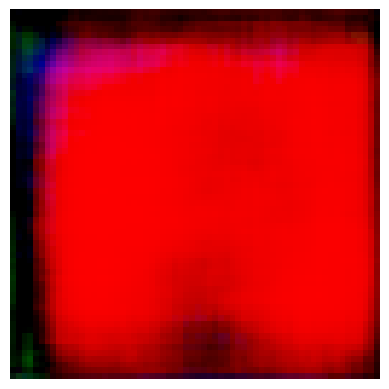

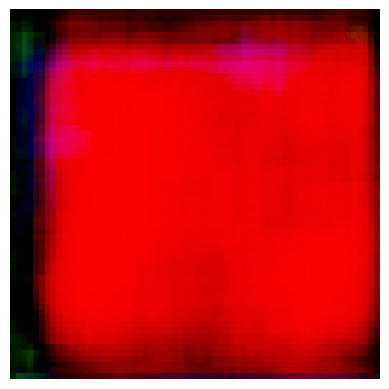

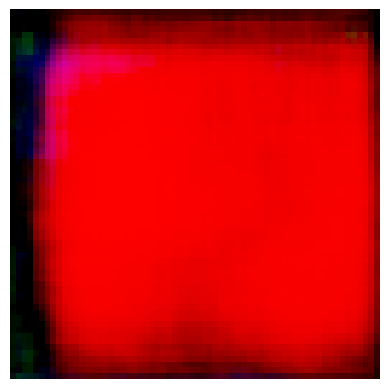

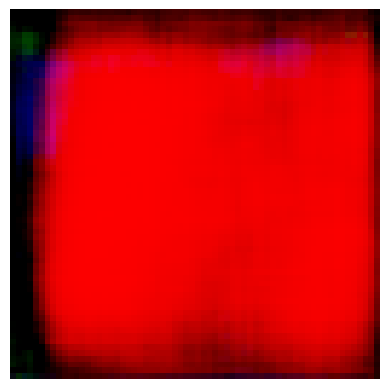

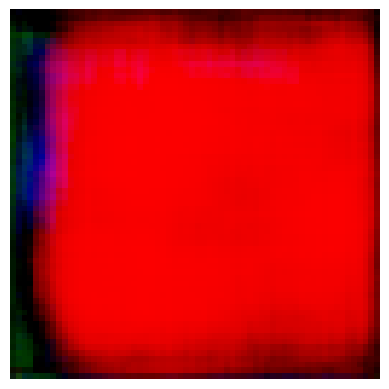

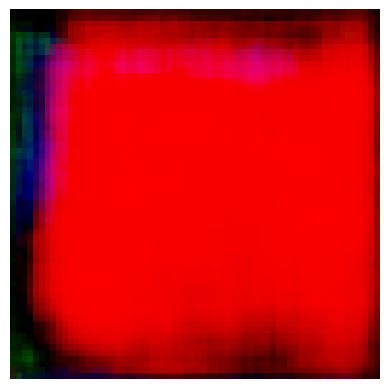

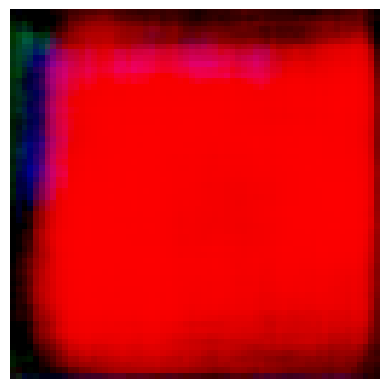

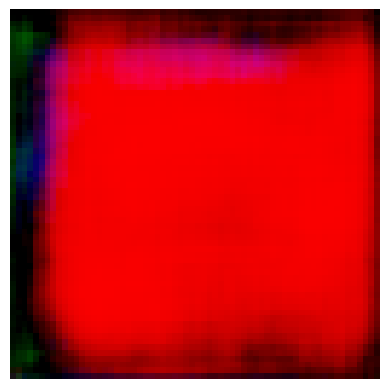

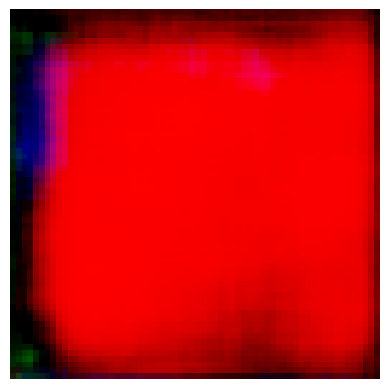

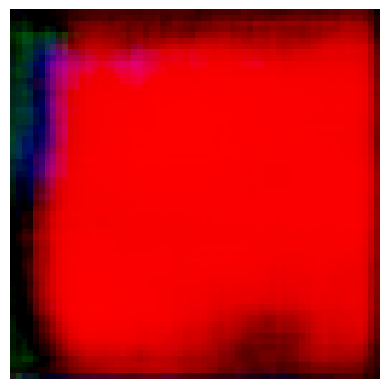

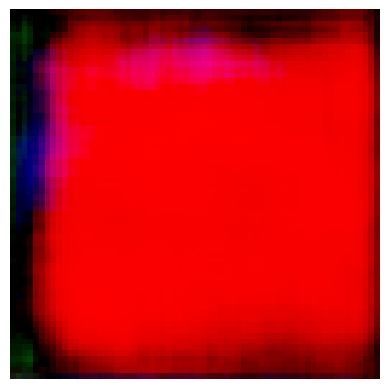

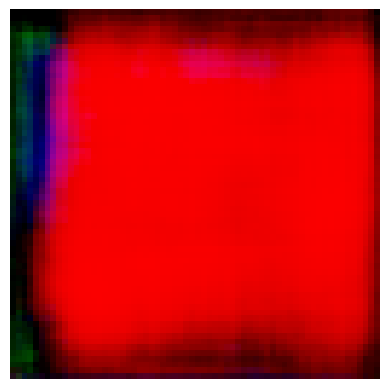

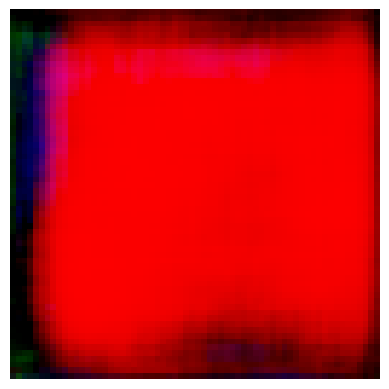

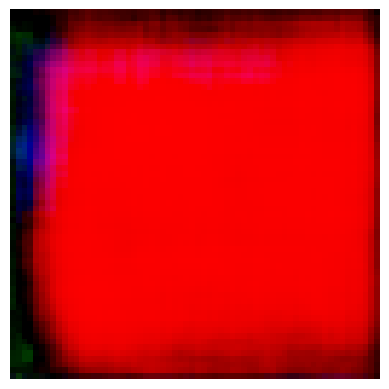

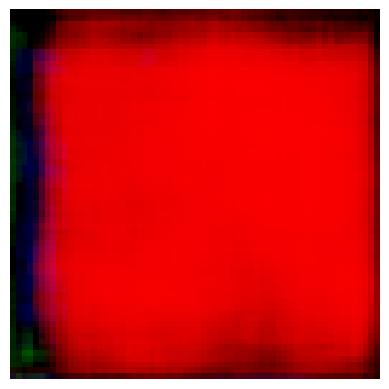

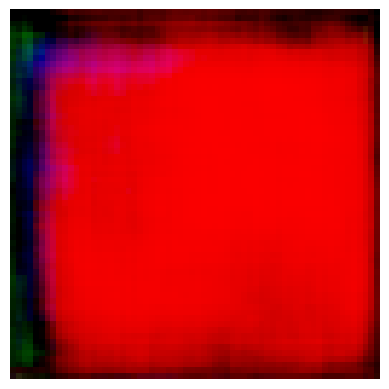

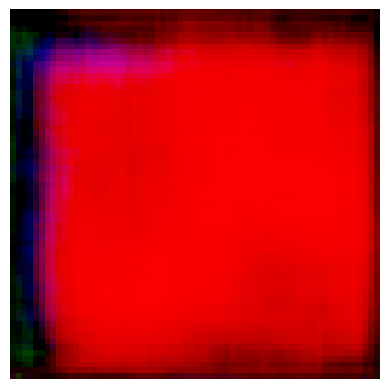

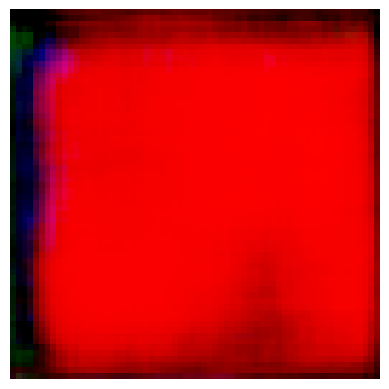

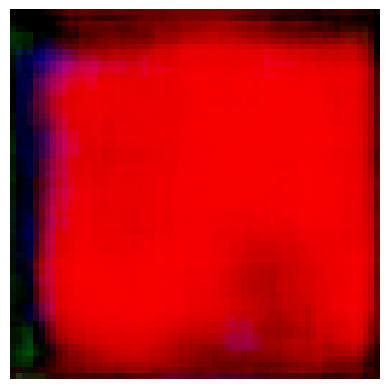

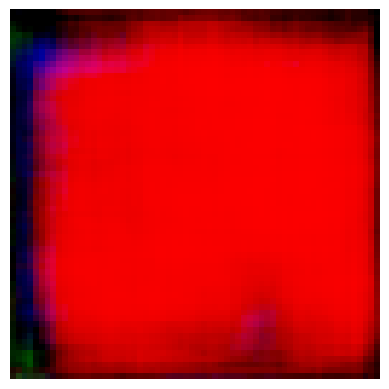

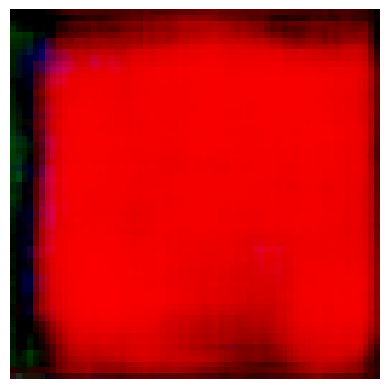

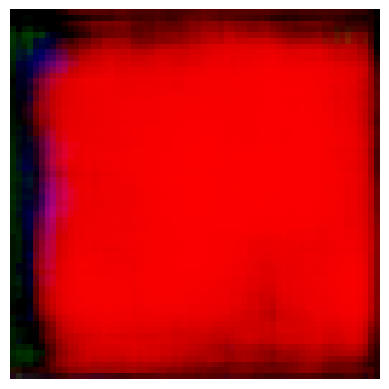

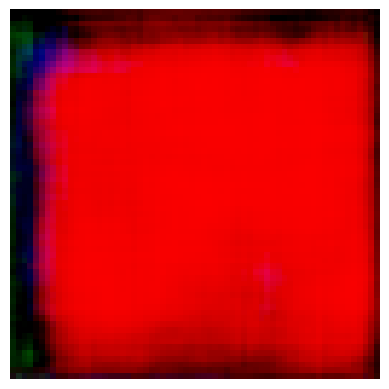

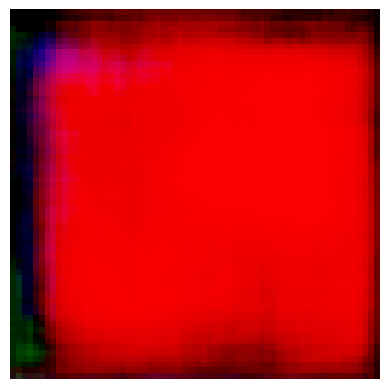

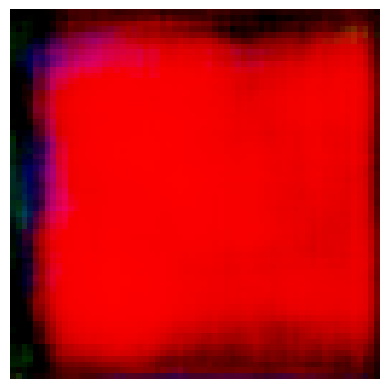

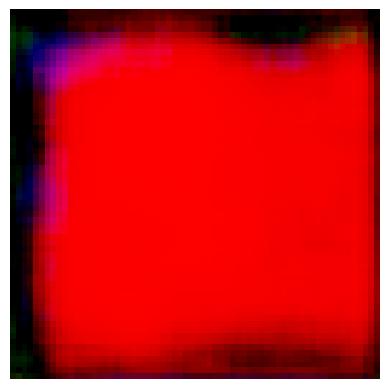

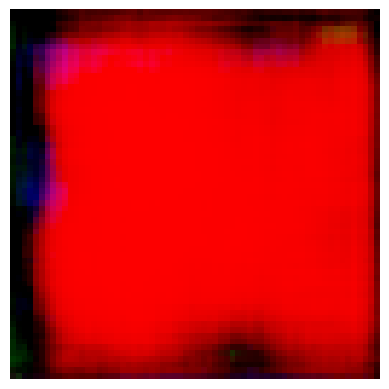

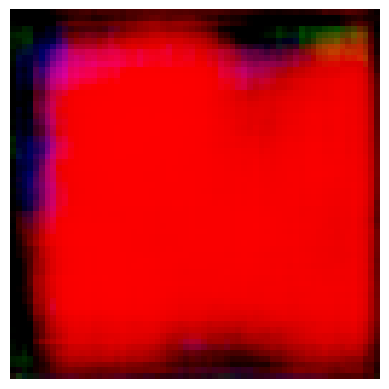

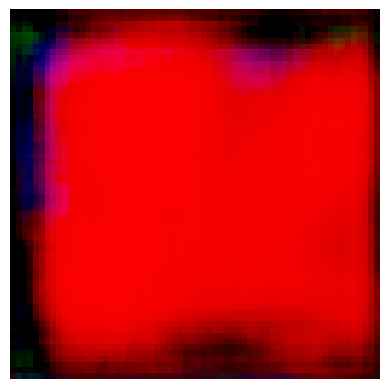

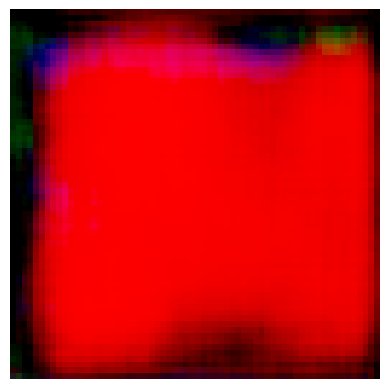

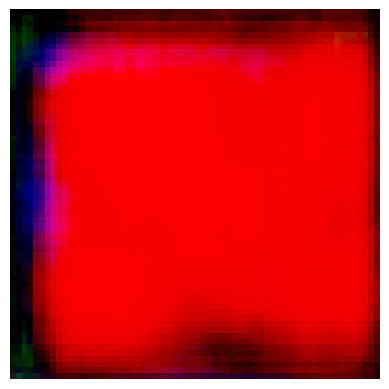

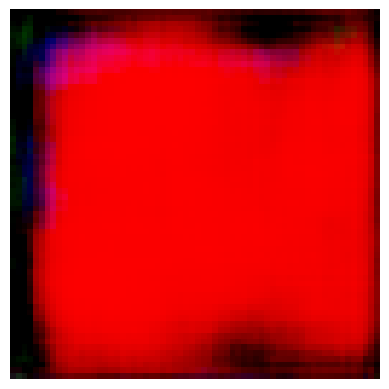

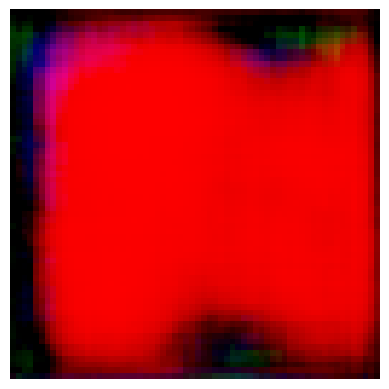

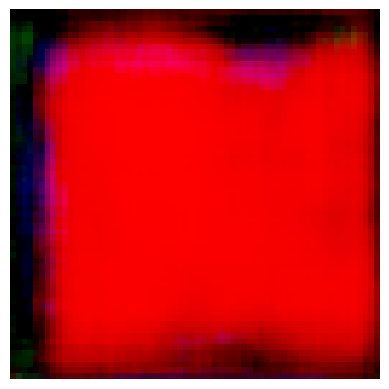

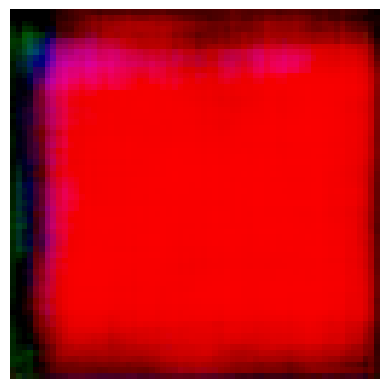

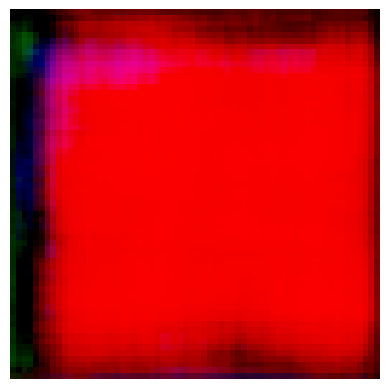

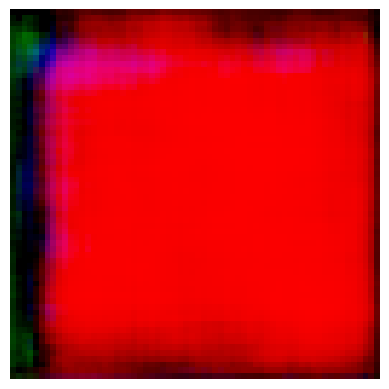

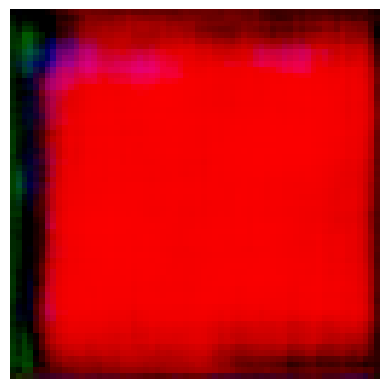

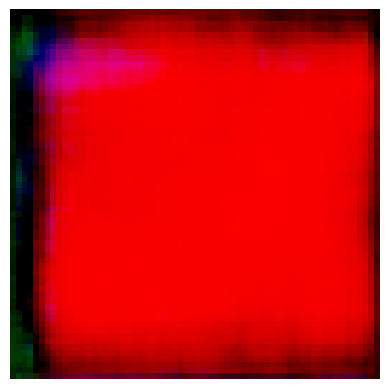

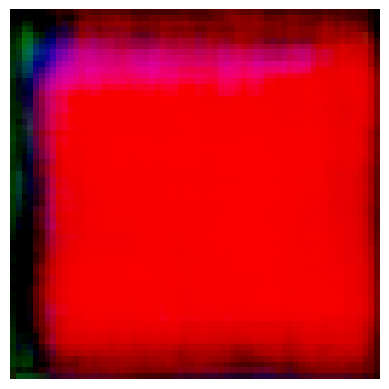

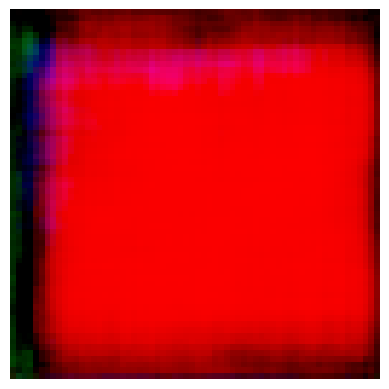

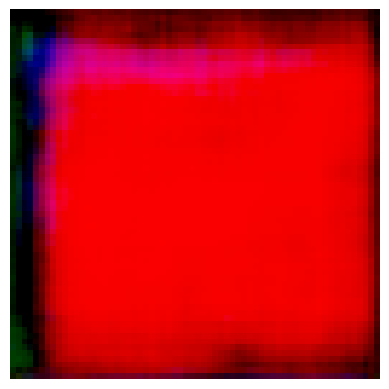

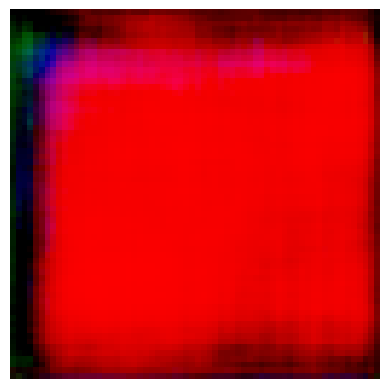

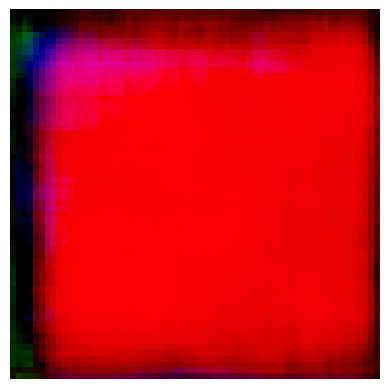

In [ ]:
class StackGanStage1(object):
# """StackGAN Stage 1 class."""
	data_dir = "/content/drive/MyDrive/StackGAN_1/birds"
	train_dir = data_dir + "/train"
	test_dir = data_dir + "/test"
	embeddings_path_train = train_dir + "/char-CNN-RNN-embeddings.pickle"
	embeddings_path_test = test_dir + "/char-CNN-RNN-embeddings.pickle"
	filename_path_train = train_dir + "/filenames.pickle"
	filename_path_test = test_dir + "/filenames.pickle"
	class_id_path_train = train_dir + "/class_info.pickle"
	class_id_path_test = test_dir + "/class_info.pickle"
	dataset_path = "/content/drive/MyDrive/StackGAN_1/CUB_200_2011/CUB_200_2011"

	def __init__(self, epochs=2, z_dim=100, batch_size=64, enable_function=True, stage1_generator_lr=0.0002, stage1_discriminator_lr=0.0002):
		self.epochs = epochs
		self.z_dim = z_dim
		self.enable_function = enable_function
		self.stage1_generator_lr = stage1_generator_lr
		self.stage1_discriminator_lr = stage1_discriminator_lr
		self.image_size = 64
		self.conditioning_dim = 128
		self.batch_size = batch_size

		self.stage1_generator_optimizer = Adam(learning_rate=stage1_generator_lr, beta_1=0.5, beta_2=0.999)
		self.stage1_discriminator_optimizer = Adam(learning_rate=stage1_discriminator_lr, beta_1=0.5, beta_2=0.999)

		self.stage1_generator = build_stage1_generator()
		self.stage1_generator.compile(loss='mse', optimizer=self.stage1_generator_optimizer)

		self.stage1_discriminator = build_stage1_discriminator()
		self.stage1_discriminator.compile(loss='binary_crossentropy', optimizer=self.stage1_discriminator_optimizer)

		self.ca_network = build_ca_network()
		self.ca_network.compile(loss='binary_crossentropy', optimizer='Adam')

		self.embedding_compressor = build_embedding_compressor()
		self.embedding_compressor.compile(loss='binary_crossentropy', optimizer='Adam')

		self.stage1_adversarial = build_adversarial(self.stage1_generator, self.stage1_discriminator)
		self.stage1_adversarial.compile(loss=['binary_crossentropy', adversarial_loss], loss_weights=[1, 2.0], optimizer=self.stage1_generator_optimizer)

		self.checkpoint1 = tf.train.Checkpoint(
					generator_optimizer=self.stage1_generator_optimizer,
					discriminator_optimizer=self.stage1_discriminator_optimizer,
					generator=self.stage1_generator,
					discriminator=self.stage1_discriminator)

	# def visualize_stage1(self):
	# 	"""Running Tensorboard visualizations.
	# 	"""
	# 	tb = TensorBoard(log_dir="logs/".format(time.time()))
	# 	tb.set_model(self.stage1_generator)
	# 	tb.set_model(self.stage1_discriminator)
	# 	tb.set_model(self.ca_network)
	# 	tb.set_model(self.embedding_compressor)

	def train_stage1(self):
		"""Trains the stage1 StackGAN.
		"""
		print('1')
		x_train, y_train, train_embeds = load_data(filename_path=self.filename_path_train, class_id_path=self.class_id_path_train,
			dataset_path=self.dataset_path, embeddings_path=self.embeddings_path_train, size=(64, 64))
		print('2')
		x_test, y_test, test_embeds = load_data(filename_path=self.filename_path_test, class_id_path=self.class_id_path_test,
			dataset_path=self.dataset_path, embeddings_path=self.embeddings_path_test, size=(64, 64))
		print('3')
		real = np.ones((self.batch_size, 1), dtype='float') * 0.9
		fake = np.zeros((self.batch_size, 1), dtype='float') * 0.1
		print('4')
		for epoch in range(self.epochs):
			print(f'Epoch: {epoch}')
			print('5')
			gen_loss = []
			dis_loss = []

			num_batches = int(x_train.shape[0] / self.batch_size)

			for i in range(num_batches):
				print('6')
				latent_space = np.random.normal(0, 1, size=(self.batch_size, self.z_dim))
				embedding_text = train_embeds[i * self.batch_size:(i + 1) * self.batch_size]
				compressed_embedding = self.embedding_compressor.predict_on_batch(embedding_text)
				compressed_embedding = np.reshape(compressed_embedding, (-1, 1, 1, 128))
				compressed_embedding = np.tile(compressed_embedding, (1, 4, 4, 1))
				print('7')
				image_batch = x_train[i * self.batch_size:(i+1) * self.batch_size]
				image_batch = (image_batch - 127.5) / 127.5
				print('8')
				gen_images, _ = self.stage1_generator.predict([embedding_text, latent_space])
				print('9')
				discriminator_loss = self.stage1_discriminator.train_on_batch([image_batch, compressed_embedding],
					np.reshape(real, (self.batch_size, 1)))
				print('10')
				discriminator_loss_gen = self.stage1_discriminator.train_on_batch([gen_images, compressed_embedding],
					np.reshape(fake, (self.batch_size, 1)))
				print('11')
				discriminator_loss_wrong = self.stage1_discriminator.train_on_batch([gen_images[: self.batch_size-1], compressed_embedding[1:]],
					np.reshape(fake[1:], (self.batch_size-1, 1)))
				print('12')
				# Discriminator loss
				d_loss = 0.5 * np.add(discriminator_loss, 0.5 * np.add(discriminator_loss_gen, discriminator_loss_wrong))
				dis_loss.append(d_loss)
				print('13')
				print(f'Discriminator Loss: {d_loss}')

				# Generator loss
				g_loss = self.stage1_adversarial.train_on_batch([embedding_text, latent_space, compressed_embedding],
					[K.ones((self.batch_size, 1)) * 0.9, K.ones((self.batch_size, 256)) * 0.9])

				print(f'Generator Loss: {g_loss}')
				gen_loss.append(g_loss)

				if epoch % 1 == 0:
						latent_space = np.random.normal(0, 1, size=(self.batch_size, self.z_dim))
						embedding_batch = test_embeds[0 : self.batch_size]
						gen_images, _ = self.stage1_generator.predict_on_batch([embedding_batch, latent_space])

						for i, image in enumerate(gen_images[:10]):
								save_image(image, f'/content/drive/MyDrive/StackGAN_1/output_stage1/gen_1_{epoch}_{i}')

				if epoch % 1 == 0:
					self.stage1_generator.save_weights('/content/drive/MyDrive/StackGAN_1/weights/stage1_gen.h5')
					self.stage1_discriminator.save_weights("/content/drive/MyDrive/StackGAN_1/weights/stage1_disc.h5")
					self.ca_network.save_weights('/content/drive/MyDrive/StackGAN_1/weights/stage1_ca.h5')
					self.embedding_compressor.save_weights('/content/drive/MyDrive/StackGAN_1/weights/stage1_embco.h5')
					self.stage1_adversarial.save_weights('/content/drive/MyDrive/StackGAN_1/weights/stage1_adv.h5')

		self.stage1_generator.save_weights('/content/drive/MyDrive/StackGAN_1/weights/stage1_gen.h5')
		self.stage1_discriminator.save_weights("/content/drive/MyDrive/StackGAN_1/weights/stage1_disc.h5")

stage1 = StackGanStage1()
stage1.train_stage1()


Concatenation:
The variable concat represents the concatenation of the conditioned text embedding and the random noise. The size of concat depends on the dimensions of the conditioning variable and the noise. Since the conditioning variable has a shape of (4, 4, 128) and the noise has a shape of (100,), the concatenation will result in a shape of (4, 4, 128+100) = (4, 4, 228).

Dense Layer:
The dense layer x = Dense(16384, use_bias=False)(concat) is then applied to the concatenated tensor concat. The choice of 16,384 units is not arbitrary but a design decision based on the desired output shape.

Reshape:
After the dense layer, the line x = Reshape((4, 4, 1024), input_shape=(16384,))(x) is used to reshape the tensor x. The purpose of this reshape is to convert the tensor from the flattened form (16384,) to a 4D tensor with the desired shape of (4, 4, 1024). The number of units in the dense layer (16,384) is chosen so that the reshaped tensor matches the desired output shape of (4, 4, 1024).

The FC layer is often used for the final prediction because it provides flexibility in learning complex non-linear relationships between the extracted features and the target output. The FC layer applies weights and biases to the input vector, allowing it to learn different patterns and combinations of features that contribute to the final prediction. The non-linear activation function applied after the FC layer further enhances the discriminative power of the model.

discriminator_loss: This loss is computed by training the discriminator on real images paired with their corresponding compressed and spatially replicated text embeddings. The discriminator is trained to predict the label "real" for these image-text pairs. The real variable is a numpy array of ones, which represents the target label for real images.

discriminator_loss_gen: This loss is calculated by training the discriminator on generated (fake) images paired with their corresponding compressed and spatially replicated text embeddings. The discriminator aims to predict the label "fake" for these image-text pairs. The fake variable is a numpy array of zeros, representing the target label for fake images.

discriminator_loss_wrong: This loss is computed by training the discriminator on pairs of generated images and shifted text embeddings. The generated images are shifted by one position (gen_images[: self.batch_size-1]) and paired with the corresponding compressed and spatially replicated text embeddings (compressed_embedding[1:]). The discriminator is trained to predict the label "fake" for these shifted image-text pairs. The fake variable is a numpy array of zeros, representing the target label for fake images.

ReLU (Rectified Linear Unit) is commonly used as an activation function in convolutional neural networks (CNNs) for several reasons:

Non-linearity: ReLU introduces non-linearity to the network, which is crucial for modeling complex relationships in the data. CNNs are powerful in learning hierarchical representations of images, and ReLU helps capture non-linear patterns and features effectively.

Sparse activation: ReLU provides sparse activation by outputting zero for negative input values. This sparsity promotes the emergence of sparse feature representations, where only a subset of the neurons is activated. Sparse activation can make the model more efficient in terms of computation and memory usage.

Addressing vanishing gradient: ReLU helps alleviate the vanishing gradient problem, which can occur during backpropagation. The gradient of ReLU is either 0 or 1, which avoids the diminishing gradient issue that can hinder the training of deep networks.

Computationally efficient: The ReLU function is computationally efficient compared to other activation functions, such as sigmoid or hyperbolic tangent. The ReLU operation involves simple thresholding, making it faster to compute.

However, ReLU has some limitations. One of them is the "dying ReLU" problem, where neurons can become stuck in a state of zero activation and cease to contribute to the learning process. To address this, variants like Leaky ReLU and Parametric ReLU (PReLU) have been proposed, which introduce a small slope or learnable parameters for negative input values, respectively.

Overall, ReLU is a popular choice for activation in convolutional layers due to its simplicity, non-linearity, computational efficiency, and ability to address the vanishing gradient problem.








In [ ]:
# this function combines the image ad the encoded text
# c-> conditioned text x->encoded image
# Before any transformation:
# Size of c: (batch_size, embedding_size)
# After the first expand_dims operation:
# Size of c: (batch_size, 1, embedding_size)
# After the second expand_dims operation:
# Size of c: (batch_size, 1, 1, embedding_size)
# After the tile operation:
# Size of c: (batch_size, 16, 16, embedding_size)
# The concat_along_dims function takes two inputs, conditioned text (c) and encoded image (x), and concatenates them along specific dimensions. The purpose is to combine the information from both sources to generate an image.
# c is expanded by adding two dimensions using K.expand_dims to match the dimensions of the encoded image.
# Then, c is tiled to match the spatial dimensions of the encoded image. This creates copies of the conditioned text across a 2D grid.
# Finally, the expanded and tiled conditioned text c is concatenated with the encoded image x along the channel dimension using K.concatenate.
def concat_along_dims(inputs):
	c = inputs[0]
	x = inputs[1]
	c = K.expand_dims(K.expand_dims(c, axis=1), axis=1)
	c = K.tile(c, [1, 16, 16, 1])
	return K.concatenate([c, x], axis = 3)

# A residual block takes an input tensor (input) and applies a series of operations to transform it.
# The input tensor is passed through two convolutional layers with 512 filters and a kernel size of (3, 3).
# Each convolutional layer is followed by batch normalization and ReLU activation.
# The output of the second convolutional layer is added element-wise to the original input tensor (input) using the add function.
# The output is then passed through ReLU activation again, and the final result is returned.
# The purpose of the residual block is to enable the network to learn residual (or residual-like) mappings,
# which can help in capturing complex patterns and details in the image data. The residual connections, where the original input is added to the transformed output,
# allow for the information to bypass the convolutional layers if needed. This helps in preserving important information and gradients during training,
# improving the flow of gradients and enabling deeper networks to be trained more effectively.
def residual_block(input):
	x = Conv2D(512, kernel_size=(3,3), padding='same', use_bias=False,
				kernel_initializer='he_uniform')(input)
	x = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x)
	x = ReLU()(x)
	x = Conv2D(512, kernel_size=(3,3), padding='same', use_bias=False,
				kernel_initializer='he_uniform')(x)
	x = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x)
	x = add([x, input])
	x = ReLU()(x)
	return x
# Residual mappings address this problem by introducing "shortcut connections" or "skip connections" that allow the information from the
# input to bypass one or more layers and directly propagate to subsequent layers. These skip connections are achieved by adding the original
# input tensor to the output tensor of a transformation block.

# Inputs:
# The function takes two inputs: input_layer1 and input_images.
# input_layer1 represents a vector of shape (batch_size, 1024) containing some information.
# input_images represents images with dimensions (64, 64, 3) (width, height, channels).
# Conditioning Augmentation:
# The input_layer1 is passed through a fully connected layer (Dense(256)), resulting in ca with dimensions (batch_size, 256).
# The activation function LeakyReLU is applied to ca with a small negative slope, resulting in mls with dimensions (batch_size, 256).
# The purpose of conditioning augmentation is to process the input information and prepare it for further operations.
# Downsampling Block:
# input_images undergoes padding, convolution, and activation operations to reduce its spatial dimensions while increasing the number of channels.
# After each operation, the output tensor x gets updated and is passed to the next operation.
# Concatenation:
# The conditioned text variable c (obtained from mls) and the output tensor x are concatenated along the channel dimension using the concat_along_dims function.
# This concatenation merges the information from the conditioned text with the image representation.
# Residual Blocks:
# The concatenated tensor is passed through a series of residual blocks.
# Each residual block consists of two convolutional layers and a skip connection that adds the original input tensor to the output tensor.
# These residual blocks help capture and refine the combined information.
# Upsampling Blocks:
# The output tensor from the residual blocks undergoes a series of upsampling operations.
# Each upsampling block increases the spatial dimensions while reducing the number of channels.
# Final Layers:
# The last layer applies a convolutional operation followed by a tanh activation function to generate the final output image tensor x with dimensions (batch_size, 64, 64, 3).
# Additionally, the conditioned text variable mls is also included in the model's outputs.
def build_stage2_generator():
	input_layer1 = Input(shape=(1024,))
	input_images = Input(shape=(64, 64, 3))
	# Conditioning Augmentation
	ca = Dense(256)(input_layer1) # (batch_size, 256)
	mls = LeakyReLU(alpha=0.2)(ca) # (batch_size, 256)
	c = Lambda(conditioning_augmentation)(mls) # (batch_size, 128)
	# Downsampling block
	x = ZeroPadding2D(padding=(1,1))(input_images)
	x = Conv2D(128, kernel_size=(3,3), strides=1, use_bias=False,
				kernel_initializer='he_uniform')(x)
	x = ReLU()(x)
	x = ZeroPadding2D(padding=(1,1))(x)
	x = Conv2D(256, kernel_size=(4,4), strides=2, use_bias=False,
				kernel_initializer='he_uniform')(x)
	x = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x)
	x = ReLU()(x)
	x = ZeroPadding2D(padding=(1,1))(x)
	x = Conv2D(512, kernel_size=(4,4), strides=2, use_bias=False,
				kernel_initializer='he_uniform')(x)
	x = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x)
	x = ReLU()(x)
	# Concatenate text conditioning block with the encoded image
	concat = concat_along_dims([c, x])
	# Residual Blocks
	x = ZeroPadding2D(padding=(1,1))(concat)
	x = Conv2D(512, kernel_size=(3,3), use_bias=False, kernel_initializer='he_uniform')(x)
	x = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x)
	x = ReLU()(x)
	x = residual_block(x)
	x = residual_block(x)
	x = residual_block(x)
	x = residual_block(x)
	# Upsampling Blocks
	x = UpSamplingBlock(x, 512)
	x = UpSamplingBlock(x, 256)
	x = UpSamplingBlock(x, 128)
	x = UpSamplingBlock(x, 64)
	x = Conv2D(3, kernel_size=(3,3), padding='same', use_bias=False, kernel_initializer='he_uniform')(x)
	x = Activation('tanh')(x) # (batch_size, 64, 64, 3)
	stage2_gen = Model(inputs=[input_layer1, input_images], outputs=[x, mls])
	return stage2_gen

generator_stage2 = build_stage2_generator()
generator_stage2.summary()

# Conditioning Augmentation:
# Purpose: The conditioning augmentation block processes the input information (input_layer1) and prepares it for further operations. It transforms the input into a conditioned text variable (mls) that captures relevant characteristics and variations to be combined with the image representation.
# Downsampling Block:
# Purpose: The downsampling block reduces the spatial dimensions of the input image (input_images) while increasing the number of channels. It helps capture higher-level features and patterns, extracting important information from the image in a lower-dimensional space.
# Concatenation:
# Purpose: The concatenation step merges the conditioned text variable (c) obtained from the conditioning augmentation block with the processed image representation (x) from the downsampling block. This concatenation combines the information from both sources, allowing the generator to generate images conditioned on the input text.
# Residual Blocks:
# Purpose: The residual blocks help capture and refine the combined information from the concatenated tensor. Each residual block consists of two convolutional layers and a skip connection. The convolutional layers extract and transform features, while the skip connection adds the original input tensor to the output tensor, allowing the network to retain important information and facilitate gradient flow during training.
# Upsampling Blocks:
# Purpose: The upsampling blocks recover the lost spatial resolution during downsampling. They increase the spatial dimensions of the tensor while reducing the number of channels. Upsampling helps to recreate fine-grained details and spatial structure, ensuring the generated image is coherent and visually appealing.
# Final Layers:
# Purpose: The final layers perform a convolutional operation followed by a tanh activation function. This generates the final output image tensor (x) with dimensions (batch_size, 64, 64, 3). The tanh activation ensures the pixel values are in the range [-1, 1], producing a realistic and visually appealing image. Additionally, the conditioned text variable (mls) is also included in the model's outputs, providing information about the conditioning text used to generate the image.

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 66, 66, 3)   0           ['input_18[0][0]']               
                                                                                                  
 conv2d_20 (Conv2D)             (None, 64, 64, 128)  3456        ['zero_padding2d[0][0]']         
                                                                                                  
 re_lu_3 (ReLU)                 (None, 64, 64, 128)  0           ['conv2d_20[0][0]']              
                                                                                            

In [ ]:
# Input:
# The function takes an input tensor input_layer1 with dimensions (256, 256, 3). This represents an image.
# Convolutional Layers:
# Purpose: The convolutional layers (Conv2D) perform operations to extract features from the input image (input_layer1). They use filters to scan the image and capture different patterns and structures. The chosen kernel size, padding, and strides determine the size and depth of the output feature maps.
# LeakyReLU Activation:
# Purpose: The LeakyReLU activation function introduces a small negative slope to prevent dead neurons and enhance the learning capabilities of the network. It adds non-linearity to the feature maps obtained from the convolutional layers.
# ConvBlock:
# Purpose: The ConvBlock is a custom function that applies a series of convolutional operations with different parameters, such as number of filters and kernel size. It further enhances the feature representation and complexity of the input.
# Add and LeakyReLU:
# Purpose: The add operation combines the outputs from two ConvBlocks, x and x1, element-wise. The resulting tensor x2 captures relevant features from both branches and helps increase the discriminative power of the network. The subsequent LeakyReLU activation adds non-linearity to the combined tensor.
# Concatenation:
# Purpose: The compressed and spatially replicated embedding (input_layer2) is concatenated with the tensor x2. This combines the learned features from the image and the embedding to provide a joint representation for discrimination.
# Conv2D and BatchNormalization:
# Purpose: The Conv2D layer performs a convolution operation on the concatenated tensor (concat), reducing its dimensionality while increasing the number of filters. The BatchNormalization layer normalizes the activations, making the model more robust and aiding in training.
# LeakyReLU Activation:
# Purpose: The LeakyReLU activation function is applied again to introduce non-linearity and enhance the discrimination capability of the model.
# Flatten and Dense Layer:
# Purpose: The Flatten layer reshapes the output tensor into a 1-dimensional vector, preparing it for the final classification. The Dense layer applies a fully connected operation, connecting all neurons from the flattened tensor, and produces a single value representing the discriminator's decision.
# Sigmoid Activation:
# Purpose: The Sigmoid activation function squashes the output value between 0 and 1, representing the probability of the input image being real (1) or fake (0).


def build_stage2_discriminator():
	input_layer1 = Input(shape=(256, 256, 3))
	x = Conv2D(64, kernel_size=(4,4), padding='same', strides=2, use_bias=False,
				kernel_initializer='he_uniform')(input_layer1)
	x = LeakyReLU(alpha=0.2)(x)
	x = ConvBlock(x, 128)
	x = ConvBlock(x, 256)
	x = ConvBlock(x, 512)
	x = ConvBlock(x, 1024)
	x = ConvBlock(x, 2048)
	x = ConvBlock(x, 1024, (1,1), 1)
	x = ConvBlock(x, 512, (1,1), 1, False)
	x1 = ConvBlock(x, 128, (1,1), 1)
	x1 = ConvBlock(x1, 128, (3,3), 1)
	x1 = ConvBlock(x1, 512, (3,3), 1, False)
	x2 = add([x, x1])
	x2 = LeakyReLU(alpha=0.2)(x2)
	# Concatenate compressed and spatially replicated embedding
	input_layer2 = Input(shape=(4, 4, 128))
	concat = concatenate([x2, input_layer2])
	x3 = Conv2D(512, kernel_size=(1,1), strides=1, padding='same', kernel_initializer='he_uniform')(concat)
	x3 = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x3)
	x3 = LeakyReLU(alpha=0.2)(x3)
	# Flatten and add a FC layer
	x3 = Flatten()(x3)
	x3 = Dense(1)(x3)
	x3 = Activation('sigmoid')(x3)
	stage2_dis = Model(inputs=[input_layer1, input_layer2], outputs=[x3])
	return stage2_dis

discriminator_stage2 = build_stage2_discriminator()
discriminator_stage2.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_37 (Conv2D)             (None, 128, 128, 64  3072        ['input_19[0][0]']               
                                )                                                                 
                                                                                                  
 leaky_re_lu_26 (LeakyReLU)     (None, 128, 128, 64  0           ['conv2d_37[0][0]']              
                                )                                                           

In [ ]:
# The stage2_adversarial_network function combines the Stage 2 discriminator (stage2_disc), Stage 2 generator (stage2_gen), and the already trained Stage 1 generator (stage1_gen) to create an adversarial network.
# The adversarial network takes three inputs: conditioned_embedding, latent_space, and compressed_replicated. These inputs represent the conditioned text, random noise, and a compressed and replicated embedding.
# The Stage 1 generator (stage1_gen) is used to generate an image (input_images) from the conditioned text and random noise inputs. This is done separately because the discriminator and Stage 1 generator are trained independently. The ca variable represents the conditioned text from Stage 1.
# The stage2_disc and stage1_gen models are set to be not trainable (trainable=False). This means that their weights will not be updated during the training of the adversarial network. We freeze them because they have already been trained separately and their weights should not be changed.
# The stage2_gen model is used to generate images (images) from the conditioned text and the generated image from Stage 1 (input_images). The ca2 variable represents the conditioned text from Stage 2.
# The stage2_disc is then used to calculate the probability (probability) of the generated images being real or fake. The inputs to the discriminator are the generated images and the compressed and replicated embedding.
# Finally, the adversarial network is created by defining its inputs (conditioned text, random noise, and compressed and replicated embedding) and outputs (probability and conditioned text from Stage 2).
# The resulting adversarial network is stored in the variable adversarial_stage2.

def stage2_adversarial_network(stage2_disc, stage2_gen, stage1_gen):
	conditioned_embedding = Input(shape=(1024, ))
	latent_space = Input(shape=(100, ))
	compressed_replicated = Input(shape=(4, 4, 128))
	#the discriminator is trained separately and stage1_gen already trained, and this is the reason why we freeze its layers by setting the property trainable=false
	input_images, ca = stage1_gen([conditioned_embedding, latent_space])
	stage2_disc.trainable = False
	stage1_gen.trainable = False
	images, ca2 = stage2_gen([conditioned_embedding, input_images])
	probability = stage2_disc([images, compressed_replicated])

	return Model(inputs=[conditioned_embedding, latent_space, compressed_replicated],
		outputs=[probability, ca2])

adversarial_stage2 = stage2_adversarial_network(discriminator_stage2, generator_stage2, generator)
adversarial_stage2.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 1024)]       0           []                               
                                                                                                  
 input_22 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 model (Functional)             [(None, 64, 64, 3),  10270400    ['input_21[0][0]',               
                                 (None, 256)]                     'input_22[0][0]']               
                                                                                                  
 model_8 (Functional)           [(None, 256, 256, 3  28645440    ['input_21[0][0]',        

In [ ]:
class StackGanStage2(object):
	data_dir = "/content/drive/MyDrive/StackGAN_1/birds"
	train_dir = data_dir + "/train"
	test_dir = data_dir + "/test"
	embeddings_path_train = train_dir + "/char-CNN-RNN-embeddings.pickle"
	embeddings_path_test = test_dir + "/char-CNN-RNN-embeddings.pickle"
	filename_path_train = train_dir + "/filenames.pickle"
	filename_path_test = test_dir + "/filenames.pickle"
	class_id_path_train = train_dir + "/class_info.pickle"
	class_id_path_test = test_dir + "/class_info.pickle"
	dataset_path = "/content/drive/MyDrive/StackGAN_1/CUB_200_2011/CUB_200_2011"

	def __init__(self, epochs=1, z_dim=100, batch_size=32, enable_function=True, stage2_generator_lr=0.0002, stage2_discriminator_lr=0.0002):
		self.epochs = epochs
		self.z_dim = z_dim
		self.enable_function = enable_function
		self.stage1_generator_lr = stage2_generator_lr
		self.stage1_discriminator_lr = stage2_discriminator_lr
		self.low_image_size = 64
		self.high_image_size = 256
		self.conditioning_dim = 128
		self.batch_size = batch_size
		self.stage2_generator_optimizer = Adam(learning_rate=stage2_generator_lr, beta_1=0.5, beta_2=0.999)
		self.stage2_discriminator_optimizer = Adam(learning_rate=stage2_discriminator_lr, beta_1=0.5, beta_2=0.999)
		self.stage1_generator = build_stage1_generator()
		self.stage1_generator.compile(loss='binary_crossentropy', optimizer=self.stage2_generator_optimizer)
		self.stage1_generator.load_weights('/content/drive/MyDrive/StackGAN_1/weights/stage1_gen.h5')
		self.stage2_generator = build_stage2_generator()
		self.stage2_generator.compile(loss='binary_crossentropy', optimizer=self.stage2_generator_optimizer)

		self.stage2_discriminator = build_stage2_discriminator()
		self.stage2_discriminator.compile(loss='binary_crossentropy', optimizer=self.stage2_discriminator_optimizer)

		self.ca_network = build_ca_network()
		self.ca_network.compile(loss='binary_crossentropy', optimizer='Adam')

		self.embedding_compressor = build_embedding_compressor()
		self.embedding_compressor.compile(loss='binary_crossentropy', optimizer='Adam')

		self.stage2_adversarial = stage2_adversarial_network(self.stage2_discriminator, self.stage2_generator, self.stage1_generator)
		self.stage2_adversarial.compile(loss=['binary_crossentropy', adversarial_loss], loss_weights=[1, 2.0], optimizer=self.stage2_generator_optimizer)

		self.checkpoint2 = tf.train.Checkpoint(
        	generator_optimizer=self.stage2_generator_optimizer,
        	discriminator_optimizer=self.stage2_discriminator_optimizer,
        	generator=self.stage2_generator,
        	discriminator=self.stage2_discriminator,
        	generator1=self.stage1_generator)

	# def visualize_stage2(self):
	# 	"""Running Tensorboard visualizations.
	# 	"""
	# 	tb = TensorBoard(log_dir="logs/".format(time.time()))
	# 	tb.set_model(self.stage2_generator)
	# 	tb.set_model(self.stage2_discriminator)

# The train_stage2 method is responsible for training the second stage of the StackGAN model.
# It loads the training and testing data, prepares real and fake labels, and initializes empty lists for tracking generator and discriminator losses.
# It iterates through the epochs and within each epoch, iterates through the batches of training data.
# For each batch, it performs the following steps:
# Generates random latent space vectors and retrieves the corresponding embedding text for the batch.
# Compresses the embedding text using the embedding compressor model.
# Preprocesses the real images and generates low-resolution fake images using the stage 1 generator.
# Generates high-resolution fake images using the stage 2 generator.
# Trains the discriminator on real and fake images using the stage 2 discriminator.
# Calculates and stores the discriminator loss.
# Trains the adversarial network (generator) using the stage 2 adversarial model.
# Calculates and stores the generator loss.
# After each epoch, it saves the weights of the models and generates some sample images for visual inspection.
	def train_stage2(self):
		x_high_train, y_high_train, high_train_embeds = load_data(filename_path=self.filename_path_train, class_id_path=self.class_id_path_train,
      dataset_path=self.dataset_path, embeddings_path=self.embeddings_path_train, size=(256, 256))
		x_high_test, y_high_test, high_test_embeds = load_data(filename_path=self.filename_path_test, class_id_path=self.class_id_path_test,
      dataset_path=self.dataset_path, embeddings_path=self.embeddings_path_test, size=(256, 256))
		x_low_train, y_low_train, low_train_embeds = load_data(filename_path=self.filename_path_train, class_id_path=self.class_id_path_train,
      dataset_path=self.dataset_path, embeddings_path=self.embeddings_path_train, size=(64, 64))
		x_low_test, y_low_test, low_test_embeds = load_data(filename_path=self.filename_path_test, class_id_path=self.class_id_path_test,
      dataset_path=self.dataset_path, embeddings_path=self.embeddings_path_test, size=(64, 64))

		real = np.ones((self.batch_size, 1), dtype='float') * 0.9
		fake = np.zeros((self.batch_size, 1), dtype='float') * 0.1

		for epoch in range(self.epochs):
			print(f'Epoch: {epoch}')
			gen_loss = []
			disc_loss = []
			num_batches = int(x_high_train.shape[0] / self.batch_size)
			for i in range(num_batches):
				latent_space = np.random.normal(0, 1, size=(self.batch_size, self.z_dim))
				embedding_text = high_train_embeds[i * self.batch_size:(i + 1) * self.batch_size]
				compressed_embedding = self.embedding_compressor.predict_on_batch(embedding_text)
				compressed_embedding = np.reshape(compressed_embedding, (-1, 1, 1, self.conditioning_dim))
				compressed_embedding = np.tile(compressed_embedding, (1, 4, 4, 1))
				image_batch = x_high_train[i * self.batch_size:(i+1) * self.batch_size]
				image_batch = (image_batch - 127.5) / 127.5
				low_res_fakes, _ = self.stage1_generator.predict([embedding_text, latent_space], verbose=3)
				high_res_fakes, _ = self.stage2_generator.predict([embedding_text, low_res_fakes], verbose=3)
				discriminator_loss = self.stage2_discriminator.train_on_batch([image_batch, compressed_embedding],
					np.reshape(real, (self.batch_size, 1)))
				discriminator_loss_gen = self.stage2_discriminator.train_on_batch([high_res_fakes, compressed_embedding],
					np.reshape(fake, (self.batch_size, 1)))
				discriminator_loss_fake = self.stage2_discriminator.train_on_batch([image_batch[:(self.batch_size-1)], compressed_embedding[1:]],
					np.reshape(fake[1:], (self.batch_size - 1, 1)))
				d_loss = 0.5 * np.add(discriminator_loss, 0.5 * np.add(discriminator_loss_gen, discriminator_loss_fake))
				disc_loss.append(d_loss)
				print(f'Discriminator Loss: {d_loss}')
				g_loss = self.stage2_adversarial.train_on_batch([embedding_text, latent_space, compressed_embedding],
					[K.ones((self.batch_size, 1)) * 0.9, K.ones((self.batch_size, 256)) * 0.9])
				gen_loss.append(g_loss)
				print(f'Generator Loss: {g_loss}')
				if epoch % 1 == 0:
					latent_space = np.random.normal(0, 1, size=(self.batch_size, self.z_dim))
					embedding_batch = high_test_embeds[0 : self.batch_size]
					low_fake_images, _ = self.stage1_generator.predict([embedding_batch, latent_space], verbose=3)
					high_fake_images, _ = self.stage2_generator.predict([embedding_batch, low_fake_images], verbose=3)
					for i, image in enumerate(high_fake_images[:10]):
					    save_image(image, f'/content/drive/MyDrive/StackGAN_1/output_stage2/gen_{epoch}_{i}.png')

			if epoch % 1 == 0:
					self.stage2_generator.save_weights('/content/drive/MyDrive/StackGAN_1/weights/stage2_gen.h5')
					self.stage2_discriminator.save_weights("/content/drive/MyDrive/StackGAN_1/weights/stage2_disc.h5")
					self.ca_network.save_weights('/content/drive/MyDrive/StackGAN_1/weights/stage2_ca.h5')
					self.embedding_compressor.save_weights('/content/drive/MyDrive/StackGAN_1/weights/stage2_embco.h5')
					self.stage2_adversarial.save_weights('/content/drive/MyDrive/StackGAN_1/weights/stage2_adv.h5')

		self.stage2_generator.save_weights('/content/drive/MyDrive/StackGAN_1/weights/stage2_gen.h5')
		self.stage2_discriminator.save_weights("/content/drive/MyDrive/StackGAN_1/weights/stage2_disc.h5")

stage2 = StackGanStage2()
stage2.train_stage2()